# Topic Modeling - LDA

In [1]:
import glob
from datetime import datetime
import logging
import logging as log
import gensim
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from sklearn.externals import joblib
import gzip
from multiprocessing import Pool
# from topic_coherence import ModelSimilarity, WithinTopicMeasure
import math
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.word2vec import LineSentence

%matplotlib notebook
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [59]:
%%time 

# dataset = 'karbala'
dataset = 'all'

corpus_dictionary_file = 'data/eos/ngram/bigram_dict_'+dataset+'.dict'
corpus_doc2bow_file = 'data/eos/ngram/bigram_bow_corpus_'+dataset+'.mm'

# Load to memory
corpus = gensim.corpora.MmCorpus(corpus_doc2bow_file)
dictionary = gensim.corpora.Dictionary.load(corpus_dictionary_file)

# tfidf = gensim.models.TfidfModel(corpus) # step 1 -- initialize a model
# corpus_tfidf = tfidf[corpus] # Step 2 -- create tfidf
# print(corpus_tfidf)

print(corpus)
print(dictionary)


MmCorpus(48968 documents, 85458 features, 6662498 non-zero entries)
Dictionary(100000 unique tokens: ['corner', 'penalty_shootout', 'ihre_mitglieder', 'jui', 'dark']...)
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 46.2 ms


In [9]:
%%time


dictionary_filepath = 'data/eos/ngram/bigram_dict_%s.dict' 
bow_filepath = 'data/eos/ngram/bigram_bow_corpus_%s.mm' 

def prepare_corpus():
    window_list = glob.glob('dynamic_nmf/data/windowbin/slices/text_total_windows_20*.gz')
    window_list.sort()
#     print (window_list)
    
    for window_docs in window_list:
        print(window_docs)
        print(bow_filepath % window_docs[-10: -3])
        # Generate dictionary       
        dictionary = build_dict (window_docs)      

        # generate bag-of-words representations for
        # all reviews and save them as a matrix
        MmCorpus.serialize(bow_filepath % window_docs[-10:-3], doc2bow_generator(window_docs, dictionary))
        corpus = MmCorpus(bow_filepath % window_docs[-10:-3])

        print(dictionary)
        print(corpus)
    
    
def build_dict (final_doc_filepath):
    
    print ("start dictionary " + datetime.now().strftime("%H:%M:%S"))
    docs = LineSentence(final_doc_filepath)

    # learn the dictionary by iterating over all of the reviews
    dictionary = Dictionary(docs)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    dictionary.filter_extremes(no_below=5)
    dictionary.compactify()

    dictionary.save(dictionary_filepath % final_doc_filepath[-10: -3] )
    print ("finished dictionary " + datetime.now().strftime("%H:%M:%S"))
    return dictionary
    
    
def doc2bow_generator(filepath, dictionary):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for doc in LineSentence(filepath):
        yield dictionary.doc2bow(doc)


# prepare_corpus()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs


In [61]:
def generate_lda(dictionary, corpus, limit, window_docs=''):
    """
    Function to generate num_topics - LDA  
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit

    Range is incremented by 2
    """
    for num_topics in range(10, limit + 2, 2):
        print("Starting num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
        mode_path = 'data/eos/lda/%02d_%s_LDAmodel_EOS.pkl' % (num_topics, window_docs)
        print(mode_path)
        lm = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, 
                                                     id2word=dictionary, chunksize=2000, workers=7)
        joblib.dump(lm, mode_path)
        print("Finished num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))

In [ ]:
%%time


generate_lda(dictionary=dictionary, corpus=corpus, limit=30)

In [62]:
%%time

# 
def generate_lda_windows():
    window_list = glob.glob('dynamic_nmf/data/windowbin/slices/text_total_windows_20*.gz')
    window_list.sort()
    
    for window_docs in window_list:
        window_docs = window_docs[-10: -3]
        print("Starting topic modeing window {} ".format(window_docs) + datetime.now().strftime("%H:%M:%S"))
        print(dictionary_filepath % window_docs)
        print(bow_filepath % window_docs)
        # Load to memory
        corpus = gensim.corpora.MmCorpus(bow_filepath % window_docs)
        dictionary = gensim.corpora.Dictionary.load(dictionary_filepath % window_docs)

        generate_lda(dictionary=dictionary, corpus=corpus, limit=30, window_docs=window_docs)
        print("Finished topic modeing window {} ".format(window_docs) + datetime.now().strftime("%H:%M:%S"))
        
generate_lda_windows()

Starting topic modeing window 2016_01 11:36:36
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
Starting num topic 10 11:36:36
data/eos/lda/10_2016_01_LDAmodel_EOS.pkl


Finished num topic 10 11:37:17
Starting num topic 12 11:37:17
data/eos/lda/12_2016_01_LDAmodel_EOS.pkl


Finished num topic 12 11:38:01
Starting num topic 14 11:38:01
data/eos/lda/14_2016_01_LDAmodel_EOS.pkl


Finished num topic 14 11:38:52
Starting num topic 16 11:38:52
data/eos/lda/16_2016_01_LDAmodel_EOS.pkl


Finished num topic 16 11:39:45
Starting num topic 18 11:39:45
data/eos/lda/18_2016_01_LDAmodel_EOS.pkl


Finished num topic 18 11:40:48
Starting num topic 20 11:40:48
data/eos/lda/20_2016_01_LDAmodel_EOS.pkl


Finished num topic 20 11:41:56
Starting num topic 22 11:41:56
data/eos/lda/22_2016_01_LDAmodel_EOS.pkl


Finished num topic 22 11:43:17
Starting num topic 24 11:43:17
data/eos/lda/24_2016_01_LDAmodel_EOS.pkl


Finished num topic 24 11:44:47
Starting num topic 26 11:44:47
data/eos/lda/26_2016_01_LDAmodel_EOS.pkl


Finished num topic 26 11:46:26
Starting num topic 28 11:46:26
data/eos/lda/28_2016_01_LDAmodel_EOS.pkl


Finished num topic 28 11:48:16
Starting num topic 30 11:48:16
data/eos/lda/30_2016_01_LDAmodel_EOS.pkl


Finished num topic 30 11:50:14
Finished topic modeing window 2016_01 11:50:14
Starting topic modeing window 2016_02 11:50:14
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
Starting num topic 10 11:50:14
data/eos/lda/10_2016_02_LDAmodel_EOS.pkl


Finished num topic 10 11:51:14
Starting num topic 12 11:51:14
data/eos/lda/12_2016_02_LDAmodel_EOS.pkl


Finished num topic 12 11:52:23
Starting num topic 14 11:52:23
data/eos/lda/14_2016_02_LDAmodel_EOS.pkl


Finished num topic 14 11:53:39
Starting num topic 16 11:53:39
data/eos/lda/16_2016_02_LDAmodel_EOS.pkl


Finished num topic 16 11:55:00
Starting num topic 18 11:55:00
data/eos/lda/18_2016_02_LDAmodel_EOS.pkl


Finished num topic 18 11:56:32
Starting num topic 20 11:56:32
data/eos/lda/20_2016_02_LDAmodel_EOS.pkl


Finished num topic 20 11:58:15
Starting num topic 22 11:58:15
data/eos/lda/22_2016_02_LDAmodel_EOS.pkl


Finished num topic 22 12:00:13
Starting num topic 24 12:00:13
data/eos/lda/24_2016_02_LDAmodel_EOS.pkl


Finished num topic 24 12:02:22
Starting num topic 26 12:02:22
data/eos/lda/26_2016_02_LDAmodel_EOS.pkl


Finished num topic 26 12:04:47
Starting num topic 28 12:04:47
data/eos/lda/28_2016_02_LDAmodel_EOS.pkl


Finished num topic 28 12:07:20
Starting num topic 30 12:07:20
data/eos/lda/30_2016_02_LDAmodel_EOS.pkl


Finished num topic 30 12:10:17
Finished topic modeing window 2016_02 12:10:17
Starting topic modeing window 2016_03 12:10:17
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
Starting num topic 10 12:10:17
data/eos/lda/10_2016_03_LDAmodel_EOS.pkl


Finished num topic 10 12:11:43
Starting num topic 12 12:11:43
data/eos/lda/12_2016_03_LDAmodel_EOS.pkl


Finished num topic 12 12:13:18
Starting num topic 14 12:13:18
data/eos/lda/14_2016_03_LDAmodel_EOS.pkl


Finished num topic 14 12:15:09
Starting num topic 16 12:15:09
data/eos/lda/16_2016_03_LDAmodel_EOS.pkl


Finished num topic 16 12:17:03
Starting num topic 18 12:17:03
data/eos/lda/18_2016_03_LDAmodel_EOS.pkl


Finished num topic 18 12:19:23
Starting num topic 20 12:19:23
data/eos/lda/20_2016_03_LDAmodel_EOS.pkl


Finished num topic 20 12:21:57
Starting num topic 22 12:21:57
data/eos/lda/22_2016_03_LDAmodel_EOS.pkl


Finished num topic 22 12:24:46
Starting num topic 24 12:24:46
data/eos/lda/24_2016_03_LDAmodel_EOS.pkl


Finished num topic 24 12:27:55
Starting num topic 26 12:27:55
data/eos/lda/26_2016_03_LDAmodel_EOS.pkl


Finished num topic 26 12:31:36
Starting num topic 28 12:31:36
data/eos/lda/28_2016_03_LDAmodel_EOS.pkl


Finished num topic 28 12:35:41
Starting num topic 30 12:35:41
data/eos/lda/30_2016_03_LDAmodel_EOS.pkl


Finished num topic 30 12:39:56
Finished topic modeing window 2016_03 12:39:56
Starting topic modeing window 2016_04 12:39:56
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
Starting num topic 10 12:39:56
data/eos/lda/10_2016_04_LDAmodel_EOS.pkl


Finished num topic 10 12:40:51
Starting num topic 12 12:40:51
data/eos/lda/12_2016_04_LDAmodel_EOS.pkl


Finished num topic 12 12:41:53
Starting num topic 14 12:41:53
data/eos/lda/14_2016_04_LDAmodel_EOS.pkl


Finished num topic 14 12:43:02
Starting num topic 16 12:43:02
data/eos/lda/16_2016_04_LDAmodel_EOS.pkl


Finished num topic 16 12:44:23
Starting num topic 18 12:44:23
data/eos/lda/18_2016_04_LDAmodel_EOS.pkl


Finished num topic 18 12:45:50
Starting num topic 20 12:45:50
data/eos/lda/20_2016_04_LDAmodel_EOS.pkl


Finished num topic 20 12:47:30
Starting num topic 22 12:47:30
data/eos/lda/22_2016_04_LDAmodel_EOS.pkl


Finished num topic 22 12:49:24
Starting num topic 24 12:49:24
data/eos/lda/24_2016_04_LDAmodel_EOS.pkl


Finished num topic 24 12:51:31
Starting num topic 26 12:51:31
data/eos/lda/26_2016_04_LDAmodel_EOS.pkl


Finished num topic 26 12:53:50
Starting num topic 28 12:53:50
data/eos/lda/28_2016_04_LDAmodel_EOS.pkl


Finished num topic 28 12:56:28
Starting num topic 30 12:56:28
data/eos/lda/30_2016_04_LDAmodel_EOS.pkl


Finished num topic 30 12:59:25
Finished topic modeing window 2016_04 12:59:25
Starting topic modeing window 2016_05 12:59:25
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
Starting num topic 10 12:59:25
data/eos/lda/10_2016_05_LDAmodel_EOS.pkl


Finished num topic 10 13:01:05
Starting num topic 12 13:01:05
data/eos/lda/12_2016_05_LDAmodel_EOS.pkl


Finished num topic 12 13:02:55
Starting num topic 14 13:02:55
data/eos/lda/14_2016_05_LDAmodel_EOS.pkl


Finished num topic 14 13:05:05
Starting num topic 16 13:05:05
data/eos/lda/16_2016_05_LDAmodel_EOS.pkl


Finished num topic 16 13:07:51
Starting num topic 18 13:07:51
data/eos/lda/18_2016_05_LDAmodel_EOS.pkl


Finished num topic 18 13:10:58
Starting num topic 20 13:10:58
data/eos/lda/20_2016_05_LDAmodel_EOS.pkl


Finished num topic 20 13:14:07
Starting num topic 22 13:14:07
data/eos/lda/22_2016_05_LDAmodel_EOS.pkl


Finished num topic 22 13:17:51
Starting num topic 24 13:17:51
data/eos/lda/24_2016_05_LDAmodel_EOS.pkl


Finished num topic 24 13:21:49
Starting num topic 26 13:21:49
data/eos/lda/26_2016_05_LDAmodel_EOS.pkl


Finished num topic 26 13:26:12
Starting num topic 28 13:26:12
data/eos/lda/28_2016_05_LDAmodel_EOS.pkl


Finished num topic 28 13:31:00
Starting num topic 30 13:31:00
data/eos/lda/30_2016_05_LDAmodel_EOS.pkl


Finished num topic 30 13:36:26
Finished topic modeing window 2016_05 13:36:26
Starting topic modeing window 2016_06 13:36:26
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
Starting num topic 10 13:36:26
data/eos/lda/10_2016_06_LDAmodel_EOS.pkl


Finished num topic 10 13:37:54
Starting num topic 12 13:37:54
data/eos/lda/12_2016_06_LDAmodel_EOS.pkl


Finished num topic 12 13:39:31
Starting num topic 14 13:39:31
data/eos/lda/14_2016_06_LDAmodel_EOS.pkl


Finished num topic 14 13:41:26
Starting num topic 16 13:41:26
data/eos/lda/16_2016_06_LDAmodel_EOS.pkl


Finished num topic 16 13:43:35
Starting num topic 18 13:43:35
data/eos/lda/18_2016_06_LDAmodel_EOS.pkl


Finished num topic 18 13:46:03
Starting num topic 20 13:46:03
data/eos/lda/20_2016_06_LDAmodel_EOS.pkl


Finished num topic 20 13:48:51
Starting num topic 22 13:48:51
data/eos/lda/22_2016_06_LDAmodel_EOS.pkl


Finished num topic 22 13:52:10
Starting num topic 24 13:52:10
data/eos/lda/24_2016_06_LDAmodel_EOS.pkl


Finished num topic 24 13:55:47
Starting num topic 26 13:55:47
data/eos/lda/26_2016_06_LDAmodel_EOS.pkl


Finished num topic 26 13:59:56
Starting num topic 28 13:59:56
data/eos/lda/28_2016_06_LDAmodel_EOS.pkl


Finished num topic 28 14:04:34
Starting num topic 30 14:04:34
data/eos/lda/30_2016_06_LDAmodel_EOS.pkl


Finished num topic 30 14:09:50
Finished topic modeing window 2016_06 14:09:50
Starting topic modeing window 2016_07 14:09:50
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
Starting num topic 10 14:09:50
data/eos/lda/10_2016_07_LDAmodel_EOS.pkl


Finished num topic 10 14:11:03
Starting num topic 12 14:11:03
data/eos/lda/12_2016_07_LDAmodel_EOS.pkl


Finished num topic 12 14:12:25
Starting num topic 14 14:12:25
data/eos/lda/14_2016_07_LDAmodel_EOS.pkl


Finished num topic 14 14:13:58
Starting num topic 16 14:13:58
data/eos/lda/16_2016_07_LDAmodel_EOS.pkl


Finished num topic 16 14:15:43
Starting num topic 18 14:15:43
data/eos/lda/18_2016_07_LDAmodel_EOS.pkl


Finished num topic 18 14:17:40
Starting num topic 20 14:17:40
data/eos/lda/20_2016_07_LDAmodel_EOS.pkl


Finished num topic 20 14:19:52
Starting num topic 22 14:19:52
data/eos/lda/22_2016_07_LDAmodel_EOS.pkl


Finished num topic 22 14:22:09
Starting num topic 24 14:22:09
data/eos/lda/24_2016_07_LDAmodel_EOS.pkl


Finished num topic 24 14:24:46
Starting num topic 26 14:24:46
data/eos/lda/26_2016_07_LDAmodel_EOS.pkl


Finished num topic 26 14:27:37
Starting num topic 28 14:27:37
data/eos/lda/28_2016_07_LDAmodel_EOS.pkl


Finished num topic 28 14:30:47
Starting num topic 30 14:30:47
data/eos/lda/30_2016_07_LDAmodel_EOS.pkl


Finished num topic 30 14:34:16
Finished topic modeing window 2016_07 14:34:16
Starting topic modeing window 2016_08 14:34:16
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
Starting num topic 10 14:34:16
data/eos/lda/10_2016_08_LDAmodel_EOS.pkl


Finished num topic 10 14:35:33
Starting num topic 12 14:35:33
data/eos/lda/12_2016_08_LDAmodel_EOS.pkl


Finished num topic 12 14:36:59
Starting num topic 14 14:36:59
data/eos/lda/14_2016_08_LDAmodel_EOS.pkl


Finished num topic 14 14:38:37
Starting num topic 16 14:38:37
data/eos/lda/16_2016_08_LDAmodel_EOS.pkl


Finished num topic 16 14:40:25
Starting num topic 18 14:40:25
data/eos/lda/18_2016_08_LDAmodel_EOS.pkl


Finished num topic 18 14:42:32
Starting num topic 20 14:42:32
data/eos/lda/20_2016_08_LDAmodel_EOS.pkl


Finished num topic 20 14:44:48
Starting num topic 22 14:44:48
data/eos/lda/22_2016_08_LDAmodel_EOS.pkl


Finished num topic 22 14:47:26
Starting num topic 24 14:47:26
data/eos/lda/24_2016_08_LDAmodel_EOS.pkl


Finished num topic 24 14:50:21
Starting num topic 26 14:50:21
data/eos/lda/26_2016_08_LDAmodel_EOS.pkl


Finished num topic 26 14:53:32
Starting num topic 28 14:53:32
data/eos/lda/28_2016_08_LDAmodel_EOS.pkl


Finished num topic 28 14:57:06
Starting num topic 30 14:57:06
data/eos/lda/30_2016_08_LDAmodel_EOS.pkl


Finished num topic 30 15:01:13
Finished topic modeing window 2016_08 15:01:13
Starting topic modeing window 2016_09 15:01:13
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
Starting num topic 10 15:01:13
data/eos/lda/10_2016_09_LDAmodel_EOS.pkl


Finished num topic 10 15:02:26
Starting num topic 12 15:02:26
data/eos/lda/12_2016_09_LDAmodel_EOS.pkl


Finished num topic 12 15:03:48
Starting num topic 14 15:03:48
data/eos/lda/14_2016_09_LDAmodel_EOS.pkl


Finished num topic 14 15:05:18
Starting num topic 16 15:05:18
data/eos/lda/16_2016_09_LDAmodel_EOS.pkl


Finished num topic 16 15:07:04
Starting num topic 18 15:07:04
data/eos/lda/18_2016_09_LDAmodel_EOS.pkl


Finished num topic 18 15:09:03
Starting num topic 20 15:09:03
data/eos/lda/20_2016_09_LDAmodel_EOS.pkl


Finished num topic 20 15:11:14
Starting num topic 22 15:11:14
data/eos/lda/22_2016_09_LDAmodel_EOS.pkl


Finished num topic 22 15:13:41
Starting num topic 24 15:13:41
data/eos/lda/24_2016_09_LDAmodel_EOS.pkl


Finished num topic 24 15:16:25
Starting num topic 26 15:16:25
data/eos/lda/26_2016_09_LDAmodel_EOS.pkl


Finished num topic 26 15:19:29
Starting num topic 28 15:19:29
data/eos/lda/28_2016_09_LDAmodel_EOS.pkl


Finished num topic 28 15:22:49
Starting num topic 30 15:22:49
data/eos/lda/30_2016_09_LDAmodel_EOS.pkl


Finished num topic 30 15:26:29
Finished topic modeing window 2016_09 15:26:29
Starting topic modeing window 2016_10 15:26:29
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
Starting num topic 10 15:26:29
data/eos/lda/10_2016_10_LDAmodel_EOS.pkl


Finished num topic 10 15:27:24
Starting num topic 12 15:27:24
data/eos/lda/12_2016_10_LDAmodel_EOS.pkl


Finished num topic 12 15:28:20
Starting num topic 14 15:28:20
data/eos/lda/14_2016_10_LDAmodel_EOS.pkl


Finished num topic 14 15:29:26
Starting num topic 16 15:29:26
data/eos/lda/16_2016_10_LDAmodel_EOS.pkl


Finished num topic 16 15:30:43
Starting num topic 18 15:30:43
data/eos/lda/18_2016_10_LDAmodel_EOS.pkl


Finished num topic 18 15:32:05
Starting num topic 20 15:32:05
data/eos/lda/20_2016_10_LDAmodel_EOS.pkl


Finished num topic 20 15:33:39
Starting num topic 22 15:33:39
data/eos/lda/22_2016_10_LDAmodel_EOS.pkl


Finished num topic 22 15:35:20
Starting num topic 24 15:35:20
data/eos/lda/24_2016_10_LDAmodel_EOS.pkl


Finished num topic 24 15:37:12
Starting num topic 26 15:37:12
data/eos/lda/26_2016_10_LDAmodel_EOS.pkl


Finished num topic 26 15:39:18
Starting num topic 28 15:39:18
data/eos/lda/28_2016_10_LDAmodel_EOS.pkl


Finished num topic 28 15:41:31
Starting num topic 30 15:41:31
data/eos/lda/30_2016_10_LDAmodel_EOS.pkl


Finished num topic 30 15:44:03
Finished topic modeing window 2016_10 15:44:03
Starting topic modeing window 2016_11 15:44:03
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
Starting num topic 10 15:44:03
data/eos/lda/10_2016_11_LDAmodel_EOS.pkl


Finished num topic 10 15:44:34
Starting num topic 12 15:44:34
data/eos/lda/12_2016_11_LDAmodel_EOS.pkl


Finished num topic 12 15:45:09
Starting num topic 14 15:45:09
data/eos/lda/14_2016_11_LDAmodel_EOS.pkl


Finished num topic 14 15:45:45
Starting num topic 16 15:45:45
data/eos/lda/16_2016_11_LDAmodel_EOS.pkl


Finished num topic 16 15:46:26
Starting num topic 18 15:46:26
data/eos/lda/18_2016_11_LDAmodel_EOS.pkl


Finished num topic 18 15:47:17
Starting num topic 20 15:47:17
data/eos/lda/20_2016_11_LDAmodel_EOS.pkl


Finished num topic 20 15:48:08
Starting num topic 22 15:48:08
data/eos/lda/22_2016_11_LDAmodel_EOS.pkl


Finished num topic 22 15:49:07
Starting num topic 24 15:49:07
data/eos/lda/24_2016_11_LDAmodel_EOS.pkl


Finished num topic 24 15:50:15
Starting num topic 26 15:50:15
data/eos/lda/26_2016_11_LDAmodel_EOS.pkl


Finished num topic 26 15:51:32
Starting num topic 28 15:51:32
data/eos/lda/28_2016_11_LDAmodel_EOS.pkl


Finished num topic 28 15:52:56
Starting num topic 30 15:52:56
data/eos/lda/30_2016_11_LDAmodel_EOS.pkl


Finished num topic 30 15:54:28
Finished topic modeing window 2016_11 15:54:28
Starting topic modeing window 2016_12 15:54:28
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
Starting num topic 10 15:54:28
data/eos/lda/10_2016_12_LDAmodel_EOS.pkl


Finished num topic 10 15:55:05
Starting num topic 12 15:55:05
data/eos/lda/12_2016_12_LDAmodel_EOS.pkl


Finished num topic 12 15:55:50
Starting num topic 14 15:55:50
data/eos/lda/14_2016_12_LDAmodel_EOS.pkl


Finished num topic 14 15:56:35
Starting num topic 16 15:56:35
data/eos/lda/16_2016_12_LDAmodel_EOS.pkl


Finished num topic 16 15:57:25
Starting num topic 18 15:57:25
data/eos/lda/18_2016_12_LDAmodel_EOS.pkl


Finished num topic 18 15:58:25
Starting num topic 20 15:58:25
data/eos/lda/20_2016_12_LDAmodel_EOS.pkl


Finished num topic 20 15:59:33
Starting num topic 22 15:59:33
data/eos/lda/22_2016_12_LDAmodel_EOS.pkl


Finished num topic 22 16:00:48
Starting num topic 24 16:00:48
data/eos/lda/24_2016_12_LDAmodel_EOS.pkl


Finished num topic 24 16:02:11
Starting num topic 26 16:02:11
data/eos/lda/26_2016_12_LDAmodel_EOS.pkl


Finished num topic 26 16:03:45
Starting num topic 28 16:03:45
data/eos/lda/28_2016_12_LDAmodel_EOS.pkl


Finished num topic 28 16:05:23
Starting num topic 30 16:05:23
data/eos/lda/30_2016_12_LDAmodel_EOS.pkl


Finished num topic 30 16:07:17
Finished topic modeing window 2016_12 16:07:17
CPU times: user 3h 17min 7s, sys: 31min 14s, total: 3h 48min 21s
Wall time: 4h 30min 40s


# LDA evaluation

In [2]:
# To get the topic words from the model
def get_topics(ldamodel, num_topics, num_words):
    topics = []
    for topic_id, topic in ldamodel.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
        topic = [word for word, _ in topic]
        topics.append(topic)
    return topics

# ldamodel = joblib.load('data/eos/lda/28_LDAmodel_EOS.pkl') 
# print(get_topics(ldamodel))

In [3]:
class MyDocuments(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        with gzip.open(self.dirname, 'rb') as f:
            for line in f:
                yield line.decode().split('\t')[1].split()

In [13]:
%%time
               

def eval_lda(fname, corpus_text, topic_num):
    
    ldamodel = joblib.load(fname) 
    print("Topic modeling loaded, starting coherence calculation " + fname + datetime.now().strftime("%H:%M:%S"))
    cm = CoherenceModel(dictionary=dictionary, corpus=corpus, 
                        texts=corpus_text, topics=get_topics(ldamodel, topic_num, 10), coherence='c_v')
#     print(cm)
    coherence = cm.get_coherence()
    print("finished model " + fname + " coherence {} ".format(coherence) + datetime.now().strftime("%H:%M:%S"))
    return [topic_num, coherence]


def execute_eval(topic_model_path):
    model_list = glob.glob(topic_model_path)
    model_list.sort()
    corpus_text = MyDocuments('data/eos/ngram/bigram_transformed_docs_%s.gz' % 'all')
    coherence_list = []
    for fname in model_list:
        topic_num = int(fname[13:15])
        coherence = eval_lda(fname, corpus_text, topic_num)
        coherence_list.append(coherence)
    
    coherence_list.sort(key=lambda x: x[0])
    print(coherence_list)
        
    # Show graph
    indices = [x[0] for x in coherence_list]
    y = [abs(x[1]) for x in coherence_list]
    n = len(coherence_list)
    x = range(n)
    plt.bar(x, y, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.show()
    plt.savefig('data/eos/graphs/%s_coherence.png' % topic_model_path[15:-4], dpi=1200)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.1 µs


Topic modeling loaded, starting coherence calculation data/eos/lda/10_Malletmodel_EOS.pkl16:01:36
finished model data/eos/lda/10_Malletmodel_EOS.pkl coherence 0.5496078349912115 16:09:24


Topic modeling loaded, starting coherence calculation data/eos/lda/12_Malletmodel_EOS.pkl16:09:25
finished model data/eos/lda/12_Malletmodel_EOS.pkl coherence 0.5303986079101294 16:17:46


Topic modeling loaded, starting coherence calculation data/eos/lda/14_Malletmodel_EOS.pkl16:17:47
finished model data/eos/lda/14_Malletmodel_EOS.pkl coherence 0.5406563556503123 16:26:33


Topic modeling loaded, starting coherence calculation data/eos/lda/16_Malletmodel_EOS.pkl16:26:33
finished model data/eos/lda/16_Malletmodel_EOS.pkl coherence 0.5503466393589955 16:35:53


Topic modeling loaded, starting coherence calculation data/eos/lda/18_Malletmodel_EOS.pkl16:35:54
finished model data/eos/lda/18_Malletmodel_EOS.pkl coherence 0.5472261200456003 16:46:32


Topic modeling loaded, starting coherence calculation data/eos/lda/20_Malletmodel_EOS.pkl16:46:32
finished model data/eos/lda/20_Malletmodel_EOS.pkl coherence 0.5901759393644 16:57:02


Topic modeling loaded, starting coherence calculation data/eos/lda/22_Malletmodel_EOS.pkl16:57:03
finished model data/eos/lda/22_Malletmodel_EOS.pkl coherence 0.593256300008004 17:08:14


Topic modeling loaded, starting coherence calculation data/eos/lda/24_Malletmodel_EOS.pkl17:08:14
finished model data/eos/lda/24_Malletmodel_EOS.pkl coherence 0.6022534064710882 17:20:07


Topic modeling loaded, starting coherence calculation data/eos/lda/26_Malletmodel_EOS.pkl17:20:07
finished model data/eos/lda/26_Malletmodel_EOS.pkl coherence 0.5765662381051471 17:32:30


Topic modeling loaded, starting coherence calculation data/eos/lda/28_Malletmodel_EOS.pkl17:32:31
finished model data/eos/lda/28_Malletmodel_EOS.pkl coherence 0.5883520732235485 17:45:41


Topic modeling loaded, starting coherence calculation data/eos/lda/30_Malletmodel_EOS.pkl17:45:42
finished model data/eos/lda/30_Malletmodel_EOS.pkl coherence 0.5945812460683686 17:59:37
[[10, 0.54960783499121146], [12, 0.53039860791012938], [14, 0.54065635565031234], [16, 0.55034663935899553], [18, 0.54722612004560034], [20, 0.59017593936440005], [22, 0.593256300008004], [24, 0.60225340647108816], [26, 0.57656623810514707], [28, 0.58835207322354854], [30, 0.5945812460683686]]


<IPython.core.display.Javascript object>


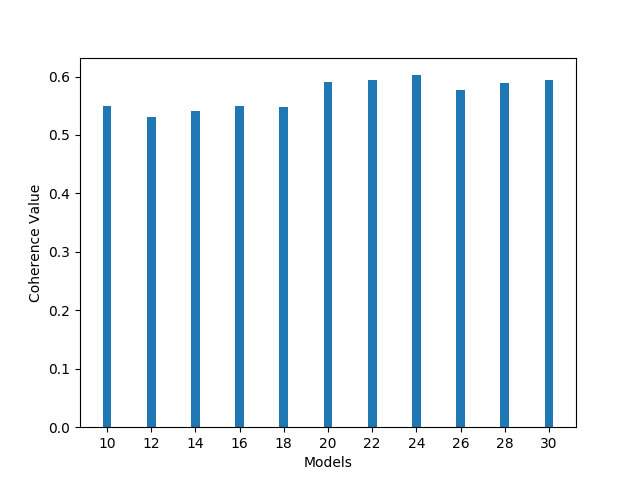

CPU times: user 16min 26s, sys: 7.52 s, total: 16min 34s
Wall time: 1h 58min 2s


In [12]:
%%time

topic_model_path = 'data/eos/lda/*_LDAmodel_EOS.pkl'
# topic_model_path = 'data/eos/lda/*_LSImodel_EOS.pkl'
# topic_model_path = 'data/eos/lda/*_Malletmodel_EOS.pkl'
execute_eval(topic_model_path)

# Evaluate topic LSA Mallet models

In [10]:
def mallet_lda_build(num_topics, dictionary, corpus, mallet_model_path):
    mallet_bin = '/home/sonic/sonic/mallet-2.0.8/bin/mallet'
    print ("start modeling LDA Mallet " + datetime.now().strftime("%H:%M:%S"))
    lda_mallet_model = gensim.models.wrappers.LdaMallet(mallet_bin, corpus=corpus, workers=7,
                                               num_topics=num_topics, id2word=dictionary)

    joblib.dump(lda_mallet_model, mallet_model_path)
    print ("finished modeling LDA Mallet, number of topics {}, ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
    return lda_mallet_model


In [11]:
def lsi_model_build(num_topics, dictionary, corpus, lsi_model_path):
    print ("start modeling lsi " + datetime.now().strftime("%H:%M:%S"))
    lsimodel = gensim.models.lsimodel.LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
    joblib.dump(lsimodel, lsi_model_path)
    #     lsimodel.show_topics(num_topics=10)  # Showing only the top 5 topics
    print ("finished modeling lsi, number of topics {}, ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
    return lsimodel


In [16]:
%%time 


def generate_mallet(limit):
    """
    Function to generate num_topics - LDA  
    
    Parameters:
    ----------
    limit : topic limit

    Range is incremented by 2
    """
    window_list = glob.glob('dynamic_nmf/data/windowbin/slices/text_total_windows_20*.gz')
    window_list.sort()
    
    for window_docs in window_list:
        window_docs = window_docs[-10: -3]
        # Load to memory
        corpus = gensim.corpora.MmCorpus(bow_filepath % window_docs)
        dictionary = gensim.corpora.Dictionary.load(dictionary_filepath % window_docs)
        for num_topics in range(10, limit + 2, 2):
            print("Starting num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
            mallet_model_path = 'data/eos/lda/%02d_%s_Malletmodel_EOS.pkl' % (num_topics, window_docs)
            mallet_lda_build(num_topics, dictionary, corpus, mallet_model_path)
            print("Finished topic modeing window {} ".format(window_docs) + datetime.now().strftime("%H:%M:%S"))

        
        
def generate_lsi(limit):
    """
    Perform TF-IDF ttransformation
    """
    window_list = glob.glob('dynamic_nmf/data/windowbin/slices/text_total_windows_20*.gz')
    window_list.sort()
    
    for window_docs in window_list:
        window_docs = window_docs[-10: -3]
        # Load to memory
        corpus = gensim.corpora.MmCorpus(bow_filepath % window_docs)
        tfidf = gensim.models.TfidfModel(corpus) 
        dictionary = gensim.corpora.Dictionary.load(dictionary_filepath % window_docs)
        tfidf_corpus = tfidf[corpus]
        for num_topics in range(10, limit + 2, 2):
            print("Starting num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
            print(dictionary_filepath % window_docs)
            print(bow_filepath % window_docs)
            lsi_model_path = 'data/eos/lda/%02d_%s_LSImodel_EOS.pkl' % (num_topics, window_docs)
            lsi_model_build(num_topics, dictionary, tfidf_corpus, lsi_model_path)
            print("Finished topic modeing window {} ".format(window_docs) + datetime.now().strftime("%H:%M:%S"))
        
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


In [24]:
%%time


generate_lsi(limit=30)

2017-07-09 11:40:20,630 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_01.mm.index
2017-07-09 11:40:20,631 : INFO : initializing corpus reader from data/eos/ngram/bigram_bow_corpus_2016_01.mm
2017-07-09 11:40:20,631 : INFO : accepted corpus with 38075 documents, 74855 features, 5159341 non-zero entries
2017-07-09 11:40:20,632 : INFO : collecting document frequencies
2017-07-09 11:40:20,633 : INFO : PROGRESS: processing document #0
2017-07-09 11:40:23,121 : INFO : PROGRESS: processing document #10000
2017-07-09 11:40:25,535 : INFO : PROGRESS: processing document #20000
2017-07-09 11:40:27,915 : INFO : PROGRESS: processing document #30000
2017-07-09 11:40:29,887 : INFO : calculating IDF weights for 38075 documents and 74854 features (5159341 matrix non-zeros)
2017-07-09 11:40:29,924 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_01.dict
2017-07-09 11:40:29,952 : INFO : loaded data/eos/ngram/bigram_dict_2016_01.dict
2017-07-09 11:40:29,958

Starting num topic 10 11:40:29
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:40:29


2017-07-09 11:40:36,562 : INFO : preparing a new chunk of documents
2017-07-09 11:40:36,930 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:40:36,931 : INFO : 1st phase: constructing (74855, 110) action matrix
2017-07-09 11:40:37,310 : INFO : orthonormalizing (74855, 110) action matrix
2017-07-09 11:40:42,162 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 11:40:42,598 : INFO : computing the final decomposition
2017-07-09 11:40:42,599 : INFO : keeping 10 factors (discarding 45.968% of energy spectrum)
2017-07-09 11:40:42,628 : INFO : processed documents up to #20000
2017-07-09 11:40:42,656 : INFO : topic #0(34.700): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"company" + 0.001*"service" + 0.001*"government" + 0.001*"market" + 0.001*"year" + 0.001*"please" + 0.001*"new"
2017-07-09 11:40:42,658 : INFO : topic #1(16.615): -0.137*"top" + -0.129*"go" + -0.108*"will" + -0.097*"year" + -0.085*"government" + -0.083*"market" + -0.083*"p

finished modeling lsi, number of topics 10, 11:40:55
Finished topic modeing window 2016_01 11:40:55
Starting num topic 12 11:40:55
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:40:55


2017-07-09 11:41:02,298 : INFO : preparing a new chunk of documents
2017-07-09 11:41:02,669 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:41:02,670 : INFO : 1st phase: constructing (74855, 112) action matrix
2017-07-09 11:41:03,050 : INFO : orthonormalizing (74855, 112) action matrix
2017-07-09 11:41:08,105 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 11:41:08,623 : INFO : computing the final decomposition
2017-07-09 11:41:08,624 : INFO : keeping 12 factors (discarding 43.913% of energy spectrum)
2017-07-09 11:41:08,655 : INFO : processed documents up to #20000
2017-07-09 11:41:08,660 : INFO : topic #0(34.700): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"company" + -0.001*"service" + -0.001*"government" + -0.001*"market" + -0.001*"year" + -0.001*"please" + -0.001*"new"
2017-07-09 11:41:08,664 : INFO : topic #1(16.615): 0.137*"top" + 0.129*"go" + 0.108*"will" + 0.097*"year" + 0.085*"government" + 0.083*"market" + 0.083

finished modeling lsi, number of topics 12, 11:41:21
Finished topic modeing window 2016_01 11:41:21
Starting num topic 14 11:41:21
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:41:21


2017-07-09 11:41:28,416 : INFO : preparing a new chunk of documents
2017-07-09 11:41:28,781 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:41:28,782 : INFO : 1st phase: constructing (74855, 114) action matrix
2017-07-09 11:41:29,166 : INFO : orthonormalizing (74855, 114) action matrix
2017-07-09 11:41:34,304 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 11:41:34,783 : INFO : computing the final decomposition
2017-07-09 11:41:34,784 : INFO : keeping 14 factors (discarding 42.008% of energy spectrum)
2017-07-09 11:41:34,816 : INFO : processed documents up to #20000
2017-07-09 11:41:34,821 : INFO : topic #0(34.700): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"company" + 0.001*"service" + 0.001*"government" + 0.001*"market" + 0.001*"year" + 0.001*"please" + 0.001*"new"
2017-07-09 11:41:34,824 : INFO : topic #1(16.615): -0.137*"top" + -0.129*"go" + -0.108*"will" + -0.097*"year" + -0.084*"government" + -0.083*"market" + -0.083*"p

finished modeling lsi, number of topics 14, 11:41:48
Finished topic modeing window 2016_01 11:41:48
Starting num topic 16 11:41:48
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:41:48


2017-07-09 11:41:54,727 : INFO : preparing a new chunk of documents
2017-07-09 11:41:55,091 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:41:55,091 : INFO : 1st phase: constructing (74855, 116) action matrix
2017-07-09 11:41:55,489 : INFO : orthonormalizing (74855, 116) action matrix
2017-07-09 11:42:00,740 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 11:42:01,208 : INFO : computing the final decomposition
2017-07-09 11:42:01,209 : INFO : keeping 16 factors (discarding 40.500% of energy spectrum)
2017-07-09 11:42:01,245 : INFO : processed documents up to #20000
2017-07-09 11:42:01,247 : INFO : topic #0(34.700): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"company" + -0.001*"service" + -0.001*"government" + -0.001*"market" + -0.001*"year" + -0.001*"please" + -0.001*"new"
2017-07-09 11:42:01,249 : INFO : topic #1(16.615): -0.137*"top" + -0.129*"go" + -0.108*"will" + -0.097*"year" + -0.085*"government" + -0.083*"market" +

finished modeling lsi, number of topics 16, 11:42:14
Finished topic modeing window 2016_01 11:42:14
Starting num topic 18 11:42:14
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:42:14


2017-07-09 11:42:21,746 : INFO : preparing a new chunk of documents
2017-07-09 11:42:22,126 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:42:22,127 : INFO : 1st phase: constructing (74855, 118) action matrix
2017-07-09 11:42:22,556 : INFO : orthonormalizing (74855, 118) action matrix
2017-07-09 11:42:27,901 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 11:42:28,399 : INFO : computing the final decomposition
2017-07-09 11:42:28,400 : INFO : keeping 18 factors (discarding 38.963% of energy spectrum)
2017-07-09 11:42:28,437 : INFO : processed documents up to #20000
2017-07-09 11:42:28,440 : INFO : topic #0(34.700): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"company" + -0.001*"service" + -0.001*"government" + -0.001*"market" + -0.001*"year" + -0.001*"please" + -0.001*"new"
2017-07-09 11:42:28,442 : INFO : topic #1(16.615): -0.137*"top" + -0.129*"go" + -0.108*"will" + -0.097*"year" + -0.084*"government" + -0.083*"market" +

finished modeling lsi, number of topics 18, 11:42:41
Finished topic modeing window 2016_01 11:42:41
Starting num topic 20 11:42:41
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:42:41


2017-07-09 11:42:48,627 : INFO : preparing a new chunk of documents
2017-07-09 11:42:49,017 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:42:49,017 : INFO : 1st phase: constructing (74855, 120) action matrix
2017-07-09 11:42:49,442 : INFO : orthonormalizing (74855, 120) action matrix
2017-07-09 11:42:54,977 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 11:42:55,498 : INFO : computing the final decomposition
2017-07-09 11:42:55,499 : INFO : keeping 20 factors (discarding 37.597% of energy spectrum)
2017-07-09 11:42:55,538 : INFO : processed documents up to #20000
2017-07-09 11:42:55,541 : INFO : topic #0(34.700): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"company" + -0.001*"service" + -0.001*"government" + -0.001*"market" + -0.001*"year" + -0.001*"please" + -0.001*"new"
2017-07-09 11:42:55,543 : INFO : topic #1(16.615): 0.137*"top" + 0.129*"go" + 0.108*"will" + 0.097*"year" + 0.085*"government" + 0.083*"market" + 0.083

finished modeling lsi, number of topics 20, 11:43:09
Finished topic modeing window 2016_01 11:43:09
Starting num topic 22 11:43:09
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:43:09


2017-07-09 11:43:16,245 : INFO : preparing a new chunk of documents
2017-07-09 11:43:16,614 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:43:16,615 : INFO : 1st phase: constructing (74855, 122) action matrix
2017-07-09 11:43:17,021 : INFO : orthonormalizing (74855, 122) action matrix
2017-07-09 11:43:23,012 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 11:43:23,526 : INFO : computing the final decomposition
2017-07-09 11:43:23,528 : INFO : keeping 22 factors (discarding 36.390% of energy spectrum)
2017-07-09 11:43:23,571 : INFO : processed documents up to #20000
2017-07-09 11:43:23,573 : INFO : topic #0(34.700): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"company" + 0.001*"service" + 0.001*"government" + 0.001*"market" + 0.001*"year" + 0.001*"please" + 0.001*"new"
2017-07-09 11:43:23,575 : INFO : topic #1(16.615): 0.137*"top" + 0.129*"go" + 0.108*"will" + 0.097*"year" + 0.085*"government" + 0.083*"market" + 0.083*"police" 

finished modeling lsi, number of topics 22, 11:43:37
Finished topic modeing window 2016_01 11:43:37
Starting num topic 24 11:43:37
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:43:37


2017-07-09 11:43:44,568 : INFO : preparing a new chunk of documents
2017-07-09 11:43:44,929 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:43:44,930 : INFO : 1st phase: constructing (74855, 124) action matrix
2017-07-09 11:43:45,350 : INFO : orthonormalizing (74855, 124) action matrix
2017-07-09 11:43:51,739 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 11:43:52,270 : INFO : computing the final decomposition
2017-07-09 11:43:52,271 : INFO : keeping 24 factors (discarding 35.256% of energy spectrum)
2017-07-09 11:43:52,315 : INFO : processed documents up to #20000
2017-07-09 11:43:52,317 : INFO : topic #0(34.700): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"company" + 0.001*"service" + 0.001*"government" + 0.001*"market" + 0.001*"year" + 0.001*"please" + 0.001*"new"
2017-07-09 11:43:52,319 : INFO : topic #1(16.615): 0.137*"top" + 0.129*"go" + 0.108*"will" + 0.097*"year" + 0.084*"government" + 0.083*"market" + 0.083*"police" 

finished modeling lsi, number of topics 24, 11:44:07
Finished topic modeing window 2016_01 11:44:07
Starting num topic 26 11:44:07
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:44:07


2017-07-09 11:44:14,248 : INFO : preparing a new chunk of documents
2017-07-09 11:44:14,632 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:44:14,633 : INFO : 1st phase: constructing (74855, 126) action matrix
2017-07-09 11:44:15,108 : INFO : orthonormalizing (74855, 126) action matrix
2017-07-09 11:44:22,310 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 11:44:22,859 : INFO : computing the final decomposition
2017-07-09 11:44:22,860 : INFO : keeping 26 factors (discarding 34.265% of energy spectrum)
2017-07-09 11:44:22,905 : INFO : processed documents up to #20000
2017-07-09 11:44:22,908 : INFO : topic #0(34.700): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"company" + -0.001*"service" + -0.001*"government" + -0.001*"market" + -0.001*"year" + -0.001*"please" + -0.001*"new"
2017-07-09 11:44:22,910 : INFO : topic #1(16.615): 0.137*"top" + 0.129*"go" + 0.108*"will" + 0.097*"year" + 0.085*"government" + 0.083*"market" + 0.083

finished modeling lsi, number of topics 26, 11:44:38
Finished topic modeing window 2016_01 11:44:38
Starting num topic 28 11:44:38
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:44:38


2017-07-09 11:44:45,322 : INFO : preparing a new chunk of documents
2017-07-09 11:44:45,690 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:44:45,691 : INFO : 1st phase: constructing (74855, 128) action matrix
2017-07-09 11:44:46,129 : INFO : orthonormalizing (74855, 128) action matrix
2017-07-09 11:44:53,200 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 11:44:53,906 : INFO : computing the final decomposition
2017-07-09 11:44:53,907 : INFO : keeping 28 factors (discarding 33.417% of energy spectrum)
2017-07-09 11:44:53,952 : INFO : processed documents up to #20000
2017-07-09 11:44:53,954 : INFO : topic #0(34.700): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"company" + 0.001*"service" + 0.001*"government" + 0.001*"market" + 0.001*"year" + 0.001*"please" + 0.001*"new"
2017-07-09 11:44:53,956 : INFO : topic #1(16.615): -0.137*"top" + -0.129*"go" + -0.108*"will" + -0.097*"year" + -0.085*"government" + -0.083*"market" + -0.083*"p

finished modeling lsi, number of topics 28, 11:45:08
Finished topic modeing window 2016_01 11:45:08
Starting num topic 30 11:45:08
data/eos/ngram/bigram_dict_2016_01.dict
data/eos/ngram/bigram_bow_corpus_2016_01.mm
start modeling lsi 11:45:08


2017-07-09 11:45:15,572 : INFO : preparing a new chunk of documents
2017-07-09 11:45:15,937 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:45:15,937 : INFO : 1st phase: constructing (74855, 130) action matrix
2017-07-09 11:45:16,360 : INFO : orthonormalizing (74855, 130) action matrix
2017-07-09 11:45:21,526 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 11:45:22,194 : INFO : computing the final decomposition
2017-07-09 11:45:22,195 : INFO : keeping 30 factors (discarding 32.531% of energy spectrum)
2017-07-09 11:45:22,245 : INFO : processed documents up to #20000
2017-07-09 11:45:22,247 : INFO : topic #0(34.700): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"company" + -0.001*"service" + -0.001*"government" + -0.001*"market" + -0.001*"year" + -0.001*"please" + -0.001*"new"
2017-07-09 11:45:22,249 : INFO : topic #1(16.615): 0.137*"top" + 0.129*"go" + 0.108*"will" + 0.097*"year" + 0.085*"government" + 0.083*"market" + 0.083

finished modeling lsi, number of topics 30, 11:45:37
Finished topic modeing window 2016_01 11:45:37


2017-07-09 11:45:39,964 : INFO : PROGRESS: processing document #10000
2017-07-09 11:45:42,416 : INFO : PROGRESS: processing document #20000
2017-07-09 11:45:44,856 : INFO : PROGRESS: processing document #30000
2017-07-09 11:45:47,387 : INFO : PROGRESS: processing document #40000
2017-07-09 11:45:49,759 : INFO : PROGRESS: processing document #50000
2017-07-09 11:45:50,454 : INFO : calculating IDF weights for 52722 documents and 95660 features (7251527 matrix non-zeros)
2017-07-09 11:45:50,504 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_02.dict
2017-07-09 11:45:50,535 : INFO : loaded data/eos/ngram/bigram_dict_2016_02.dict
2017-07-09 11:45:50,550 : INFO : using serial LSI version on this node
2017-07-09 11:45:50,551 : INFO : updating model with new documents


Starting num topic 10 11:45:50
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:45:50


2017-07-09 11:45:57,481 : INFO : preparing a new chunk of documents
2017-07-09 11:45:57,871 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:45:57,872 : INFO : 1st phase: constructing (95661, 110) action matrix
2017-07-09 11:45:58,297 : INFO : orthonormalizing (95661, 110) action matrix
2017-07-09 11:46:05,019 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 11:46:05,684 : INFO : computing the final decomposition
2017-07-09 11:46:05,685 : INFO : keeping 10 factors (discarding 45.294% of energy spectrum)
2017-07-09 11:46:05,719 : INFO : processed documents up to #20000
2017-07-09 11:46:05,741 : INFO : topic #0(35.694): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"health" + 0.001*"service" + 0.001*"year" + 0.001*"support" + 0.001*"country"
2017-07-09 11:46:05,744 : INFO : topic #1(16.189): 0.109*"will" + 0.098*"year" + 0.097*"share" + 0.091*"government" + 0.086*"article" + 0.082*"people" + 0.0

finished modeling lsi, number of topics 10, 11:46:33
Finished topic modeing window 2016_02 11:46:33
Starting num topic 12 11:46:33
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:46:33


2017-07-09 11:46:40,160 : INFO : preparing a new chunk of documents
2017-07-09 11:46:40,536 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:46:40,536 : INFO : 1st phase: constructing (95661, 112) action matrix
2017-07-09 11:46:40,936 : INFO : orthonormalizing (95661, 112) action matrix
2017-07-09 11:46:47,716 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 11:46:48,303 : INFO : computing the final decomposition
2017-07-09 11:46:48,304 : INFO : keeping 12 factors (discarding 42.997% of energy spectrum)
2017-07-09 11:46:48,340 : INFO : processed documents up to #20000
2017-07-09 11:46:48,342 : INFO : topic #0(35.694): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"comment" + -0.001*"company" + -0.001*"health" + -0.001*"service" + -0.001*"year" + -0.001*"support" + -0.001*"country"
2017-07-09 11:46:48,345 : INFO : topic #1(16.189): -0.109*"will" + -0.098*"year" + -0.097*"share" + -0.091*"government" + -0.086*"article" + -0.08

finished modeling lsi, number of topics 12, 11:47:17
Finished topic modeing window 2016_02 11:47:17
Starting num topic 14 11:47:17
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:47:17


2017-07-09 11:47:24,878 : INFO : preparing a new chunk of documents
2017-07-09 11:47:25,260 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:47:25,261 : INFO : 1st phase: constructing (95661, 114) action matrix
2017-07-09 11:47:25,681 : INFO : orthonormalizing (95661, 114) action matrix
2017-07-09 11:47:32,489 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 11:47:33,077 : INFO : computing the final decomposition
2017-07-09 11:47:33,078 : INFO : keeping 14 factors (discarding 41.090% of energy spectrum)
2017-07-09 11:47:33,117 : INFO : processed documents up to #20000
2017-07-09 11:47:33,119 : INFO : topic #0(35.694): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"health" + 0.001*"service" + 0.001*"year" + 0.001*"support" + 0.001*"country"
2017-07-09 11:47:33,122 : INFO : topic #1(16.189): 0.109*"will" + 0.098*"year" + 0.097*"share" + 0.091*"government" + 0.086*"article" + 0.082*"people" + 0.0

finished modeling lsi, number of topics 14, 11:48:01
Finished topic modeing window 2016_02 11:48:01
Starting num topic 16 11:48:01
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:48:01


2017-07-09 11:48:08,882 : INFO : preparing a new chunk of documents
2017-07-09 11:48:09,261 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:48:09,262 : INFO : 1st phase: constructing (95661, 116) action matrix
2017-07-09 11:48:09,684 : INFO : orthonormalizing (95661, 116) action matrix
2017-07-09 11:48:16,683 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 11:48:17,276 : INFO : computing the final decomposition
2017-07-09 11:48:17,279 : INFO : keeping 16 factors (discarding 39.492% of energy spectrum)
2017-07-09 11:48:17,321 : INFO : processed documents up to #20000
2017-07-09 11:48:17,323 : INFO : topic #0(35.694): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"health" + 0.001*"service" + 0.001*"year" + 0.001*"support" + 0.001*"country"
2017-07-09 11:48:17,326 : INFO : topic #1(16.189): 0.109*"will" + 0.098*"year" + 0.097*"share" + 0.091*"government" + 0.086*"article" + 0.082*"people" + 0.0

finished modeling lsi, number of topics 16, 11:48:46
Finished topic modeing window 2016_02 11:48:46
Starting num topic 18 11:48:46
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:48:46


2017-07-09 11:48:53,142 : INFO : preparing a new chunk of documents
2017-07-09 11:48:53,519 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:48:53,519 : INFO : 1st phase: constructing (95661, 118) action matrix
2017-07-09 11:48:53,941 : INFO : orthonormalizing (95661, 118) action matrix
2017-07-09 11:49:01,160 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 11:49:01,768 : INFO : computing the final decomposition
2017-07-09 11:49:01,769 : INFO : keeping 18 factors (discarding 38.046% of energy spectrum)
2017-07-09 11:49:01,812 : INFO : processed documents up to #20000
2017-07-09 11:49:01,815 : INFO : topic #0(35.694): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"health" + 0.001*"service" + 0.001*"year" + 0.001*"support" + 0.001*"country"
2017-07-09 11:49:01,817 : INFO : topic #1(16.189): 0.109*"will" + 0.098*"year" + 0.097*"share" + 0.091*"government" + 0.086*"article" + 0.082*"people" + 0.0

finished modeling lsi, number of topics 18, 11:49:31
Finished topic modeing window 2016_02 11:49:31
Starting num topic 20 11:49:31
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:49:31


2017-07-09 11:49:38,301 : INFO : preparing a new chunk of documents
2017-07-09 11:49:38,678 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:49:38,679 : INFO : 1st phase: constructing (95661, 120) action matrix
2017-07-09 11:49:39,104 : INFO : orthonormalizing (95661, 120) action matrix
2017-07-09 11:49:46,549 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 11:49:47,183 : INFO : computing the final decomposition
2017-07-09 11:49:47,184 : INFO : keeping 20 factors (discarding 36.586% of energy spectrum)
2017-07-09 11:49:47,229 : INFO : processed documents up to #20000
2017-07-09 11:49:47,232 : INFO : topic #0(35.694): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"comment" + -0.001*"company" + -0.001*"health" + -0.001*"service" + -0.001*"year" + -0.001*"support" + -0.001*"country"
2017-07-09 11:49:47,235 : INFO : topic #1(16.189): -0.109*"will" + -0.098*"year" + -0.097*"share" + -0.091*"government" + -0.086*"article" + -0.08

finished modeling lsi, number of topics 20, 11:50:17
Finished topic modeing window 2016_02 11:50:17
Starting num topic 22 11:50:17
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:50:17


2017-07-09 11:50:24,434 : INFO : preparing a new chunk of documents
2017-07-09 11:50:24,817 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:50:24,818 : INFO : 1st phase: constructing (95661, 122) action matrix
2017-07-09 11:50:25,253 : INFO : orthonormalizing (95661, 122) action matrix
2017-07-09 11:50:33,035 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 11:50:33,674 : INFO : computing the final decomposition
2017-07-09 11:50:33,675 : INFO : keeping 22 factors (discarding 35.357% of energy spectrum)
2017-07-09 11:50:33,722 : INFO : processed documents up to #20000
2017-07-09 11:50:33,725 : INFO : topic #0(35.694): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"health" + 0.001*"service" + 0.001*"year" + 0.001*"support" + 0.001*"country"
2017-07-09 11:50:33,728 : INFO : topic #1(16.189): -0.109*"will" + -0.098*"year" + -0.097*"share" + -0.091*"government" + -0.086*"article" + -0.082*"people"

finished modeling lsi, number of topics 22, 11:51:04
Finished topic modeing window 2016_02 11:51:04
Starting num topic 24 11:51:04
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:51:04


2017-07-09 11:51:11,354 : INFO : preparing a new chunk of documents
2017-07-09 11:51:11,731 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:51:11,731 : INFO : 1st phase: constructing (95661, 124) action matrix
2017-07-09 11:51:12,174 : INFO : orthonormalizing (95661, 124) action matrix
2017-07-09 11:51:20,023 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 11:51:20,687 : INFO : computing the final decomposition
2017-07-09 11:51:20,688 : INFO : keeping 24 factors (discarding 34.309% of energy spectrum)
2017-07-09 11:51:20,736 : INFO : processed documents up to #20000
2017-07-09 11:51:20,739 : INFO : topic #0(35.694): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"health" + 0.001*"service" + 0.001*"year" + 0.001*"support" + 0.001*"country"
2017-07-09 11:51:20,742 : INFO : topic #1(16.189): -0.109*"will" + -0.098*"year" + -0.097*"share" + -0.091*"government" + -0.086*"article" + -0.082*"people"

finished modeling lsi, number of topics 24, 11:51:52
Finished topic modeing window 2016_02 11:51:52
Starting num topic 26 11:51:52
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:51:52


2017-07-09 11:51:59,050 : INFO : preparing a new chunk of documents
2017-07-09 11:51:59,429 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:51:59,429 : INFO : 1st phase: constructing (95661, 126) action matrix
2017-07-09 11:51:59,888 : INFO : orthonormalizing (95661, 126) action matrix
2017-07-09 11:52:08,065 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 11:52:08,778 : INFO : computing the final decomposition
2017-07-09 11:52:08,779 : INFO : keeping 26 factors (discarding 33.382% of energy spectrum)
2017-07-09 11:52:08,830 : INFO : processed documents up to #20000
2017-07-09 11:52:08,833 : INFO : topic #0(35.694): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"health" + 0.001*"service" + 0.001*"year" + 0.001*"support" + 0.001*"country"
2017-07-09 11:52:08,836 : INFO : topic #1(16.189): 0.109*"will" + 0.098*"year" + 0.097*"share" + 0.091*"government" + 0.086*"article" + 0.082*"people" + 0.0

finished modeling lsi, number of topics 26, 11:52:40
Finished topic modeing window 2016_02 11:52:40
Starting num topic 28 11:52:40
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:52:40


2017-07-09 11:52:47,255 : INFO : preparing a new chunk of documents
2017-07-09 11:52:47,632 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:52:47,633 : INFO : 1st phase: constructing (95661, 128) action matrix
2017-07-09 11:52:48,085 : INFO : orthonormalizing (95661, 128) action matrix
2017-07-09 11:52:56,464 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 11:52:57,278 : INFO : computing the final decomposition
2017-07-09 11:52:57,279 : INFO : keeping 28 factors (discarding 32.484% of energy spectrum)
2017-07-09 11:52:57,331 : INFO : processed documents up to #20000
2017-07-09 11:52:57,334 : INFO : topic #0(35.694): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"health" + 0.001*"service" + 0.001*"year" + 0.001*"support" + 0.001*"country"
2017-07-09 11:52:57,337 : INFO : topic #1(16.189): 0.109*"will" + 0.098*"year" + 0.097*"share" + 0.091*"government" + 0.086*"article" + 0.082*"people" + 0.0

finished modeling lsi, number of topics 28, 11:53:30
Finished topic modeing window 2016_02 11:53:30
Starting num topic 30 11:53:30
data/eos/ngram/bigram_dict_2016_02.dict
data/eos/ngram/bigram_bow_corpus_2016_02.mm
start modeling lsi 11:53:30


2017-07-09 11:53:36,982 : INFO : preparing a new chunk of documents
2017-07-09 11:53:37,356 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:53:37,356 : INFO : 1st phase: constructing (95661, 130) action matrix
2017-07-09 11:53:37,816 : INFO : orthonormalizing (95661, 130) action matrix
2017-07-09 11:53:44,139 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 11:53:44,631 : INFO : computing the final decomposition
2017-07-09 11:53:44,634 : INFO : keeping 30 factors (discarding 31.657% of energy spectrum)
2017-07-09 11:53:44,692 : INFO : processed documents up to #20000
2017-07-09 11:53:44,695 : INFO : topic #0(35.694): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"comment" + -0.001*"company" + -0.001*"health" + -0.001*"service" + -0.001*"year" + -0.001*"support" + -0.001*"country"
2017-07-09 11:53:44,698 : INFO : topic #1(16.189): 0.109*"will" + 0.098*"year" + 0.097*"share" + 0.091*"government" + 0.086*"article" + 0.082*"peo

finished modeling lsi, number of topics 30, 11:54:12
Finished topic modeing window 2016_02 11:54:12


2017-07-09 11:54:15,140 : INFO : PROGRESS: processing document #10000
2017-07-09 11:54:17,573 : INFO : PROGRESS: processing document #20000
2017-07-09 11:54:20,043 : INFO : PROGRESS: processing document #30000
2017-07-09 11:54:22,511 : INFO : PROGRESS: processing document #40000
2017-07-09 11:54:24,934 : INFO : PROGRESS: processing document #50000
2017-07-09 11:54:27,377 : INFO : PROGRESS: processing document #60000
2017-07-09 11:54:29,864 : INFO : PROGRESS: processing document #70000
2017-07-09 11:54:32,344 : INFO : PROGRESS: processing document #80000
2017-07-09 11:54:33,317 : INFO : calculating IDF weights for 83388 documents and 99999 features (11186329 matrix non-zeros)
2017-07-09 11:54:33,374 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_03.dict
2017-07-09 11:54:33,408 : INFO : loaded data/eos/ngram/bigram_dict_2016_03.dict
2017-07-09 11:54:33,433 : INFO : using serial LSI version on this node
2017-07-09 11:54:33,434 : INFO : updating model with new docu

Starting num topic 10 11:54:33
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 11:54:33


2017-07-09 11:54:40,231 : INFO : preparing a new chunk of documents
2017-07-09 11:54:40,603 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:54:40,604 : INFO : 1st phase: constructing (100000, 110) action matrix
2017-07-09 11:54:41,006 : INFO : orthonormalizing (100000, 110) action matrix
2017-07-09 11:54:47,700 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 11:54:48,316 : INFO : computing the final decomposition
2017-07-09 11:54:48,317 : INFO : keeping 10 factors (discarding 43.987% of energy spectrum)
2017-07-09 11:54:48,352 : INFO : processed documents up to #20000
2017-07-09 11:54:48,381 : INFO : topic #0(37.108): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"please" + 0.001*"health" + 0.001*"year" + 0.001*"new"
2017-07-09 11:54:48,383 : INFO : topic #1(15.851): -0.153*"top" + -0.137*"go" + -0.110*"will" + -0.095*"year" + -0.092*"government" + -0.079*"police" + -0.075*

2017-07-09 11:55:40,356 : INFO : topic #1(32.673): 0.208*"top" + 0.175*"go" + 0.104*"will" + 0.090*"year" + 0.089*"government" + 0.088*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 11:55:40,358 : INFO : topic #2(28.706): -0.819*"top" + -0.505*"go" + 0.028*"will" + 0.028*"police" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.021*"state"
2017-07-09 11:55:40,360 : INFO : topic #3(18.658): -0.494*"photos" + -0.307*"turkey" + -0.307*"istanbul" + -0.273*"photo" + -0.260*"turkish" + -0.138*"amid" + -0.135*"curfew" + -0.129*"attack" + -0.106*"police" + -0.098*"destruction"
2017-07-09 11:55:40,362 : INFO : topic #4(18.211): -0.602*"ist" + -0.501*"modify" + -0.275*"pm" + -0.182*"mar" + -0.173*"2016" + -0.173*"modified" + -0.166*"last" + -0.146*"01" + -0.139*"tue_mar" + -0.139*"fri_mar"
2017-07-09 11:55:41,664 : INFO : using serial LSI version on this node
2017-07-09 11:55:41,665 : INFO : updating model with new do

finished modeling lsi, number of topics 10, 11:55:41
Finished topic modeing window 2016_03 11:55:41
Starting num topic 12 11:55:41
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 11:55:41


2017-07-09 11:55:48,382 : INFO : preparing a new chunk of documents
2017-07-09 11:55:48,750 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:55:48,751 : INFO : 1st phase: constructing (100000, 112) action matrix
2017-07-09 11:55:49,151 : INFO : orthonormalizing (100000, 112) action matrix
2017-07-09 11:55:56,076 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 11:55:56,617 : INFO : computing the final decomposition
2017-07-09 11:55:56,618 : INFO : keeping 12 factors (discarding 41.841% of energy spectrum)
2017-07-09 11:55:56,660 : INFO : processed documents up to #20000
2017-07-09 11:55:56,664 : INFO : topic #0(37.108): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"please" + 0.001*"health" + 0.001*"year" + 0.001*"new"
2017-07-09 11:55:56,666 : INFO : topic #1(15.851): -0.153*"top" + -0.137*"go" + -0.110*"will" + -0.095*"year" + -0.092*"government" + -0.079*"police" + -0.075*

2017-07-09 11:56:49,806 : INFO : topic #1(32.675): 0.208*"top" + 0.175*"go" + 0.104*"will" + 0.090*"year" + 0.089*"government" + 0.088*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 11:56:49,808 : INFO : topic #2(28.706): -0.819*"top" + -0.505*"go" + 0.028*"will" + 0.028*"police" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.020*"state"
2017-07-09 11:56:49,811 : INFO : topic #3(18.673): -0.488*"photos" + -0.305*"turkey" + -0.304*"istanbul" + -0.270*"photo" + -0.258*"turkish" + -0.136*"amid" + -0.133*"curfew" + -0.133*"attack" + -0.111*"police" + -0.097*"destruction"
2017-07-09 11:56:49,813 : INFO : topic #4(18.212): -0.602*"ist" + -0.501*"modify" + -0.275*"pm" + -0.182*"mar" + -0.173*"2016" + -0.173*"modified" + -0.166*"last" + -0.146*"01" + -0.139*"fri_mar" + -0.138*"tue_mar"
2017-07-09 11:56:51,121 : INFO : using serial LSI version on this node
2017-07-09 11:56:51,121 : INFO : updating model with new do

finished modeling lsi, number of topics 12, 11:56:51
Finished topic modeing window 2016_03 11:56:51
Starting num topic 14 11:56:51
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 11:56:51


2017-07-09 11:56:57,944 : INFO : preparing a new chunk of documents
2017-07-09 11:56:58,313 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:56:58,314 : INFO : 1st phase: constructing (100000, 114) action matrix
2017-07-09 11:56:58,719 : INFO : orthonormalizing (100000, 114) action matrix
2017-07-09 11:57:05,767 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 11:57:06,310 : INFO : computing the final decomposition
2017-07-09 11:57:06,311 : INFO : keeping 14 factors (discarding 39.906% of energy spectrum)
2017-07-09 11:57:06,357 : INFO : processed documents up to #20000
2017-07-09 11:57:06,359 : INFO : topic #0(37.108): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"please" + -0.001*"health" + -0.001*"year" + -0.001*"new"
2017-07-09 11:57:06,361 : INFO : topic #1(15.851): -0.153*"top" + -0.137*"go" + -0.110*"will" + -0.095*"year" + -0.092*"government" + -0.079*"police"

2017-07-09 11:58:00,468 : INFO : topic #1(32.675): 0.208*"top" + 0.175*"go" + 0.104*"will" + 0.090*"year" + 0.089*"government" + 0.088*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 11:58:00,470 : INFO : topic #2(28.706): -0.819*"top" + -0.505*"go" + 0.028*"police" + 0.028*"will" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.020*"state"
2017-07-09 11:58:00,472 : INFO : topic #3(18.826): -0.491*"photos" + -0.305*"turkey" + -0.305*"istanbul" + -0.272*"photo" + -0.259*"turkish" + -0.137*"amid" + -0.134*"curfew" + -0.131*"attack" + -0.114*"police" + -0.097*"destruction"
2017-07-09 11:58:00,475 : INFO : topic #4(18.214): -0.603*"ist" + -0.502*"modify" + -0.276*"pm" + -0.182*"mar" + -0.174*"2016" + -0.173*"modified" + -0.166*"last" + -0.146*"01" + -0.139*"fri_mar" + -0.139*"tue_mar"
2017-07-09 11:58:01,805 : INFO : using serial LSI version on this node
2017-07-09 11:58:01,806 : INFO : updating model with new do

finished modeling lsi, number of topics 14, 11:58:01
Finished topic modeing window 2016_03 11:58:01
Starting num topic 16 11:58:01
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 11:58:01


2017-07-09 11:58:08,632 : INFO : preparing a new chunk of documents
2017-07-09 11:58:09,001 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:58:09,002 : INFO : 1st phase: constructing (100000, 116) action matrix
2017-07-09 11:58:09,408 : INFO : orthonormalizing (100000, 116) action matrix
2017-07-09 11:58:16,482 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 11:58:17,015 : INFO : computing the final decomposition
2017-07-09 11:58:17,019 : INFO : keeping 16 factors (discarding 38.230% of energy spectrum)
2017-07-09 11:58:17,068 : INFO : processed documents up to #20000
2017-07-09 11:58:17,070 : INFO : topic #0(37.108): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"please" + 0.001*"health" + 0.001*"year" + 0.001*"new"
2017-07-09 11:58:17,072 : INFO : topic #1(15.851): -0.153*"top" + -0.137*"go" + -0.110*"will" + -0.095*"year" + -0.092*"government" + -0.079*"police" + -0.075*

2017-07-09 11:59:11,770 : INFO : topic #1(32.677): 0.208*"top" + 0.174*"go" + 0.104*"will" + 0.090*"year" + 0.089*"government" + 0.088*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 11:59:11,772 : INFO : topic #2(28.706): -0.819*"top" + -0.505*"go" + 0.028*"police" + 0.028*"will" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.020*"state"
2017-07-09 11:59:11,774 : INFO : topic #3(18.848): -0.492*"photos" + -0.305*"istanbul" + -0.305*"turkey" + -0.273*"photo" + -0.259*"turkish" + -0.137*"amid" + -0.134*"curfew" + -0.128*"attack" + -0.115*"police" + -0.097*"destruction"
2017-07-09 11:59:11,776 : INFO : topic #4(18.215): -0.603*"ist" + -0.502*"modify" + -0.276*"pm" + -0.182*"mar" + -0.173*"2016" + -0.173*"modified" + -0.166*"last" + -0.146*"01" + -0.139*"tue_mar" + -0.139*"fri_mar"
2017-07-09 11:59:13,063 : INFO : using serial LSI version on this node
2017-07-09 11:59:13,063 : INFO : updating model with new do

finished modeling lsi, number of topics 16, 11:59:13
Finished topic modeing window 2016_03 11:59:13
Starting num topic 18 11:59:13
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 11:59:13


2017-07-09 11:59:19,865 : INFO : preparing a new chunk of documents
2017-07-09 11:59:20,239 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 11:59:20,240 : INFO : 1st phase: constructing (100000, 118) action matrix
2017-07-09 11:59:20,662 : INFO : orthonormalizing (100000, 118) action matrix
2017-07-09 11:59:28,082 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 11:59:28,656 : INFO : computing the final decomposition
2017-07-09 11:59:28,657 : INFO : keeping 18 factors (discarding 36.868% of energy spectrum)
2017-07-09 11:59:28,707 : INFO : processed documents up to #20000
2017-07-09 11:59:28,709 : INFO : topic #0(37.108): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"please" + -0.001*"health" + -0.001*"year" + -0.001*"new"
2017-07-09 11:59:28,711 : INFO : topic #1(15.851): 0.153*"top" + 0.137*"go" + 0.110*"will" + 0.095*"year" + 0.092*"government" + 0.079*"police" + 0.0

2017-07-09 12:00:24,374 : INFO : topic #1(32.678): 0.208*"top" + 0.174*"go" + 0.104*"will" + 0.089*"year" + 0.089*"government" + 0.089*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 12:00:24,376 : INFO : topic #2(28.706): -0.819*"top" + -0.505*"go" + 0.028*"police" + 0.028*"will" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.021*"state"
2017-07-09 12:00:24,378 : INFO : topic #3(18.854): -0.492*"photos" + -0.305*"istanbul" + -0.305*"turkey" + -0.273*"photo" + -0.259*"turkish" + -0.137*"amid" + -0.134*"curfew" + -0.129*"attack" + -0.117*"police" + -0.097*"destruction"
2017-07-09 12:00:24,380 : INFO : topic #4(18.217): -0.603*"ist" + -0.502*"modify" + -0.276*"pm" + -0.182*"mar" + -0.173*"2016" + -0.173*"modified" + -0.166*"last" + -0.146*"01" + -0.139*"fri_mar" + -0.139*"tue_mar"
2017-07-09 12:00:25,715 : INFO : using serial LSI version on this node
2017-07-09 12:00:25,715 : INFO : updating model with new do

finished modeling lsi, number of topics 18, 12:00:25
Finished topic modeing window 2016_03 12:00:25
Starting num topic 20 12:00:25
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 12:00:25


2017-07-09 12:00:32,511 : INFO : preparing a new chunk of documents
2017-07-09 12:00:32,878 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:00:32,878 : INFO : 1st phase: constructing (100000, 120) action matrix
2017-07-09 12:00:33,305 : INFO : orthonormalizing (100000, 120) action matrix
2017-07-09 12:00:40,989 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 12:00:41,586 : INFO : computing the final decomposition
2017-07-09 12:00:41,587 : INFO : keeping 20 factors (discarding 35.633% of energy spectrum)
2017-07-09 12:00:41,639 : INFO : processed documents up to #20000
2017-07-09 12:00:41,641 : INFO : topic #0(37.108): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"please" + -0.001*"health" + -0.001*"year" + -0.001*"new"
2017-07-09 12:00:41,643 : INFO : topic #1(15.851): -0.153*"top" + -0.137*"go" + -0.110*"will" + -0.095*"year" + -0.092*"government" + -0.079*"police"

2017-07-09 12:01:38,535 : INFO : topic #0(75.313): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"please" + 0.001*"health" + 0.001*"project" + 0.001*"year"
2017-07-09 12:01:38,537 : INFO : topic #1(32.679): 0.208*"top" + 0.174*"go" + 0.104*"will" + 0.089*"year" + 0.089*"government" + 0.089*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 12:01:38,539 : INFO : topic #2(28.706): -0.819*"top" + -0.505*"go" + 0.028*"police" + 0.028*"will" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.021*"state"
2017-07-09 12:01:38,542 : INFO : topic #3(18.860): -0.492*"photos" + -0.305*"istanbul" + -0.304*"turkey" + -0.273*"photo" + -0.259*"turkish" + -0.138*"amid" + -0.134*"curfew" + -0.128*"attack" + -0.118*"police" + -0.097*"destruction"
2017-07-09 12:01:38,544 : INFO : topic #4(18.217): -0.603*"ist" + -0.502*"modify" + -0.276*"pm" + -0.181*"mar" + -0.173*"

finished modeling lsi, number of topics 20, 12:01:39
Finished topic modeing window 2016_03 12:01:39
Starting num topic 22 12:01:39
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 12:01:39


2017-07-09 12:01:46,641 : INFO : preparing a new chunk of documents
2017-07-09 12:01:47,041 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:01:47,042 : INFO : 1st phase: constructing (100000, 122) action matrix
2017-07-09 12:01:47,466 : INFO : orthonormalizing (100000, 122) action matrix
2017-07-09 12:01:55,350 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 12:01:55,969 : INFO : computing the final decomposition
2017-07-09 12:01:55,971 : INFO : keeping 22 factors (discarding 34.548% of energy spectrum)
2017-07-09 12:01:56,030 : INFO : processed documents up to #20000
2017-07-09 12:01:56,033 : INFO : topic #0(37.108): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"please" + -0.001*"health" + -0.001*"year" + -0.001*"new"
2017-07-09 12:01:56,035 : INFO : topic #1(15.851): 0.153*"top" + 0.137*"go" + 0.110*"will" + 0.095*"year" + 0.092*"government" + 0.079*"police" + 0.0

2017-07-09 12:02:54,337 : INFO : topic #1(32.679): 0.208*"top" + 0.174*"go" + 0.104*"will" + 0.089*"year" + 0.089*"government" + 0.089*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 12:02:54,341 : INFO : topic #2(28.707): -0.819*"top" + -0.505*"go" + 0.028*"police" + 0.028*"will" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.020*"state"
2017-07-09 12:02:54,343 : INFO : topic #3(18.867): -0.493*"photos" + -0.305*"istanbul" + -0.303*"turkey" + -0.273*"photo" + -0.258*"turkish" + -0.138*"amid" + -0.134*"curfew" + -0.127*"attack" + -0.118*"police" + -0.098*"destruction"
2017-07-09 12:02:54,346 : INFO : topic #4(18.218): -0.603*"ist" + -0.502*"modify" + -0.276*"pm" + -0.182*"mar" + -0.173*"modified" + -0.173*"2016" + -0.166*"last" + -0.146*"01" + -0.139*"tue_mar" + -0.139*"fri_mar"
2017-07-09 12:02:55,633 : INFO : using serial LSI version on this node
2017-07-09 12:02:55,634 : INFO : updating model with new do

finished modeling lsi, number of topics 22, 12:02:55
Finished topic modeing window 2016_03 12:02:55
Starting num topic 24 12:02:55
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 12:02:55


2017-07-09 12:03:02,384 : INFO : preparing a new chunk of documents
2017-07-09 12:03:02,753 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:03:02,753 : INFO : 1st phase: constructing (100000, 124) action matrix
2017-07-09 12:03:03,184 : INFO : orthonormalizing (100000, 124) action matrix
2017-07-09 12:03:11,487 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 12:03:12,108 : INFO : computing the final decomposition
2017-07-09 12:03:12,110 : INFO : keeping 24 factors (discarding 33.474% of energy spectrum)
2017-07-09 12:03:12,167 : INFO : processed documents up to #20000
2017-07-09 12:03:12,170 : INFO : topic #0(37.108): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"please" + -0.001*"health" + -0.001*"year" + -0.001*"new"
2017-07-09 12:03:12,171 : INFO : topic #1(15.851): -0.153*"top" + -0.137*"go" + -0.110*"will" + -0.095*"year" + -0.092*"government" + -0.079*"police"

2017-07-09 12:04:10,846 : INFO : topic #0(75.313): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"please" + 0.001*"health" + 0.001*"project" + 0.001*"year"
2017-07-09 12:04:10,848 : INFO : topic #1(32.680): 0.208*"top" + 0.174*"go" + 0.104*"will" + 0.089*"year" + 0.089*"government" + 0.089*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 12:04:10,851 : INFO : topic #2(28.707): -0.819*"top" + -0.505*"go" + 0.029*"police" + 0.028*"will" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.021*"state"
2017-07-09 12:04:10,854 : INFO : topic #3(18.870): -0.493*"photos" + -0.305*"istanbul" + -0.302*"turkey" + -0.273*"photo" + -0.258*"turkish" + -0.138*"amid" + -0.134*"curfew" + -0.127*"attack" + -0.119*"police" + -0.098*"destruction"
2017-07-09 12:04:10,857 : INFO : topic #4(18.220): -0.603*"ist" + -0.501*"modify" + -0.277*"pm" + -0.182*"mar" + -0.174*"

finished modeling lsi, number of topics 24, 12:04:12
Finished topic modeing window 2016_03 12:04:12
Starting num topic 26 12:04:12
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 12:04:12


2017-07-09 12:04:19,033 : INFO : preparing a new chunk of documents
2017-07-09 12:04:19,408 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:04:19,409 : INFO : 1st phase: constructing (100000, 126) action matrix
2017-07-09 12:04:19,849 : INFO : orthonormalizing (100000, 126) action matrix
2017-07-09 12:04:28,292 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 12:04:28,938 : INFO : computing the final decomposition
2017-07-09 12:04:28,939 : INFO : keeping 26 factors (discarding 32.470% of energy spectrum)
2017-07-09 12:04:28,999 : INFO : processed documents up to #20000
2017-07-09 12:04:29,001 : INFO : topic #0(37.108): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"please" + -0.001*"health" + -0.001*"year" + -0.001*"new"
2017-07-09 12:04:29,003 : INFO : topic #1(15.851): 0.153*"top" + 0.137*"go" + 0.110*"will" + 0.095*"year" + 0.092*"government" + 0.079*"police" + 0.0

2017-07-09 12:05:28,590 : INFO : topic #1(32.680): 0.208*"top" + 0.174*"go" + 0.104*"will" + 0.089*"year" + 0.089*"government" + 0.089*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 12:05:28,594 : INFO : topic #2(28.707): -0.819*"top" + -0.505*"go" + 0.029*"police" + 0.028*"will" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.021*"state"
2017-07-09 12:05:28,598 : INFO : topic #3(18.870): -0.493*"photos" + -0.305*"istanbul" + -0.301*"turkey" + -0.273*"photo" + -0.258*"turkish" + -0.138*"amid" + -0.134*"curfew" + -0.128*"attack" + -0.119*"police" + -0.098*"destruction"
2017-07-09 12:05:28,602 : INFO : topic #4(18.222): -0.603*"ist" + -0.501*"modify" + -0.277*"pm" + -0.183*"mar" + -0.175*"modified" + -0.173*"2016" + -0.166*"last" + -0.146*"01" + -0.139*"fri_mar" + -0.139*"tue_mar"
2017-07-09 12:05:29,918 : INFO : using serial LSI version on this node
2017-07-09 12:05:29,919 : INFO : updating model with new do

finished modeling lsi, number of topics 26, 12:05:29
Finished topic modeing window 2016_03 12:05:29
Starting num topic 28 12:05:29
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 12:05:29


2017-07-09 12:05:36,673 : INFO : preparing a new chunk of documents
2017-07-09 12:05:37,040 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:05:37,041 : INFO : 1st phase: constructing (100000, 128) action matrix
2017-07-09 12:05:37,483 : INFO : orthonormalizing (100000, 128) action matrix
2017-07-09 12:05:46,121 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 12:05:46,869 : INFO : computing the final decomposition
2017-07-09 12:05:46,872 : INFO : keeping 28 factors (discarding 31.525% of energy spectrum)
2017-07-09 12:05:46,933 : INFO : processed documents up to #20000
2017-07-09 12:05:46,936 : INFO : topic #0(37.108): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"please" + 0.001*"health" + 0.001*"year" + 0.001*"new"
2017-07-09 12:05:46,938 : INFO : topic #1(15.851): 0.153*"top" + 0.137*"go" + 0.110*"will" + 0.095*"year" + 0.092*"government" + 0.079*"police" + 0.075*"people

2017-07-09 12:06:48,155 : INFO : topic #1(32.680): 0.208*"top" + 0.174*"go" + 0.104*"will" + 0.089*"year" + 0.089*"government" + 0.089*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 12:06:48,157 : INFO : topic #2(28.707): -0.819*"top" + -0.505*"go" + 0.029*"police" + 0.028*"will" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.020*"state"
2017-07-09 12:06:48,159 : INFO : topic #3(18.871): -0.493*"photos" + -0.305*"istanbul" + -0.301*"turkey" + -0.273*"photo" + -0.258*"turkish" + -0.138*"amid" + -0.134*"curfew" + -0.128*"attack" + -0.118*"police" + -0.098*"destruction"
2017-07-09 12:06:48,161 : INFO : topic #4(18.221): -0.603*"ist" + -0.501*"modify" + -0.277*"pm" + -0.183*"mar" + -0.175*"modified" + -0.173*"2016" + -0.166*"last" + -0.146*"01" + -0.139*"fri_mar" + -0.139*"tue_mar"
2017-07-09 12:06:49,467 : INFO : using serial LSI version on this node
2017-07-09 12:06:49,468 : INFO : updating model with new do

finished modeling lsi, number of topics 28, 12:06:49
Finished topic modeing window 2016_03 12:06:49
Starting num topic 30 12:06:49
data/eos/ngram/bigram_dict_2016_03.dict
data/eos/ngram/bigram_bow_corpus_2016_03.mm
start modeling lsi 12:06:49


2017-07-09 12:06:56,306 : INFO : preparing a new chunk of documents
2017-07-09 12:06:56,674 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:06:56,674 : INFO : 1st phase: constructing (100000, 130) action matrix
2017-07-09 12:06:57,123 : INFO : orthonormalizing (100000, 130) action matrix
2017-07-09 12:07:03,495 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 12:07:03,970 : INFO : computing the final decomposition
2017-07-09 12:07:03,971 : INFO : keeping 30 factors (discarding 30.689% of energy spectrum)
2017-07-09 12:07:04,040 : INFO : processed documents up to #20000
2017-07-09 12:07:04,042 : INFO : topic #0(37.108): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"please" + -0.001*"health" + -0.001*"year" + -0.001*"new"
2017-07-09 12:07:04,044 : INFO : topic #1(15.851): 0.153*"top" + 0.137*"go" + 0.110*"will" + 0.095*"year" + 0.092*"government" + 0.079*"police" + 0.0

2017-07-09 12:07:56,349 : INFO : topic #1(32.680): 0.208*"top" + 0.174*"go" + 0.104*"will" + 0.089*"year" + 0.089*"government" + 0.089*"police" + 0.081*"people" + 0.070*"company" + 0.068*"one" + 0.067*"can"
2017-07-09 12:07:56,354 : INFO : topic #2(28.707): -0.819*"top" + -0.505*"go" + 0.028*"police" + 0.028*"will" + 0.028*"government" + 0.024*"year" + 0.023*"people" + 0.022*"attack" + 0.021*"company" + 0.021*"state"
2017-07-09 12:07:56,357 : INFO : topic #3(18.873): -0.492*"photos" + -0.305*"istanbul" + -0.301*"turkey" + -0.273*"photo" + -0.258*"turkish" + -0.138*"amid" + -0.134*"curfew" + -0.129*"attack" + -0.118*"police" + -0.098*"destruction"
2017-07-09 12:07:56,360 : INFO : topic #4(18.222): -0.603*"ist" + -0.500*"modify" + -0.277*"pm" + -0.183*"mar" + -0.176*"modified" + -0.173*"2016" + -0.166*"last" + -0.146*"01" + -0.139*"fri_mar" + -0.138*"tue_mar"
2017-07-09 12:07:57,670 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_04.mm.index
2017-07-09 12:07:57,67

finished modeling lsi, number of topics 30, 12:07:57
Finished topic modeing window 2016_03 12:07:57


2017-07-09 12:08:00,238 : INFO : PROGRESS: processing document #10000
2017-07-09 12:08:02,811 : INFO : PROGRESS: processing document #20000
2017-07-09 12:08:05,353 : INFO : PROGRESS: processing document #30000
2017-07-09 12:08:07,770 : INFO : PROGRESS: processing document #40000
2017-07-09 12:08:09,961 : INFO : calculating IDF weights for 48968 documents and 85457 features (6662498 matrix non-zeros)
2017-07-09 12:08:10,007 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_04.dict
2017-07-09 12:08:10,033 : INFO : loaded data/eos/ngram/bigram_dict_2016_04.dict
2017-07-09 12:08:10,056 : INFO : using serial LSI version on this node
2017-07-09 12:08:10,057 : INFO : updating model with new documents


Starting num topic 10 12:08:10
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:08:10


2017-07-09 12:08:17,278 : INFO : preparing a new chunk of documents
2017-07-09 12:08:17,681 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:08:17,681 : INFO : 1st phase: constructing (85458, 110) action matrix
2017-07-09 12:08:18,077 : INFO : orthonormalizing (85458, 110) action matrix
2017-07-09 12:08:24,046 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 12:08:24,567 : INFO : computing the final decomposition
2017-07-09 12:08:24,568 : INFO : keeping 10 factors (discarding 45.465% of energy spectrum)
2017-07-09 12:08:24,599 : INFO : processed documents up to #20000
2017-07-09 12:08:24,625 : INFO : topic #0(35.497): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"company" + 0.001*"government" + 0.001*"service" + 0.001*"people" + 0.001*"project" + 0.001*"health" + 0.001*"year"
2017-07-09 12:08:24,627 : INFO : topic #1(16.564): 0.113*"go" + 0.110*"top" + 0.109*"will" + 0.096*"government" + 0.089*"people" + 0.088*"year" + 0.088*"poli

finished modeling lsi, number of topics 10, 12:08:48
Finished topic modeing window 2016_04 12:08:48
Starting num topic 12 12:08:48
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:08:48


2017-07-09 12:08:55,976 : INFO : preparing a new chunk of documents
2017-07-09 12:08:56,362 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:08:56,363 : INFO : 1st phase: constructing (85458, 112) action matrix
2017-07-09 12:08:56,767 : INFO : orthonormalizing (85458, 112) action matrix
2017-07-09 12:09:02,820 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 12:09:03,363 : INFO : computing the final decomposition
2017-07-09 12:09:03,364 : INFO : keeping 12 factors (discarding 43.454% of energy spectrum)
2017-07-09 12:09:03,398 : INFO : processed documents up to #20000
2017-07-09 12:09:03,402 : INFO : topic #0(35.497): -1.000*"provide" + -0.001*"will" + -0.001*"comment" + -0.001*"company" + -0.001*"government" + -0.001*"service" + -0.001*"people" + -0.001*"project" + -0.001*"health" + -0.001*"year"
2017-07-09 12:09:03,406 : INFO : topic #1(16.564): -0.113*"go" + -0.110*"top" + -0.109*"will" + -0.096*"government" + -0.089*"people" + -0.088*"yea

finished modeling lsi, number of topics 12, 12:09:28
Finished topic modeing window 2016_04 12:09:28
Starting num topic 14 12:09:28
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:09:28


2017-07-09 12:09:35,422 : INFO : preparing a new chunk of documents
2017-07-09 12:09:35,806 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:09:35,807 : INFO : 1st phase: constructing (85458, 114) action matrix
2017-07-09 12:09:36,214 : INFO : orthonormalizing (85458, 114) action matrix
2017-07-09 12:09:42,435 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 12:09:42,981 : INFO : computing the final decomposition
2017-07-09 12:09:42,982 : INFO : keeping 14 factors (discarding 41.602% of energy spectrum)
2017-07-09 12:09:43,020 : INFO : processed documents up to #20000
2017-07-09 12:09:43,025 : INFO : topic #0(35.497): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"company" + 0.001*"government" + 0.001*"service" + 0.001*"people" + 0.001*"project" + 0.001*"health" + 0.001*"year"
2017-07-09 12:09:43,028 : INFO : topic #1(16.564): 0.113*"go" + 0.110*"top" + 0.109*"will" + 0.096*"government" + 0.089*"people" + 0.088*"year" + 0.088*"poli

finished modeling lsi, number of topics 14, 12:10:07
Finished topic modeing window 2016_04 12:10:07
Starting num topic 16 12:10:07
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:10:07


2017-07-09 12:10:15,042 : INFO : preparing a new chunk of documents
2017-07-09 12:10:15,428 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:10:15,428 : INFO : 1st phase: constructing (85458, 116) action matrix
2017-07-09 12:10:15,847 : INFO : orthonormalizing (85458, 116) action matrix
2017-07-09 12:10:22,365 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 12:10:22,955 : INFO : computing the final decomposition
2017-07-09 12:10:22,956 : INFO : keeping 16 factors (discarding 40.086% of energy spectrum)
2017-07-09 12:10:23,000 : INFO : processed documents up to #20000
2017-07-09 12:10:23,002 : INFO : topic #0(35.497): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"company" + 0.001*"government" + 0.001*"service" + 0.001*"people" + 0.001*"project" + 0.001*"health" + 0.001*"year"
2017-07-09 12:10:23,004 : INFO : topic #1(16.564): 0.113*"go" + 0.110*"top" + 0.109*"will" + 0.096*"government" + 0.089*"people" + 0.088*"year" + 0.088*"poli

finished modeling lsi, number of topics 16, 12:10:48
Finished topic modeing window 2016_04 12:10:48
Starting num topic 18 12:10:48
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:10:48


2017-07-09 12:10:55,323 : INFO : preparing a new chunk of documents
2017-07-09 12:10:55,702 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:10:55,702 : INFO : 1st phase: constructing (85458, 118) action matrix
2017-07-09 12:10:56,125 : INFO : orthonormalizing (85458, 118) action matrix
2017-07-09 12:11:02,789 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 12:11:03,377 : INFO : computing the final decomposition
2017-07-09 12:11:03,378 : INFO : keeping 18 factors (discarding 38.664% of energy spectrum)
2017-07-09 12:11:03,421 : INFO : processed documents up to #20000
2017-07-09 12:11:03,423 : INFO : topic #0(35.497): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"company" + 0.001*"government" + 0.001*"service" + 0.001*"people" + 0.001*"project" + 0.001*"health" + 0.001*"year"
2017-07-09 12:11:03,426 : INFO : topic #1(16.564): -0.113*"go" + -0.110*"top" + -0.109*"will" + -0.096*"government" + -0.089*"people" + -0.088*"year" + -0.08

finished modeling lsi, number of topics 18, 12:11:29
Finished topic modeing window 2016_04 12:11:29
Starting num topic 20 12:11:29
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:11:29


2017-07-09 12:11:36,303 : INFO : preparing a new chunk of documents
2017-07-09 12:11:36,688 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:11:36,689 : INFO : 1st phase: constructing (85458, 120) action matrix
2017-07-09 12:11:37,122 : INFO : orthonormalizing (85458, 120) action matrix
2017-07-09 12:11:43,881 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 12:11:44,469 : INFO : computing the final decomposition
2017-07-09 12:11:44,470 : INFO : keeping 20 factors (discarding 37.449% of energy spectrum)
2017-07-09 12:11:44,515 : INFO : processed documents up to #20000
2017-07-09 12:11:44,517 : INFO : topic #0(35.497): -1.000*"provide" + -0.001*"will" + -0.001*"comment" + -0.001*"company" + -0.001*"government" + -0.001*"service" + -0.001*"people" + -0.001*"project" + -0.001*"health" + -0.001*"year"
2017-07-09 12:11:44,519 : INFO : topic #1(16.564): 0.113*"go" + 0.110*"top" + 0.109*"will" + 0.096*"government" + 0.089*"people" + 0.088*"year" + 0

finished modeling lsi, number of topics 20, 12:12:10
Finished topic modeing window 2016_04 12:12:10
Starting num topic 22 12:12:10
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:12:10


2017-07-09 12:12:17,924 : INFO : preparing a new chunk of documents
2017-07-09 12:12:18,305 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:12:18,305 : INFO : 1st phase: constructing (85458, 122) action matrix
2017-07-09 12:12:18,740 : INFO : orthonormalizing (85458, 122) action matrix
2017-07-09 12:12:25,754 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 12:12:26,356 : INFO : computing the final decomposition
2017-07-09 12:12:26,357 : INFO : keeping 22 factors (discarding 36.316% of energy spectrum)
2017-07-09 12:12:26,406 : INFO : processed documents up to #20000
2017-07-09 12:12:26,408 : INFO : topic #0(35.497): -1.000*"provide" + -0.001*"will" + -0.001*"comment" + -0.001*"company" + -0.001*"government" + -0.001*"service" + -0.001*"people" + -0.001*"project" + -0.001*"health" + -0.001*"year"
2017-07-09 12:12:26,410 : INFO : topic #1(16.564): -0.113*"go" + -0.110*"top" + -0.109*"will" + -0.096*"government" + -0.089*"people" + -0.088*"yea

finished modeling lsi, number of topics 22, 12:12:52
Finished topic modeing window 2016_04 12:12:52
Starting num topic 24 12:12:52
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:12:52


2017-07-09 12:13:00,012 : INFO : preparing a new chunk of documents
2017-07-09 12:13:00,390 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:13:00,390 : INFO : 1st phase: constructing (85458, 124) action matrix
2017-07-09 12:13:00,828 : INFO : orthonormalizing (85458, 124) action matrix
2017-07-09 12:13:08,074 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 12:13:08,746 : INFO : computing the final decomposition
2017-07-09 12:13:08,748 : INFO : keeping 24 factors (discarding 35.264% of energy spectrum)
2017-07-09 12:13:08,797 : INFO : processed documents up to #20000
2017-07-09 12:13:08,799 : INFO : topic #0(35.497): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"company" + 0.001*"government" + 0.001*"service" + 0.001*"people" + 0.001*"project" + 0.001*"health" + 0.001*"year"
2017-07-09 12:13:08,801 : INFO : topic #1(16.564): 0.113*"go" + 0.110*"top" + 0.109*"will" + 0.096*"government" + 0.089*"people" + 0.088*"year" + 0.088*"poli

finished modeling lsi, number of topics 24, 12:13:35
Finished topic modeing window 2016_04 12:13:35
Starting num topic 26 12:13:35
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:13:35


2017-07-09 12:13:43,039 : INFO : preparing a new chunk of documents
2017-07-09 12:13:43,422 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:13:43,423 : INFO : 1st phase: constructing (85458, 126) action matrix
2017-07-09 12:13:43,869 : INFO : orthonormalizing (85458, 126) action matrix
2017-07-09 12:13:51,282 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 12:13:51,989 : INFO : computing the final decomposition
2017-07-09 12:13:51,990 : INFO : keeping 26 factors (discarding 34.256% of energy spectrum)
2017-07-09 12:13:52,043 : INFO : processed documents up to #20000
2017-07-09 12:13:52,045 : INFO : topic #0(35.497): -1.000*"provide" + -0.001*"will" + -0.001*"comment" + -0.001*"company" + -0.001*"government" + -0.001*"service" + -0.001*"people" + -0.001*"project" + -0.001*"health" + -0.001*"year"
2017-07-09 12:13:52,047 : INFO : topic #1(16.564): -0.113*"go" + -0.110*"top" + -0.109*"will" + -0.096*"government" + -0.089*"people" + -0.088*"yea

finished modeling lsi, number of topics 26, 12:14:19
Finished topic modeing window 2016_04 12:14:19
Starting num topic 28 12:14:19
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:14:19


2017-07-09 12:14:27,018 : INFO : preparing a new chunk of documents
2017-07-09 12:14:27,405 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:14:27,405 : INFO : 1st phase: constructing (85458, 128) action matrix
2017-07-09 12:14:27,861 : INFO : orthonormalizing (85458, 128) action matrix
2017-07-09 12:14:35,614 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 12:14:36,395 : INFO : computing the final decomposition
2017-07-09 12:14:36,396 : INFO : keeping 28 factors (discarding 33.382% of energy spectrum)
2017-07-09 12:14:36,451 : INFO : processed documents up to #20000
2017-07-09 12:14:36,454 : INFO : topic #0(35.497): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"company" + 0.001*"government" + 0.001*"service" + 0.001*"people" + 0.001*"project" + 0.001*"health" + 0.001*"year"
2017-07-09 12:14:36,456 : INFO : topic #1(16.564): 0.113*"go" + 0.110*"top" + 0.109*"will" + 0.096*"government" + 0.089*"people" + 0.088*"year" + 0.088*"poli

finished modeling lsi, number of topics 28, 12:15:04
Finished topic modeing window 2016_04 12:15:04
Starting num topic 30 12:15:04
data/eos/ngram/bigram_dict_2016_04.dict
data/eos/ngram/bigram_bow_corpus_2016_04.mm
start modeling lsi 12:15:04


2017-07-09 12:15:11,624 : INFO : preparing a new chunk of documents
2017-07-09 12:15:12,035 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:15:12,036 : INFO : 1st phase: constructing (85458, 130) action matrix
2017-07-09 12:15:12,534 : INFO : orthonormalizing (85458, 130) action matrix
2017-07-09 12:15:18,420 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 12:15:18,905 : INFO : computing the final decomposition
2017-07-09 12:15:18,906 : INFO : keeping 30 factors (discarding 32.484% of energy spectrum)
2017-07-09 12:15:18,963 : INFO : processed documents up to #20000
2017-07-09 12:15:18,965 : INFO : topic #0(35.497): -1.000*"provide" + -0.001*"will" + -0.001*"comment" + -0.001*"company" + -0.001*"government" + -0.001*"service" + -0.001*"people" + -0.001*"project" + -0.001*"health" + -0.001*"year"
2017-07-09 12:15:18,968 : INFO : topic #1(16.564): -0.113*"go" + -0.110*"top" + -0.109*"will" + -0.096*"government" + -0.089*"people" + -0.088*"yea

finished modeling lsi, number of topics 30, 12:15:43
Finished topic modeing window 2016_04 12:15:43


2017-07-09 12:15:45,678 : INFO : PROGRESS: processing document #10000
2017-07-09 12:15:48,150 : INFO : PROGRESS: processing document #20000
2017-07-09 12:15:50,625 : INFO : PROGRESS: processing document #30000
2017-07-09 12:15:53,083 : INFO : PROGRESS: processing document #40000
2017-07-09 12:15:55,542 : INFO : PROGRESS: processing document #50000
2017-07-09 12:15:58,045 : INFO : PROGRESS: processing document #60000
2017-07-09 12:16:00,662 : INFO : PROGRESS: processing document #70000
2017-07-09 12:16:03,299 : INFO : PROGRESS: processing document #80000
2017-07-09 12:16:05,896 : INFO : PROGRESS: processing document #90000
2017-07-09 12:16:08,373 : INFO : PROGRESS: processing document #100000
2017-07-09 12:16:08,724 : INFO : calculating IDF weights for 101404 documents and 99999 features (13818486 matrix non-zeros)
2017-07-09 12:16:08,780 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_05.dict
2017-07-09 12:16:08,811 : INFO : loaded data/eos/ngram/bigram_dict_201

Starting num topic 10 12:16:08
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:16:08


2017-07-09 12:16:15,652 : INFO : preparing a new chunk of documents
2017-07-09 12:16:16,018 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:16:16,018 : INFO : 1st phase: constructing (100000, 110) action matrix
2017-07-09 12:16:16,410 : INFO : orthonormalizing (100000, 110) action matrix
2017-07-09 12:16:22,951 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 12:16:23,475 : INFO : computing the final decomposition
2017-07-09 12:16:23,478 : INFO : keeping 10 factors (discarding 45.174% of energy spectrum)
2017-07-09 12:16:23,517 : INFO : processed documents up to #20000
2017-07-09 12:16:23,544 : INFO : topic #0(35.764): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"fort_mcmurray" + 0.001*"people" + 0.001*"project" + 0.001*"support"
2017-07-09 12:16:23,546 : INFO : topic #1(16.257): 0.231*"top" + 0.190*"go" + 0.104*"will" + 0.089*"government" + 0.086*"year" + 0.084*"people" +

2017-07-09 12:17:23,996 : INFO : topic #1(35.762): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.088*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"2016" + 0.068*"country"
2017-07-09 12:17:23,998 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.027*"police" + 0.024*"people" + 0.024*"year" + 0.021*"2016" + 0.021*"country" + 0.021*"company"
2017-07-09 12:17:24,000 : INFO : topic #3(20.613): -0.456*"ist" + -0.381*"modify" + -0.347*"photos" + -0.241*"pm" + -0.203*"turkey" + -0.198*"istanbul" + -0.190*"photo" + -0.182*"turkish" + -0.122*"last" + -0.121*"modified"
2017-07-09 12:17:24,002 : INFO : topic #4(20.512): 0.410*"ist" + -0.395*"photos" + 0.343*"modify" + -0.233*"turkey" + -0.225*"istanbul" + -0.218*"photo" + -0.208*"turkish" + 0.179*"pm" + 0.118*"last" + 0.109*"modified"
2017-07-09 12:17:24,584 : INFO : preparing a new chunk of documents
2017-07-09 12:17:24,612 : INFO : using 100 extra samples and 2 

finished modeling lsi, number of topics 10, 12:17:31
Finished topic modeing window 2016_05 12:17:31
Starting num topic 12 12:17:31
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:17:31


2017-07-09 12:17:38,219 : INFO : preparing a new chunk of documents
2017-07-09 12:17:38,602 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:17:38,602 : INFO : 1st phase: constructing (100000, 112) action matrix
2017-07-09 12:17:39,004 : INFO : orthonormalizing (100000, 112) action matrix
2017-07-09 12:17:45,938 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 12:17:46,450 : INFO : computing the final decomposition
2017-07-09 12:17:46,451 : INFO : keeping 12 factors (discarding 42.990% of energy spectrum)
2017-07-09 12:17:46,490 : INFO : processed documents up to #20000
2017-07-09 12:17:46,494 : INFO : topic #0(35.764): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"fort_mcmurray" + 0.001*"people" + 0.001*"project" + 0.001*"support"
2017-07-09 12:17:46,498 : INFO : topic #1(16.257): -0.231*"top" + -0.190*"go" + -0.104*"will" + -0.089*"government" + -0.086*"year" + -0.084*"peo

2017-07-09 12:18:49,068 : INFO : topic #1(35.764): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.088*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"2016" + 0.068*"can"
2017-07-09 12:18:49,070 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.028*"police" + 0.024*"people" + 0.024*"year" + 0.021*"2016" + 0.021*"country" + 0.021*"company"
2017-07-09 12:18:49,073 : INFO : topic #3(20.616): -0.444*"ist" + -0.371*"modify" + -0.360*"photos" + -0.235*"pm" + -0.210*"turkey" + -0.205*"istanbul" + -0.197*"photo" + -0.189*"turkish" + -0.118*"last" + -0.118*"modified"
2017-07-09 12:18:49,075 : INFO : topic #4(20.514): 0.424*"ist" + -0.385*"photos" + 0.355*"modify" + -0.227*"turkey" + -0.219*"istanbul" + -0.212*"photo" + -0.203*"turkish" + 0.186*"pm" + 0.122*"last" + 0.112*"modified"
2017-07-09 12:18:49,654 : INFO : preparing a new chunk of documents
2017-07-09 12:18:49,685 : INFO : using 100 extra samples and 2 powe

finished modeling lsi, number of topics 12, 12:18:56
Finished topic modeing window 2016_05 12:18:56
Starting num topic 14 12:18:56
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:18:56


2017-07-09 12:19:03,535 : INFO : preparing a new chunk of documents
2017-07-09 12:19:03,901 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:19:03,901 : INFO : 1st phase: constructing (100000, 114) action matrix
2017-07-09 12:19:04,303 : INFO : orthonormalizing (100000, 114) action matrix
2017-07-09 12:19:11,311 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 12:19:11,841 : INFO : computing the final decomposition
2017-07-09 12:19:11,842 : INFO : keeping 14 factors (discarding 41.052% of energy spectrum)
2017-07-09 12:19:11,884 : INFO : processed documents up to #20000
2017-07-09 12:19:11,889 : INFO : topic #0(35.764): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"fort_mcmurray" + -0.001*"people" + -0.001*"project" + -0.001*"support"
2017-07-09 12:19:11,891 : INFO : topic #1(16.257): -0.231*"top" + -0.190*"go" + -0.104*"will" + -0.089*"government" + -0.086*"year" + -

2017-07-09 12:20:14,404 : INFO : topic #1(35.764): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.089*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"2016" + 0.068*"country"
2017-07-09 12:20:14,407 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.028*"police" + 0.024*"people" + 0.024*"year" + 0.021*"2016" + 0.021*"country" + 0.021*"company"
2017-07-09 12:20:14,409 : INFO : topic #3(20.618): -0.439*"ist" + -0.367*"modify" + -0.364*"photos" + -0.234*"pm" + -0.212*"turkey" + -0.208*"istanbul" + -0.200*"photo" + -0.191*"turkish" + -0.117*"last" + -0.117*"modified"
2017-07-09 12:20:14,411 : INFO : topic #4(20.516): 0.429*"ist" + -0.380*"photos" + 0.359*"modify" + -0.224*"turkey" + -0.217*"istanbul" + -0.210*"photo" + -0.201*"turkish" + 0.189*"pm" + 0.123*"last" + 0.113*"modified"
2017-07-09 12:20:15,001 : INFO : preparing a new chunk of documents
2017-07-09 12:20:15,028 : INFO : using 100 extra samples and 2 

finished modeling lsi, number of topics 14, 12:20:22
Finished topic modeing window 2016_05 12:20:22
Starting num topic 16 12:20:22
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:20:22


2017-07-09 12:20:28,974 : INFO : preparing a new chunk of documents
2017-07-09 12:20:29,340 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:20:29,341 : INFO : 1st phase: constructing (100000, 116) action matrix
2017-07-09 12:20:29,752 : INFO : orthonormalizing (100000, 116) action matrix
2017-07-09 12:20:36,854 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 12:20:37,402 : INFO : computing the final decomposition
2017-07-09 12:20:37,403 : INFO : keeping 16 factors (discarding 39.408% of energy spectrum)
2017-07-09 12:20:37,452 : INFO : processed documents up to #20000
2017-07-09 12:20:37,455 : INFO : topic #0(35.764): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"fort_mcmurray" + -0.001*"people" + -0.001*"project" + -0.001*"support"
2017-07-09 12:20:37,457 : INFO : topic #1(16.257): -0.231*"top" + -0.190*"go" + -0.104*"will" + -0.089*"government" + -0.086*"year" + -

2017-07-09 12:21:40,877 : INFO : topic #1(35.765): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.089*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"2016" + 0.068*"country"
2017-07-09 12:21:40,879 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.027*"police" + 0.024*"people" + 0.024*"year" + 0.021*"2016" + 0.021*"country" + 0.021*"company"
2017-07-09 12:21:40,882 : INFO : topic #3(20.619): -0.440*"ist" + -0.368*"modify" + -0.364*"photos" + -0.233*"pm" + -0.213*"turkey" + -0.207*"istanbul" + -0.200*"photo" + -0.191*"turkish" + -0.117*"last" + -0.116*"modified"
2017-07-09 12:21:40,884 : INFO : topic #4(20.517): 0.428*"ist" + -0.381*"photos" + 0.359*"modify" + -0.224*"turkey" + -0.217*"istanbul" + -0.210*"photo" + -0.201*"turkish" + 0.188*"pm" + 0.123*"last" + 0.113*"modified"
2017-07-09 12:21:41,466 : INFO : preparing a new chunk of documents
2017-07-09 12:21:41,493 : INFO : using 100 extra samples and 2 

finished modeling lsi, number of topics 16, 12:21:48
Finished topic modeing window 2016_05 12:21:48
Starting num topic 18 12:21:48
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:21:48


2017-07-09 12:21:55,910 : INFO : preparing a new chunk of documents
2017-07-09 12:21:56,281 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:21:56,281 : INFO : 1st phase: constructing (100000, 118) action matrix
2017-07-09 12:21:56,692 : INFO : orthonormalizing (100000, 118) action matrix
2017-07-09 12:22:04,073 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 12:22:04,695 : INFO : computing the final decomposition
2017-07-09 12:22:04,695 : INFO : keeping 18 factors (discarding 37.906% of energy spectrum)
2017-07-09 12:22:04,735 : INFO : processed documents up to #20000
2017-07-09 12:22:04,738 : INFO : topic #0(35.764): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"fort_mcmurray" + -0.001*"people" + -0.001*"project" + -0.001*"support"
2017-07-09 12:22:04,740 : INFO : topic #1(16.257): 0.231*"top" + 0.190*"go" + 0.104*"will" + 0.089*"government" + 0.086*"year" + 0.084*

2017-07-09 12:23:09,947 : INFO : topic #1(35.766): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.089*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"2016" + 0.068*"country"
2017-07-09 12:23:09,949 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.027*"police" + 0.024*"people" + 0.024*"year" + 0.021*"2016" + 0.021*"country" + 0.021*"company"
2017-07-09 12:23:09,951 : INFO : topic #3(20.620): -0.438*"ist" + -0.366*"modify" + -0.365*"photos" + -0.233*"pm" + -0.213*"turkey" + -0.208*"istanbul" + -0.201*"photo" + -0.191*"turkish" + -0.117*"last" + -0.116*"modified"
2017-07-09 12:23:09,954 : INFO : topic #4(20.518): 0.430*"ist" + -0.379*"photos" + 0.360*"modify" + -0.224*"turkey" + -0.216*"istanbul" + -0.209*"photo" + -0.200*"turkish" + 0.189*"pm" + 0.124*"last" + 0.114*"modified"
2017-07-09 12:23:10,541 : INFO : preparing a new chunk of documents
2017-07-09 12:23:10,569 : INFO : using 100 extra samples and 2 

finished modeling lsi, number of topics 18, 12:23:17
Finished topic modeing window 2016_05 12:23:17
Starting num topic 20 12:23:17
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:23:17


2017-07-09 12:23:24,814 : INFO : preparing a new chunk of documents
2017-07-09 12:23:25,189 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:23:25,190 : INFO : 1st phase: constructing (100000, 120) action matrix
2017-07-09 12:23:25,610 : INFO : orthonormalizing (100000, 120) action matrix
2017-07-09 12:23:33,252 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 12:23:33,860 : INFO : computing the final decomposition
2017-07-09 12:23:33,861 : INFO : keeping 20 factors (discarding 36.658% of energy spectrum)
2017-07-09 12:23:33,913 : INFO : processed documents up to #20000
2017-07-09 12:23:33,915 : INFO : topic #0(35.764): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"fort_mcmurray" + 0.001*"people" + 0.001*"project" + 0.001*"support"
2017-07-09 12:23:33,917 : INFO : topic #1(16.257): 0.231*"top" + 0.190*"go" + 0.104*"will" + 0.089*"government" + 0.086*"year" + 0.084*"people" +

2017-07-09 12:24:39,715 : INFO : topic #1(35.766): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.089*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"2016" + 0.068*"country"
2017-07-09 12:24:39,717 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.027*"police" + 0.024*"people" + 0.024*"year" + 0.021*"country" + 0.021*"2016" + 0.021*"company"
2017-07-09 12:24:39,719 : INFO : topic #3(20.619): -0.436*"ist" + -0.367*"photos" + -0.365*"modify" + -0.232*"pm" + -0.214*"turkey" + -0.209*"istanbul" + -0.201*"photo" + -0.192*"turkish" + -0.116*"last" + -0.115*"modified"
2017-07-09 12:24:39,723 : INFO : topic #4(20.519): 0.432*"ist" + -0.378*"photos" + 0.361*"modify" + -0.223*"turkey" + -0.216*"istanbul" + -0.208*"photo" + -0.199*"turkish" + 0.190*"pm" + 0.124*"last" + 0.114*"modified"
2017-07-09 12:24:40,312 : INFO : preparing a new chunk of documents
2017-07-09 12:24:40,340 : INFO : using 100 extra samples and 2 

finished modeling lsi, number of topics 20, 12:24:48
Finished topic modeing window 2016_05 12:24:48
Starting num topic 22 12:24:48
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:24:48


2017-07-09 12:24:54,906 : INFO : preparing a new chunk of documents
2017-07-09 12:24:55,277 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:24:55,278 : INFO : 1st phase: constructing (100000, 122) action matrix
2017-07-09 12:24:55,701 : INFO : orthonormalizing (100000, 122) action matrix
2017-07-09 12:25:03,523 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 12:25:04,138 : INFO : computing the final decomposition
2017-07-09 12:25:04,139 : INFO : keeping 22 factors (discarding 35.421% of energy spectrum)
2017-07-09 12:25:04,194 : INFO : processed documents up to #20000
2017-07-09 12:25:04,197 : INFO : topic #0(35.764): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"fort_mcmurray" + 0.001*"people" + 0.001*"project" + 0.001*"support"
2017-07-09 12:25:04,199 : INFO : topic #1(16.257): -0.231*"top" + -0.190*"go" + -0.104*"will" + -0.089*"government" + -0.086*"year" + -0.084*"peo

2017-07-09 12:26:10,884 : INFO : topic #1(35.767): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.089*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"2016" + 0.068*"country"
2017-07-09 12:26:10,888 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.027*"police" + 0.024*"people" + 0.024*"year" + 0.021*"2016" + 0.021*"country" + 0.021*"company"
2017-07-09 12:26:10,892 : INFO : topic #3(20.623): -0.448*"ist" + -0.375*"modify" + -0.356*"photos" + -0.237*"pm" + -0.208*"turkey" + -0.203*"istanbul" + -0.196*"photo" + -0.187*"turkish" + -0.119*"last" + -0.117*"modified"
2017-07-09 12:26:10,896 : INFO : topic #4(20.521): 0.419*"ist" + -0.388*"photos" + 0.352*"modify" + -0.228*"turkey" + -0.221*"istanbul" + -0.214*"photo" + -0.204*"turkish" + 0.184*"pm" + 0.121*"last" + 0.110*"modified"
2017-07-09 12:26:11,472 : INFO : preparing a new chunk of documents
2017-07-09 12:26:11,500 : INFO : using 100 extra samples and 2 

finished modeling lsi, number of topics 22, 12:26:19
Finished topic modeing window 2016_05 12:26:19
Starting num topic 24 12:26:19
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:26:19


2017-07-09 12:26:26,285 : INFO : preparing a new chunk of documents
2017-07-09 12:26:26,656 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:26:26,657 : INFO : 1st phase: constructing (100000, 124) action matrix
2017-07-09 12:26:27,118 : INFO : orthonormalizing (100000, 124) action matrix
2017-07-09 12:26:35,220 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 12:26:35,866 : INFO : computing the final decomposition
2017-07-09 12:26:35,868 : INFO : keeping 24 factors (discarding 34.257% of energy spectrum)
2017-07-09 12:26:35,926 : INFO : processed documents up to #20000
2017-07-09 12:26:35,928 : INFO : topic #0(35.764): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"fort_mcmurray" + 0.001*"people" + 0.001*"project" + 0.001*"support"
2017-07-09 12:26:35,930 : INFO : topic #1(16.257): -0.231*"top" + -0.190*"go" + -0.104*"will" + -0.089*"government" + -0.086*"year" + -0.084*"peo

2017-07-09 12:27:43,919 : INFO : topic #1(35.767): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.089*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"2016" + 0.068*"country"
2017-07-09 12:27:43,921 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.027*"police" + 0.024*"people" + 0.024*"year" + 0.021*"country" + 0.021*"2016" + 0.021*"company"
2017-07-09 12:27:43,925 : INFO : topic #3(20.624): -0.450*"ist" + -0.378*"modify" + -0.354*"photos" + -0.238*"pm" + -0.207*"turkey" + -0.202*"istanbul" + -0.194*"photo" + -0.186*"turkish" + -0.120*"last" + -0.117*"modified"
2017-07-09 12:27:43,929 : INFO : topic #4(20.522): 0.417*"ist" + -0.390*"photos" + 0.351*"modify" + -0.229*"turkey" + -0.222*"istanbul" + -0.215*"photo" + -0.205*"turkish" + 0.182*"pm" + 0.120*"last" + 0.108*"modified"
2017-07-09 12:27:44,512 : INFO : preparing a new chunk of documents
2017-07-09 12:27:44,540 : INFO : using 100 extra samples and 2 

finished modeling lsi, number of topics 24, 12:27:52
Finished topic modeing window 2016_05 12:27:52
Starting num topic 26 12:27:52
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:27:52


2017-07-09 12:27:59,631 : INFO : preparing a new chunk of documents
2017-07-09 12:28:00,003 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:28:00,004 : INFO : 1st phase: constructing (100000, 126) action matrix
2017-07-09 12:28:00,439 : INFO : orthonormalizing (100000, 126) action matrix
2017-07-09 12:28:08,975 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 12:28:09,688 : INFO : computing the final decomposition
2017-07-09 12:28:09,689 : INFO : keeping 26 factors (discarding 33.208% of energy spectrum)
2017-07-09 12:28:09,748 : INFO : processed documents up to #20000
2017-07-09 12:28:09,750 : INFO : topic #0(35.764): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"fort_mcmurray" + 0.001*"people" + 0.001*"project" + 0.001*"support"
2017-07-09 12:28:09,752 : INFO : topic #1(16.257): -0.231*"top" + -0.190*"go" + -0.104*"will" + -0.089*"government" + -0.086*"year" + -0.084*"peo

2017-07-09 12:29:18,306 : INFO : topic #1(35.768): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.089*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"country" + 0.068*"2016"
2017-07-09 12:29:18,312 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.027*"police" + 0.024*"people" + 0.024*"year" + 0.021*"2016" + 0.021*"country" + 0.021*"company"
2017-07-09 12:29:18,317 : INFO : topic #3(20.626): -0.457*"ist" + -0.386*"modify" + -0.347*"photos" + -0.241*"pm" + -0.202*"turkey" + -0.198*"istanbul" + -0.190*"photo" + -0.182*"turkish" + -0.122*"last" + -0.116*"modified"
2017-07-09 12:29:18,320 : INFO : topic #4(20.524): 0.408*"ist" + -0.397*"photos" + 0.345*"modify" + -0.233*"turkey" + -0.226*"istanbul" + -0.219*"photo" + -0.209*"turkish" + 0.177*"pm" + 0.118*"last" + -0.103*"amid"
2017-07-09 12:29:18,976 : INFO : preparing a new chunk of documents
2017-07-09 12:29:19,004 : INFO : using 100 extra samples and 2 pow

finished modeling lsi, number of topics 26, 12:29:27
Finished topic modeing window 2016_05 12:29:27
Starting num topic 28 12:29:27
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:29:27


2017-07-09 12:29:34,266 : INFO : preparing a new chunk of documents
2017-07-09 12:29:34,635 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:29:34,636 : INFO : 1st phase: constructing (100000, 128) action matrix
2017-07-09 12:29:35,081 : INFO : orthonormalizing (100000, 128) action matrix
2017-07-09 12:29:43,689 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 12:29:44,500 : INFO : computing the final decomposition
2017-07-09 12:29:44,501 : INFO : keeping 28 factors (discarding 32.319% of energy spectrum)
2017-07-09 12:29:44,558 : INFO : processed documents up to #20000
2017-07-09 12:29:44,561 : INFO : topic #0(35.764): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.001*"fort_mcmurray" + 0.001*"people" + 0.001*"project" + 0.001*"support"
2017-07-09 12:29:44,563 : INFO : topic #1(16.257): 0.231*"top" + 0.190*"go" + 0.104*"will" + 0.089*"government" + 0.086*"year" + 0.084*"people" +

2017-07-09 12:30:55,106 : INFO : topic #1(35.768): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.089*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"country" + 0.068*"2016"
2017-07-09 12:30:55,110 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.027*"police" + 0.024*"people" + 0.024*"year" + 0.021*"country" + 0.021*"2016" + 0.021*"report"
2017-07-09 12:30:55,114 : INFO : topic #3(20.626): -0.456*"ist" + -0.385*"modify" + -0.348*"photos" + -0.240*"pm" + -0.203*"turkey" + -0.198*"istanbul" + -0.191*"photo" + -0.182*"turkish" + -0.122*"last" + -0.116*"modified"
2017-07-09 12:30:55,117 : INFO : topic #4(20.524): 0.409*"ist" + -0.395*"photos" + 0.346*"modify" + -0.232*"turkey" + -0.225*"istanbul" + -0.218*"photo" + -0.208*"turkish" + 0.178*"pm" + 0.118*"last" + 0.104*"modified"
2017-07-09 12:30:55,683 : INFO : preparing a new chunk of documents
2017-07-09 12:30:55,713 : INFO : using 100 extra samples and 2 p

finished modeling lsi, number of topics 28, 12:31:04
Finished topic modeing window 2016_05 12:31:04
Starting num topic 30 12:31:04
data/eos/ngram/bigram_dict_2016_05.dict
data/eos/ngram/bigram_bow_corpus_2016_05.mm
start modeling lsi 12:31:04


2017-07-09 12:31:11,103 : INFO : preparing a new chunk of documents
2017-07-09 12:31:11,486 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:31:11,486 : INFO : 1st phase: constructing (100000, 130) action matrix
2017-07-09 12:31:11,940 : INFO : orthonormalizing (100000, 130) action matrix
2017-07-09 12:31:18,498 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 12:31:18,983 : INFO : computing the final decomposition
2017-07-09 12:31:18,984 : INFO : keeping 30 factors (discarding 31.432% of energy spectrum)
2017-07-09 12:31:19,049 : INFO : processed documents up to #20000
2017-07-09 12:31:19,051 : INFO : topic #0(35.764): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.001*"fort_mcmurray" + -0.001*"people" + -0.001*"project" + -0.001*"support"
2017-07-09 12:31:19,053 : INFO : topic #1(16.257): 0.231*"top" + 0.190*"go" + 0.104*"will" + 0.089*"government" + 0.086*"year" + 0.084*

2017-07-09 12:32:20,281 : INFO : topic #1(35.768): 0.217*"top" + 0.179*"go" + 0.104*"will" + 0.089*"government" + 0.088*"police" + 0.086*"year" + 0.084*"people" + 0.068*"company" + 0.068*"country" + 0.068*"can"
2017-07-09 12:32:20,284 : INFO : topic #2(31.634): -0.821*"top" + -0.497*"go" + 0.029*"will" + 0.028*"government" + 0.027*"police" + 0.024*"people" + 0.024*"year" + 0.021*"country" + 0.021*"2016" + 0.021*"report"
2017-07-09 12:32:20,287 : INFO : topic #3(20.627): -0.458*"ist" + -0.387*"modify" + -0.346*"photos" + -0.242*"pm" + -0.202*"turkey" + -0.197*"istanbul" + -0.190*"photo" + -0.181*"turkish" + -0.122*"last" + -0.116*"modified"
2017-07-09 12:32:20,290 : INFO : topic #4(20.525): 0.407*"ist" + -0.397*"photos" + 0.344*"modify" + -0.233*"turkey" + -0.226*"istanbul" + -0.219*"photo" + -0.209*"turkish" + 0.177*"pm" + 0.118*"last" + -0.103*"amid"
2017-07-09 12:32:20,862 : INFO : preparing a new chunk of documents
2017-07-09 12:32:20,890 : INFO : using 100 extra samples and 2 power

finished modeling lsi, number of topics 30, 12:32:27
Finished topic modeing window 2016_05 12:32:27


2017-07-09 12:32:29,968 : INFO : PROGRESS: processing document #10000
2017-07-09 12:32:32,487 : INFO : PROGRESS: processing document #20000
2017-07-09 12:32:35,054 : INFO : PROGRESS: processing document #30000
2017-07-09 12:32:37,556 : INFO : PROGRESS: processing document #40000
2017-07-09 12:32:40,058 : INFO : PROGRESS: processing document #50000
2017-07-09 12:32:42,493 : INFO : PROGRESS: processing document #60000
2017-07-09 12:32:44,963 : INFO : PROGRESS: processing document #70000
2017-07-09 12:32:47,442 : INFO : PROGRESS: processing document #80000
2017-07-09 12:32:49,883 : INFO : PROGRESS: processing document #90000
2017-07-09 12:32:50,363 : INFO : calculating IDF weights for 92273 documents and 99999 features (12652321 matrix non-zeros)
2017-07-09 12:32:50,418 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_06.dict
2017-07-09 12:32:50,452 : INFO : loaded data/eos/ngram/bigram_dict_2016_06.dict
2017-07-09 12:32:50,472 : INFO : using serial LSI version on t

Starting num topic 10 12:32:50
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:32:50


2017-07-09 12:32:57,392 : INFO : preparing a new chunk of documents
2017-07-09 12:32:57,775 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:32:57,776 : INFO : 1st phase: constructing (100000, 110) action matrix
2017-07-09 12:32:58,181 : INFO : orthonormalizing (100000, 110) action matrix
2017-07-09 12:33:04,968 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 12:33:05,477 : INFO : computing the final decomposition
2017-07-09 12:33:05,478 : INFO : keeping 10 factors (discarding 47.020% of energy spectrum)
2017-07-09 12:33:05,512 : INFO : processed documents up to #20000
2017-07-09 12:33:05,540 : INFO : topic #0(33.939): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"company" + 0.001*"service" + 0.001*"please" + 0.001*"year" + 0.001*"project" + 0.001*"new"
2017-07-09 12:33:05,542 : INFO : topic #1(16.111): 0.222*"top" + 0.176*"go" + 0.098*"will" + 0.093*"police" + 0.084*"year" + 0.083*"china" + 0.080*"government

2017-07-09 12:34:02,052 : INFO : topic #1(35.285): 0.135*"top" + 0.125*"go" + 0.108*"eu" + 0.106*"will" + 0.090*"police" + 0.087*"vote" + 0.086*"people" + 0.081*"government" + 0.080*"year" + 0.075*"britain"
2017-07-09 12:34:02,054 : INFO : topic #2(29.347): -0.849*"top" + -0.497*"go" + 0.022*"eu" + 0.019*"will" + 0.018*"police" + 0.017*"vote" + 0.017*"government" + 0.016*"people" + 0.015*"britain" + 0.015*"china"
2017-07-09 12:34:02,056 : INFO : topic #3(20.047): 0.391*"photos" + 0.309*"ist" + 0.290*"turkey" + 0.286*"istanbul" + 0.253*"modify" + 0.235*"turkish" + 0.226*"photo" + 0.166*"pm" + 0.111*"curfew" + 0.099*"amid"
2017-07-09 12:34:02,059 : INFO : topic #4(19.918): -0.528*"ist" + -0.435*"modify" + 0.237*"photos" + -0.237*"pm" + 0.178*"turkey" + 0.174*"istanbul" + -0.152*"modified" + -0.151*"last" + 0.144*"turkish" + 0.137*"photo"
2017-07-09 12:34:03,358 : INFO : using serial LSI version on this node
2017-07-09 12:34:03,359 : INFO : updating model with new documents


finished modeling lsi, number of topics 10, 12:34:03
Finished topic modeing window 2016_06 12:34:03
Starting num topic 12 12:34:03
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:34:03


2017-07-09 12:34:10,381 : INFO : preparing a new chunk of documents
2017-07-09 12:34:10,765 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:34:10,766 : INFO : 1st phase: constructing (100000, 112) action matrix
2017-07-09 12:34:11,171 : INFO : orthonormalizing (100000, 112) action matrix
2017-07-09 12:34:18,141 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 12:34:18,661 : INFO : computing the final decomposition
2017-07-09 12:34:18,662 : INFO : keeping 12 factors (discarding 44.857% of energy spectrum)
2017-07-09 12:34:18,700 : INFO : processed documents up to #20000
2017-07-09 12:34:18,705 : INFO : topic #0(33.939): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"company" + 0.001*"service" + 0.001*"please" + 0.001*"year" + 0.001*"project" + 0.001*"new"
2017-07-09 12:34:18,710 : INFO : topic #1(16.111): -0.222*"top" + -0.176*"go" + -0.098*"will" + -0.093*"police" + -0.084*"year" + -0.083*"china" + -0.080*"gov

2017-07-09 12:35:16,471 : INFO : topic #1(35.290): 0.135*"top" + 0.125*"go" + 0.109*"eu" + 0.106*"will" + 0.090*"police" + 0.087*"vote" + 0.086*"people" + 0.081*"government" + 0.080*"year" + 0.076*"britain"
2017-07-09 12:35:16,474 : INFO : topic #2(29.347): -0.849*"top" + -0.497*"go" + 0.022*"eu" + 0.019*"will" + 0.018*"police" + 0.018*"vote" + 0.017*"government" + 0.016*"people" + 0.016*"britain" + 0.014*"country"
2017-07-09 12:35:16,476 : INFO : topic #3(20.081): 0.409*"photos" + 0.302*"turkey" + 0.300*"istanbul" + 0.254*"ist" + 0.246*"turkish" + 0.238*"photo" + 0.208*"modify" + 0.141*"pm" + 0.116*"curfew" + 0.106*"police"
2017-07-09 12:35:16,479 : INFO : topic #4(19.924): -0.557*"ist" + -0.458*"modify" + -0.253*"pm" + 0.194*"photos" + -0.160*"modified" + -0.158*"last" + 0.145*"turkey" + 0.143*"istanbul" + -0.140*"thu_jun" + -0.136*"fri_jun"
2017-07-09 12:35:17,795 : INFO : using serial LSI version on this node
2017-07-09 12:35:17,796 : INFO : updating model with new documents


finished modeling lsi, number of topics 12, 12:35:17
Finished topic modeing window 2016_06 12:35:17
Starting num topic 14 12:35:17
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:35:17


2017-07-09 12:35:24,777 : INFO : preparing a new chunk of documents
2017-07-09 12:35:25,152 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:35:25,153 : INFO : 1st phase: constructing (100000, 114) action matrix
2017-07-09 12:35:25,562 : INFO : orthonormalizing (100000, 114) action matrix
2017-07-09 12:35:32,540 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 12:35:33,107 : INFO : computing the final decomposition
2017-07-09 12:35:33,108 : INFO : keeping 14 factors (discarding 42.924% of energy spectrum)
2017-07-09 12:35:33,150 : INFO : processed documents up to #20000
2017-07-09 12:35:33,154 : INFO : topic #0(33.939): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"company" + -0.001*"service" + -0.001*"please" + -0.001*"year" + -0.001*"project" + -0.001*"new"
2017-07-09 12:35:33,156 : INFO : topic #1(16.111): 0.222*"top" + 0.176*"go" + 0.098*"will" + 0.093*"police" + 0.084*"year" + 0.083*"china" + 0.080*"

2017-07-09 12:36:31,643 : INFO : topic #1(35.295): 0.135*"top" + 0.125*"go" + 0.111*"eu" + 0.106*"will" + 0.089*"police" + 0.088*"vote" + 0.086*"people" + 0.082*"government" + 0.080*"year" + 0.076*"britain"
2017-07-09 12:36:31,645 : INFO : topic #2(29.347): -0.849*"top" + -0.497*"go" + 0.023*"eu" + 0.019*"will" + 0.018*"police" + 0.018*"vote" + 0.017*"government" + 0.016*"people" + 0.016*"britain" + 0.014*"country"
2017-07-09 12:36:31,648 : INFO : topic #3(20.106): 0.413*"photos" + 0.302*"istanbul" + 0.301*"turkey" + 0.245*"turkish" + 0.241*"photo" + 0.227*"ist" + 0.186*"modify" + 0.128*"pm" + 0.122*"police" + 0.117*"curfew"
2017-07-09 12:36:31,650 : INFO : topic #4(19.930): -0.568*"ist" + -0.467*"modify" + -0.259*"pm" + 0.174*"photos" + -0.163*"modified" + -0.161*"last" + -0.143*"thu_jun" + -0.138*"fri_jun" + 0.129*"turkey" + 0.127*"istanbul"
2017-07-09 12:36:32,978 : INFO : using serial LSI version on this node
2017-07-09 12:36:32,979 : INFO : updating model with new documents


finished modeling lsi, number of topics 14, 12:36:32
Finished topic modeing window 2016_06 12:36:32
Starting num topic 16 12:36:32
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:36:32


2017-07-09 12:36:39,904 : INFO : preparing a new chunk of documents
2017-07-09 12:36:40,295 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:36:40,295 : INFO : 1st phase: constructing (100000, 116) action matrix
2017-07-09 12:36:40,718 : INFO : orthonormalizing (100000, 116) action matrix
2017-07-09 12:36:48,099 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 12:36:48,706 : INFO : computing the final decomposition
2017-07-09 12:36:48,707 : INFO : keeping 16 factors (discarding 41.320% of energy spectrum)
2017-07-09 12:36:48,751 : INFO : processed documents up to #20000
2017-07-09 12:36:48,754 : INFO : topic #0(33.939): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"company" + 0.001*"service" + 0.001*"please" + 0.001*"year" + 0.001*"project" + 0.001*"new"
2017-07-09 12:36:48,756 : INFO : topic #1(16.111): 0.222*"top" + 0.176*"go" + 0.098*"will" + 0.093*"police" + 0.084*"year" + 0.083*"china" + 0.080*"government

2017-07-09 12:37:47,663 : INFO : topic #1(35.298): 0.134*"top" + 0.125*"go" + 0.112*"eu" + 0.106*"will" + 0.089*"police" + 0.089*"vote" + 0.086*"people" + 0.082*"government" + 0.080*"year" + 0.077*"britain"
2017-07-09 12:37:47,665 : INFO : topic #2(29.348): -0.849*"top" + -0.497*"go" + 0.023*"eu" + 0.019*"will" + 0.018*"vote" + 0.018*"police" + 0.017*"government" + 0.016*"britain" + 0.016*"people" + 0.014*"country"
2017-07-09 12:37:47,667 : INFO : topic #3(20.128): 0.412*"photos" + 0.302*"istanbul" + 0.298*"turkey" + 0.244*"turkish" + 0.241*"photo" + 0.207*"ist" + 0.170*"modify" + 0.125*"police" + 0.118*"pm" + 0.117*"curfew"
2017-07-09 12:37:47,670 : INFO : topic #4(19.935): -0.575*"ist" + -0.475*"modify" + -0.264*"pm" + -0.163*"last" + -0.162*"modified" + 0.158*"photos" + -0.146*"thu_jun" + -0.140*"fri_jun" + -0.129*"tue_jun" + -0.128*"2016"
2017-07-09 12:37:49,029 : INFO : using serial LSI version on this node
2017-07-09 12:37:49,029 : INFO : updating model with new documents


finished modeling lsi, number of topics 16, 12:37:49
Finished topic modeing window 2016_06 12:37:49
Starting num topic 18 12:37:49
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:37:49


2017-07-09 12:37:55,939 : INFO : preparing a new chunk of documents
2017-07-09 12:37:56,316 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:37:56,317 : INFO : 1st phase: constructing (100000, 118) action matrix
2017-07-09 12:37:56,740 : INFO : orthonormalizing (100000, 118) action matrix
2017-07-09 12:38:04,305 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 12:38:04,891 : INFO : computing the final decomposition
2017-07-09 12:38:04,893 : INFO : keeping 18 factors (discarding 39.893% of energy spectrum)
2017-07-09 12:38:04,945 : INFO : processed documents up to #20000
2017-07-09 12:38:04,947 : INFO : topic #0(33.939): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"company" + 0.001*"service" + 0.001*"please" + 0.001*"year" + 0.001*"project" + 0.001*"new"
2017-07-09 12:38:04,950 : INFO : topic #1(16.111): 0.222*"top" + 0.176*"go" + 0.098*"will" + 0.093*"police" + 0.084*"year" + 0.083*"china" + 0.080*"government

2017-07-09 12:39:05,035 : INFO : topic #1(35.301): 0.134*"top" + 0.125*"go" + 0.113*"eu" + 0.106*"will" + 0.090*"police" + 0.089*"vote" + 0.086*"people" + 0.081*"government" + 0.080*"year" + 0.077*"britain"
2017-07-09 12:39:05,038 : INFO : topic #2(29.348): -0.849*"top" + -0.497*"go" + 0.024*"eu" + 0.019*"will" + 0.018*"vote" + 0.018*"police" + 0.017*"government" + 0.016*"britain" + 0.016*"people" + 0.014*"country"
2017-07-09 12:39:05,040 : INFO : topic #3(20.155): 0.415*"photos" + 0.303*"istanbul" + 0.295*"turkey" + 0.244*"photo" + 0.244*"turkish" + 0.179*"ist" + 0.147*"modify" + 0.129*"police" + -0.128*"eu" + 0.118*"curfew"
2017-07-09 12:39:05,043 : INFO : topic #4(19.938): -0.584*"ist" + -0.483*"modify" + -0.269*"pm" + -0.166*"last" + -0.165*"modified" + -0.148*"thu_jun" + -0.143*"fri_jun" + 0.136*"photos" + -0.131*"tue_jun" + -0.130*"2016"
2017-07-09 12:39:06,360 : INFO : using serial LSI version on this node
2017-07-09 12:39:06,361 : INFO : updating model with new documents


finished modeling lsi, number of topics 18, 12:39:06
Finished topic modeing window 2016_06 12:39:06
Starting num topic 20 12:39:06
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:39:06


2017-07-09 12:39:13,397 : INFO : preparing a new chunk of documents
2017-07-09 12:39:13,781 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:39:13,782 : INFO : 1st phase: constructing (100000, 120) action matrix
2017-07-09 12:39:14,210 : INFO : orthonormalizing (100000, 120) action matrix
2017-07-09 12:39:21,925 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 12:39:22,575 : INFO : computing the final decomposition
2017-07-09 12:39:22,576 : INFO : keeping 20 factors (discarding 38.569% of energy spectrum)
2017-07-09 12:39:22,630 : INFO : processed documents up to #20000
2017-07-09 12:39:22,632 : INFO : topic #0(33.939): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"company" + 0.001*"service" + 0.001*"please" + 0.001*"year" + 0.001*"project" + 0.001*"new"
2017-07-09 12:39:22,634 : INFO : topic #1(16.111): -0.222*"top" + -0.176*"go" + -0.098*"will" + -0.093*"police" + -0.084*"year" + -0.083*"china" + -0.080*"gov

2017-07-09 12:40:24,111 : INFO : topic #1(35.309): 0.134*"top" + 0.125*"go" + 0.115*"eu" + 0.106*"will" + 0.090*"vote" + 0.090*"police" + 0.086*"people" + 0.081*"government" + 0.080*"year" + 0.078*"britain"
2017-07-09 12:40:24,114 : INFO : topic #2(29.348): -0.849*"top" + -0.497*"go" + 0.024*"eu" + 0.019*"will" + 0.019*"vote" + 0.018*"police" + 0.017*"government" + 0.016*"britain" + 0.016*"people" + 0.014*"brexit"
2017-07-09 12:40:24,116 : INFO : topic #3(20.183): 0.404*"photos" + 0.296*"istanbul" + 0.289*"turkey" + 0.238*"photo" + 0.238*"turkish" + 0.165*"ist" + -0.163*"eu" + 0.136*"modify" + 0.133*"police" + -0.124*"vote"
2017-07-09 12:40:24,119 : INFO : topic #4(19.939): -0.589*"ist" + -0.486*"modify" + -0.272*"pm" + -0.167*"modified" + -0.166*"last" + -0.149*"thu_jun" + -0.143*"fri_jun" + -0.132*"tue_jun" + -0.131*"2016" + -0.126*"mon_jun"
2017-07-09 12:40:25,422 : INFO : using serial LSI version on this node
2017-07-09 12:40:25,423 : INFO : updating model with new documents


finished modeling lsi, number of topics 20, 12:40:25
Finished topic modeing window 2016_06 12:40:25
Starting num topic 22 12:40:25
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:40:25


2017-07-09 12:40:32,358 : INFO : preparing a new chunk of documents
2017-07-09 12:40:32,736 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:40:32,737 : INFO : 1st phase: constructing (100000, 122) action matrix
2017-07-09 12:40:33,168 : INFO : orthonormalizing (100000, 122) action matrix
2017-07-09 12:40:41,141 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 12:40:41,763 : INFO : computing the final decomposition
2017-07-09 12:40:41,764 : INFO : keeping 22 factors (discarding 37.313% of energy spectrum)
2017-07-09 12:40:41,819 : INFO : processed documents up to #20000
2017-07-09 12:40:41,821 : INFO : topic #0(33.939): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"company" + 0.001*"service" + 0.001*"please" + 0.001*"year" + 0.001*"project" + 0.001*"new"
2017-07-09 12:40:41,824 : INFO : topic #1(16.111): 0.222*"top" + 0.176*"go" + 0.098*"will" + 0.093*"police" + 0.084*"year" + 0.083*"china" + 0.080*"government

2017-07-09 12:41:44,136 : INFO : topic #1(35.309): 0.134*"top" + 0.125*"go" + 0.115*"eu" + 0.106*"will" + 0.090*"vote" + 0.090*"police" + 0.086*"people" + 0.081*"government" + 0.080*"year" + 0.078*"britain"
2017-07-09 12:41:44,140 : INFO : topic #2(29.348): -0.849*"top" + -0.497*"go" + 0.024*"eu" + 0.019*"vote" + 0.019*"will" + 0.018*"police" + 0.017*"government" + 0.016*"britain" + 0.016*"people" + 0.014*"brexit"
2017-07-09 12:41:44,145 : INFO : topic #3(20.188): 0.403*"photos" + 0.296*"istanbul" + 0.288*"turkey" + 0.238*"photo" + 0.238*"turkish" + -0.167*"eu" + 0.161*"ist" + 0.134*"police" + 0.133*"modify" + -0.127*"vote"
2017-07-09 12:41:44,151 : INFO : topic #4(19.940): -0.590*"ist" + -0.487*"modify" + -0.273*"pm" + -0.167*"modified" + -0.167*"last" + -0.149*"thu_jun" + -0.144*"fri_jun" + -0.132*"tue_jun" + -0.131*"2016" + -0.126*"mon_jun"
2017-07-09 12:41:45,476 : INFO : using serial LSI version on this node
2017-07-09 12:41:45,477 : INFO : updating model with new documents


finished modeling lsi, number of topics 22, 12:41:45
Finished topic modeing window 2016_06 12:41:45
Starting num topic 24 12:41:45
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:41:45


2017-07-09 12:41:52,343 : INFO : preparing a new chunk of documents
2017-07-09 12:41:52,733 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:41:52,733 : INFO : 1st phase: constructing (100000, 124) action matrix
2017-07-09 12:41:53,170 : INFO : orthonormalizing (100000, 124) action matrix
2017-07-09 12:42:01,383 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 12:42:02,035 : INFO : computing the final decomposition
2017-07-09 12:42:02,038 : INFO : keeping 24 factors (discarding 36.286% of energy spectrum)
2017-07-09 12:42:02,097 : INFO : processed documents up to #20000
2017-07-09 12:42:02,100 : INFO : topic #0(33.939): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"company" + 0.001*"service" + 0.001*"please" + 0.001*"year" + 0.001*"project" + 0.001*"new"
2017-07-09 12:42:02,102 : INFO : topic #1(16.111): 0.222*"top" + 0.176*"go" + 0.098*"will" + 0.093*"police" + 0.084*"year" + 0.083*"china" + 0.080*"government

2017-07-09 12:43:05,449 : INFO : topic #1(35.311): 0.134*"top" + 0.125*"go" + 0.115*"eu" + 0.106*"will" + 0.090*"vote" + 0.090*"police" + 0.086*"people" + 0.081*"government" + 0.080*"year" + 0.078*"britain"
2017-07-09 12:43:05,453 : INFO : topic #2(29.348): -0.849*"top" + -0.497*"go" + 0.024*"eu" + 0.019*"vote" + 0.019*"will" + 0.018*"police" + 0.017*"government" + 0.016*"britain" + 0.016*"people" + 0.015*"brexit"
2017-07-09 12:43:05,457 : INFO : topic #3(20.191): 0.403*"photos" + 0.295*"istanbul" + 0.287*"turkey" + 0.238*"photo" + 0.237*"turkish" + -0.170*"eu" + 0.159*"ist" + 0.134*"police" + 0.131*"modify" + -0.128*"vote"
2017-07-09 12:43:05,461 : INFO : topic #4(19.941): -0.590*"ist" + -0.488*"modify" + -0.273*"pm" + -0.167*"modified" + -0.167*"last" + -0.149*"thu_jun" + -0.144*"fri_jun" + -0.132*"tue_jun" + -0.131*"2016" + -0.126*"mon_jun"
2017-07-09 12:43:06,787 : INFO : using serial LSI version on this node
2017-07-09 12:43:06,788 : INFO : updating model with new documents


finished modeling lsi, number of topics 24, 12:43:06
Finished topic modeing window 2016_06 12:43:06
Starting num topic 26 12:43:06
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:43:06


2017-07-09 12:43:13,702 : INFO : preparing a new chunk of documents
2017-07-09 12:43:14,080 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:43:14,081 : INFO : 1st phase: constructing (100000, 126) action matrix
2017-07-09 12:43:14,536 : INFO : orthonormalizing (100000, 126) action matrix
2017-07-09 12:43:22,817 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 12:43:23,480 : INFO : computing the final decomposition
2017-07-09 12:43:23,482 : INFO : keeping 26 factors (discarding 35.345% of energy spectrum)
2017-07-09 12:43:23,541 : INFO : processed documents up to #20000
2017-07-09 12:43:23,544 : INFO : topic #0(33.939): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"company" + 0.001*"service" + 0.001*"please" + 0.001*"year" + 0.001*"project" + 0.001*"new"
2017-07-09 12:43:23,546 : INFO : topic #1(16.111): -0.222*"top" + -0.176*"go" + -0.098*"will" + -0.093*"police" + -0.084*"year" + -0.083*"china" + -0.080*"gov

2017-07-09 12:44:27,209 : INFO : topic #1(35.311): 0.134*"top" + 0.125*"go" + 0.115*"eu" + 0.106*"will" + 0.090*"vote" + 0.090*"police" + 0.086*"people" + 0.081*"government" + 0.080*"year" + 0.078*"britain"
2017-07-09 12:44:27,214 : INFO : topic #2(29.348): -0.849*"top" + -0.497*"go" + 0.024*"eu" + 0.019*"vote" + 0.019*"will" + 0.018*"police" + 0.017*"government" + 0.016*"britain" + 0.016*"people" + 0.015*"brexit"
2017-07-09 12:44:27,219 : INFO : topic #3(20.192): 0.402*"photos" + 0.294*"istanbul" + 0.287*"turkey" + 0.237*"photo" + 0.237*"turkish" + -0.171*"eu" + 0.160*"ist" + 0.134*"police" + 0.131*"modify" + -0.129*"vote"
2017-07-09 12:44:27,224 : INFO : topic #4(19.944): -0.591*"ist" + -0.484*"modify" + -0.274*"pm" + -0.172*"modified" + -0.167*"last" + -0.148*"thu_jun" + -0.142*"fri_jun" + -0.131*"2016" + -0.131*"tue_jun" + -0.126*"mon_jun"
2017-07-09 12:44:28,529 : INFO : using serial LSI version on this node
2017-07-09 12:44:28,530 : INFO : updating model with new documents


finished modeling lsi, number of topics 26, 12:44:28
Finished topic modeing window 2016_06 12:44:28
Starting num topic 28 12:44:28
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:44:28


2017-07-09 12:44:35,477 : INFO : preparing a new chunk of documents
2017-07-09 12:44:35,853 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:44:35,854 : INFO : 1st phase: constructing (100000, 128) action matrix
2017-07-09 12:44:36,310 : INFO : orthonormalizing (100000, 128) action matrix
2017-07-09 12:44:44,813 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 12:44:45,603 : INFO : computing the final decomposition
2017-07-09 12:44:45,604 : INFO : keeping 28 factors (discarding 34.283% of energy spectrum)
2017-07-09 12:44:45,665 : INFO : processed documents up to #20000
2017-07-09 12:44:45,667 : INFO : topic #0(33.939): -1.000*"provide" + -0.001*"comment" + -0.001*"will" + -0.001*"government" + -0.001*"company" + -0.001*"service" + -0.001*"please" + -0.001*"year" + -0.001*"project" + -0.001*"new"
2017-07-09 12:44:45,669 : INFO : topic #1(16.111): 0.222*"top" + 0.176*"go" + 0.098*"will" + 0.093*"police" + 0.084*"year" + 0.083*"china" + 0.080*"

2017-07-09 12:45:51,445 : INFO : topic #1(35.311): 0.134*"top" + 0.125*"go" + 0.115*"eu" + 0.106*"will" + 0.090*"vote" + 0.090*"police" + 0.086*"people" + 0.081*"government" + 0.080*"year" + 0.078*"britain"
2017-07-09 12:45:51,449 : INFO : topic #2(29.348): -0.849*"top" + -0.497*"go" + 0.024*"eu" + 0.019*"vote" + 0.019*"will" + 0.018*"police" + 0.017*"government" + 0.016*"britain" + 0.016*"people" + 0.015*"brexit"
2017-07-09 12:45:51,452 : INFO : topic #3(20.194): 0.403*"photos" + 0.295*"istanbul" + 0.287*"turkey" + 0.238*"photo" + 0.237*"turkish" + -0.172*"eu" + 0.157*"ist" + 0.134*"police" + -0.128*"vote" + 0.128*"modify"
2017-07-09 12:45:51,455 : INFO : topic #4(19.945): -0.592*"ist" + -0.486*"modify" + -0.274*"pm" + -0.171*"modified" + -0.167*"last" + -0.148*"thu_jun" + -0.143*"fri_jun" + -0.132*"2016" + -0.132*"tue_jun" + -0.126*"mon_jun"
2017-07-09 12:45:52,757 : INFO : using serial LSI version on this node
2017-07-09 12:45:52,757 : INFO : updating model with new documents


finished modeling lsi, number of topics 28, 12:45:52
Finished topic modeing window 2016_06 12:45:52
Starting num topic 30 12:45:52
data/eos/ngram/bigram_dict_2016_06.dict
data/eos/ngram/bigram_bow_corpus_2016_06.mm
start modeling lsi 12:45:52


2017-07-09 12:45:59,737 : INFO : preparing a new chunk of documents
2017-07-09 12:46:00,116 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:46:00,117 : INFO : 1st phase: constructing (100000, 130) action matrix
2017-07-09 12:46:00,579 : INFO : orthonormalizing (100000, 130) action matrix
2017-07-09 12:46:07,194 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 12:46:07,662 : INFO : computing the final decomposition
2017-07-09 12:46:07,663 : INFO : keeping 30 factors (discarding 33.319% of energy spectrum)
2017-07-09 12:46:07,727 : INFO : processed documents up to #20000
2017-07-09 12:46:07,730 : INFO : topic #0(33.939): 1.000*"provide" + 0.001*"comment" + 0.001*"will" + 0.001*"government" + 0.001*"company" + 0.001*"service" + 0.001*"please" + 0.001*"year" + 0.001*"project" + 0.001*"new"
2017-07-09 12:46:07,733 : INFO : topic #1(16.111): -0.222*"top" + -0.176*"go" + -0.098*"will" + -0.093*"police" + -0.084*"year" + -0.083*"china" + -0.080*"gov

2017-07-09 12:47:04,056 : INFO : topic #1(35.311): 0.134*"top" + 0.125*"go" + 0.115*"eu" + 0.106*"will" + 0.090*"police" + 0.090*"vote" + 0.086*"people" + 0.081*"government" + 0.080*"year" + 0.078*"britain"
2017-07-09 12:47:04,059 : INFO : topic #2(29.348): -0.849*"top" + -0.497*"go" + 0.024*"eu" + 0.019*"will" + 0.019*"vote" + 0.018*"police" + 0.017*"government" + 0.016*"britain" + 0.016*"people" + 0.015*"brexit"
2017-07-09 12:47:04,061 : INFO : topic #3(20.196): 0.401*"photos" + 0.294*"istanbul" + 0.285*"turkey" + 0.237*"photo" + 0.236*"turkish" + -0.173*"eu" + 0.160*"ist" + 0.134*"police" + 0.131*"modify" + -0.129*"vote"
2017-07-09 12:47:04,063 : INFO : topic #4(19.946): -0.591*"ist" + -0.486*"modify" + -0.273*"pm" + -0.170*"modified" + -0.167*"last" + -0.149*"thu_jun" + -0.143*"fri_jun" + -0.131*"tue_jun" + -0.131*"2016" + -0.126*"mon_jun"
2017-07-09 12:47:05,398 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_07.mm.index
2017-07-09 12:47:05,398 : INFO : ini

finished modeling lsi, number of topics 30, 12:47:05
Finished topic modeing window 2016_06 12:47:05


2017-07-09 12:47:07,633 : INFO : PROGRESS: processing document #10000
2017-07-09 12:47:09,999 : INFO : PROGRESS: processing document #20000
2017-07-09 12:47:12,588 : INFO : PROGRESS: processing document #30000
2017-07-09 12:47:14,906 : INFO : PROGRESS: processing document #40000
2017-07-09 12:47:17,104 : INFO : PROGRESS: processing document #50000
2017-07-09 12:47:19,399 : INFO : PROGRESS: processing document #60000
2017-07-09 12:47:21,200 : INFO : calculating IDF weights for 67599 documents and 92368 features (8777954 matrix non-zeros)
2017-07-09 12:47:21,251 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_07.dict
2017-07-09 12:47:21,280 : INFO : loaded data/eos/ngram/bigram_dict_2016_07.dict
2017-07-09 12:47:21,300 : INFO : using serial LSI version on this node
2017-07-09 12:47:21,301 : INFO : updating model with new documents


Starting num topic 10 12:47:21
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:47:21


2017-07-09 12:47:27,736 : INFO : preparing a new chunk of documents
2017-07-09 12:47:28,094 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:47:28,094 : INFO : 1st phase: constructing (92369, 110) action matrix
2017-07-09 12:47:28,459 : INFO : orthonormalizing (92369, 110) action matrix
2017-07-09 12:47:34,591 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 12:47:35,050 : INFO : computing the final decomposition
2017-07-09 12:47:35,053 : INFO : keeping 10 factors (discarding 51.000% of energy spectrum)
2017-07-09 12:47:35,086 : INFO : processed documents up to #20000
2017-07-09 12:47:35,108 : INFO : topic #0(30.663): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"service" + 0.001*"year" + 0.001*"people" + 0.001*"report" + 0.001*"can"
2017-07-09 12:47:35,110 : INFO : topic #1(16.337): 0.109*"will" + 0.104*"police" + 0.097*"go" + 0.087*"government" + 0.085*"attack" + 0.085*"people" + 0.084*"yea

finished modeling lsi, number of topics 10, 12:48:10
Finished topic modeing window 2016_07 12:48:10
Starting num topic 12 12:48:10
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:48:10


2017-07-09 12:48:16,748 : INFO : preparing a new chunk of documents
2017-07-09 12:48:17,092 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:48:17,093 : INFO : 1st phase: constructing (92369, 112) action matrix
2017-07-09 12:48:17,453 : INFO : orthonormalizing (92369, 112) action matrix
2017-07-09 12:48:23,252 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 12:48:23,728 : INFO : computing the final decomposition
2017-07-09 12:48:23,729 : INFO : keeping 12 factors (discarding 48.595% of energy spectrum)
2017-07-09 12:48:23,764 : INFO : processed documents up to #20000
2017-07-09 12:48:23,766 : INFO : topic #0(30.663): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"service" + 0.001*"year" + 0.001*"people" + 0.001*"report" + 0.001*"can"
2017-07-09 12:48:23,769 : INFO : topic #1(16.337): -0.109*"will" + -0.104*"police" + -0.097*"go" + -0.087*"government" + -0.085*"attack" + -0.085*"people" + -0.0

finished modeling lsi, number of topics 12, 12:48:59
Finished topic modeing window 2016_07 12:48:59
Starting num topic 14 12:48:59
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:48:59


2017-07-09 12:49:05,970 : INFO : preparing a new chunk of documents
2017-07-09 12:49:06,316 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:49:06,316 : INFO : 1st phase: constructing (92369, 114) action matrix
2017-07-09 12:49:06,688 : INFO : orthonormalizing (92369, 114) action matrix
2017-07-09 12:49:12,566 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 12:49:13,040 : INFO : computing the final decomposition
2017-07-09 12:49:13,043 : INFO : keeping 14 factors (discarding 46.380% of energy spectrum)
2017-07-09 12:49:13,081 : INFO : processed documents up to #20000
2017-07-09 12:49:13,084 : INFO : topic #0(30.663): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"service" + 0.001*"year" + 0.001*"people" + 0.001*"report" + 0.001*"can"
2017-07-09 12:49:13,086 : INFO : topic #1(16.337): -0.109*"will" + -0.104*"police" + -0.097*"go" + -0.087*"government" + -0.085*"attack" + -0.085*"people" + -0.0

finished modeling lsi, number of topics 14, 12:49:49
Finished topic modeing window 2016_07 12:49:49
Starting num topic 16 12:49:49
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:49:49


2017-07-09 12:49:55,742 : INFO : preparing a new chunk of documents
2017-07-09 12:49:56,084 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:49:56,084 : INFO : 1st phase: constructing (92369, 116) action matrix
2017-07-09 12:49:56,458 : INFO : orthonormalizing (92369, 116) action matrix
2017-07-09 12:50:02,523 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 12:50:03,004 : INFO : computing the final decomposition
2017-07-09 12:50:03,005 : INFO : keeping 16 factors (discarding 44.328% of energy spectrum)
2017-07-09 12:50:03,043 : INFO : processed documents up to #20000
2017-07-09 12:50:03,046 : INFO : topic #0(30.663): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"service" + 0.001*"year" + 0.001*"people" + 0.001*"can" + 0.001*"report"
2017-07-09 12:50:03,048 : INFO : topic #1(16.337): -0.109*"will" + -0.104*"police" + -0.097*"go" + -0.087*"government" + -0.085*"attack" + -0.085*"people" + -0.0

finished modeling lsi, number of topics 16, 12:50:40
Finished topic modeing window 2016_07 12:50:40
Starting num topic 18 12:50:40
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:50:40


2017-07-09 12:50:46,271 : INFO : preparing a new chunk of documents
2017-07-09 12:50:46,634 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:50:46,634 : INFO : 1st phase: constructing (92369, 118) action matrix
2017-07-09 12:50:47,006 : INFO : orthonormalizing (92369, 118) action matrix
2017-07-09 12:50:53,265 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 12:50:53,770 : INFO : computing the final decomposition
2017-07-09 12:50:53,771 : INFO : keeping 18 factors (discarding 42.491% of energy spectrum)
2017-07-09 12:50:53,813 : INFO : processed documents up to #20000
2017-07-09 12:50:53,815 : INFO : topic #0(30.663): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"comment" + -0.001*"company" + -0.001*"service" + -0.001*"year" + -0.001*"people" + -0.001*"can" + -0.001*"report"
2017-07-09 12:50:53,818 : INFO : topic #1(16.337): 0.109*"will" + 0.104*"police" + 0.097*"go" + 0.087*"government" + 0.085*"attack" + 0.085*"people" + 

finished modeling lsi, number of topics 18, 12:51:31
Finished topic modeing window 2016_07 12:51:31
Starting num topic 20 12:51:31
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:51:31


2017-07-09 12:51:37,499 : INFO : preparing a new chunk of documents
2017-07-09 12:51:37,842 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:51:37,842 : INFO : 1st phase: constructing (92369, 120) action matrix
2017-07-09 12:51:38,221 : INFO : orthonormalizing (92369, 120) action matrix
2017-07-09 12:51:44,667 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 12:51:45,197 : INFO : computing the final decomposition
2017-07-09 12:51:45,198 : INFO : keeping 20 factors (discarding 40.860% of energy spectrum)
2017-07-09 12:51:45,241 : INFO : processed documents up to #20000
2017-07-09 12:51:45,243 : INFO : topic #0(30.663): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"service" + 0.001*"year" + 0.001*"people" + 0.001*"can" + 0.001*"report"
2017-07-09 12:51:45,246 : INFO : topic #1(16.337): 0.109*"will" + 0.104*"police" + 0.097*"go" + 0.087*"government" + 0.085*"attack" + 0.085*"people" + 0.084*"yea

finished modeling lsi, number of topics 20, 12:52:23
Finished topic modeing window 2016_07 12:52:23
Starting num topic 22 12:52:23
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:52:23


2017-07-09 12:52:29,810 : INFO : preparing a new chunk of documents
2017-07-09 12:52:30,157 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:52:30,157 : INFO : 1st phase: constructing (92369, 122) action matrix
2017-07-09 12:52:30,556 : INFO : orthonormalizing (92369, 122) action matrix
2017-07-09 12:52:37,183 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 12:52:37,730 : INFO : computing the final decomposition
2017-07-09 12:52:37,731 : INFO : keeping 22 factors (discarding 39.523% of energy spectrum)
2017-07-09 12:52:37,778 : INFO : processed documents up to #20000
2017-07-09 12:52:37,780 : INFO : topic #0(30.663): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"service" + 0.001*"year" + 0.001*"people" + 0.001*"report" + 0.001*"can"
2017-07-09 12:52:37,783 : INFO : topic #1(16.337): 0.109*"will" + 0.104*"police" + 0.097*"go" + 0.087*"government" + 0.085*"attack" + 0.085*"people" + 0.084*"yea

finished modeling lsi, number of topics 22, 12:53:17
Finished topic modeing window 2016_07 12:53:17
Starting num topic 24 12:53:17
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:53:17


2017-07-09 12:53:23,347 : INFO : preparing a new chunk of documents
2017-07-09 12:53:23,689 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:53:23,690 : INFO : 1st phase: constructing (92369, 124) action matrix
2017-07-09 12:53:24,078 : INFO : orthonormalizing (92369, 124) action matrix
2017-07-09 12:53:30,924 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 12:53:31,461 : INFO : computing the final decomposition
2017-07-09 12:53:31,462 : INFO : keeping 24 factors (discarding 38.273% of energy spectrum)
2017-07-09 12:53:31,510 : INFO : processed documents up to #20000
2017-07-09 12:53:31,512 : INFO : topic #0(30.663): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"comment" + -0.001*"company" + -0.001*"service" + -0.001*"year" + -0.001*"people" + -0.001*"can" + -0.001*"report"
2017-07-09 12:53:31,515 : INFO : topic #1(16.337): 0.109*"will" + 0.104*"police" + 0.097*"go" + 0.087*"government" + 0.085*"attack" + 0.085*"people" + 

finished modeling lsi, number of topics 24, 12:54:11
Finished topic modeing window 2016_07 12:54:11
Starting num topic 26 12:54:11
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:54:11


2017-07-09 12:54:17,378 : INFO : preparing a new chunk of documents
2017-07-09 12:54:17,723 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:54:17,724 : INFO : 1st phase: constructing (92369, 126) action matrix
2017-07-09 12:54:18,120 : INFO : orthonormalizing (92369, 126) action matrix
2017-07-09 12:54:25,092 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 12:54:25,651 : INFO : computing the final decomposition
2017-07-09 12:54:25,652 : INFO : keeping 26 factors (discarding 37.070% of energy spectrum)
2017-07-09 12:54:25,702 : INFO : processed documents up to #20000
2017-07-09 12:54:25,705 : INFO : topic #0(30.663): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"comment" + -0.001*"company" + -0.001*"service" + -0.001*"year" + -0.001*"people" + -0.001*"can" + -0.001*"report"
2017-07-09 12:54:25,708 : INFO : topic #1(16.337): 0.109*"will" + 0.104*"police" + 0.097*"go" + 0.087*"government" + 0.085*"attack" + 0.085*"people" + 

finished modeling lsi, number of topics 26, 12:55:06
Finished topic modeing window 2016_07 12:55:06
Starting num topic 28 12:55:06
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:55:06


2017-07-09 12:55:12,291 : INFO : preparing a new chunk of documents
2017-07-09 12:55:12,643 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:55:12,643 : INFO : 1st phase: constructing (92369, 128) action matrix
2017-07-09 12:55:13,044 : INFO : orthonormalizing (92369, 128) action matrix
2017-07-09 12:55:20,276 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 12:55:20,937 : INFO : computing the final decomposition
2017-07-09 12:55:20,938 : INFO : keeping 28 factors (discarding 35.960% of energy spectrum)
2017-07-09 12:55:20,990 : INFO : processed documents up to #20000
2017-07-09 12:55:20,993 : INFO : topic #0(30.663): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"service" + 0.001*"year" + 0.001*"people" + 0.001*"report" + 0.001*"can"
2017-07-09 12:55:20,995 : INFO : topic #1(16.337): 0.109*"will" + 0.104*"police" + 0.097*"go" + 0.087*"government" + 0.085*"attack" + 0.085*"people" + 0.084*"yea

finished modeling lsi, number of topics 28, 12:56:02
Finished topic modeing window 2016_07 12:56:02
Starting num topic 30 12:56:02
data/eos/ngram/bigram_dict_2016_07.dict
data/eos/ngram/bigram_bow_corpus_2016_07.mm
start modeling lsi 12:56:02


2017-07-09 12:56:08,638 : INFO : preparing a new chunk of documents
2017-07-09 12:56:08,984 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:56:08,985 : INFO : 1st phase: constructing (92369, 130) action matrix
2017-07-09 12:56:09,388 : INFO : orthonormalizing (92369, 130) action matrix
2017-07-09 12:56:14,780 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 12:56:15,214 : INFO : computing the final decomposition
2017-07-09 12:56:15,215 : INFO : keeping 30 factors (discarding 35.053% of energy spectrum)
2017-07-09 12:56:15,269 : INFO : processed documents up to #20000
2017-07-09 12:56:15,272 : INFO : topic #0(30.663): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"comment" + 0.001*"company" + 0.001*"service" + 0.001*"year" + 0.001*"people" + 0.001*"can" + 0.001*"report"
2017-07-09 12:56:15,274 : INFO : topic #1(16.337): 0.109*"will" + 0.104*"police" + 0.097*"go" + 0.087*"government" + 0.085*"attack" + 0.085*"people" + 0.084*"yea

finished modeling lsi, number of topics 30, 12:56:50
Finished topic modeing window 2016_07 12:56:50


2017-07-09 12:56:52,686 : INFO : PROGRESS: processing document #10000
2017-07-09 12:56:54,826 : INFO : PROGRESS: processing document #20000
2017-07-09 12:56:57,025 : INFO : PROGRESS: processing document #30000
2017-07-09 12:56:59,280 : INFO : PROGRESS: processing document #40000
2017-07-09 12:57:01,587 : INFO : PROGRESS: processing document #50000
2017-07-09 12:57:03,953 : INFO : PROGRESS: processing document #60000
2017-07-09 12:57:06,223 : INFO : PROGRESS: processing document #70000
2017-07-09 12:57:07,539 : INFO : calculating IDF weights for 75474 documents and 99999 features (9863176 matrix non-zeros)
2017-07-09 12:57:07,590 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_08.dict
2017-07-09 12:57:07,620 : INFO : loaded data/eos/ngram/bigram_dict_2016_08.dict
2017-07-09 12:57:07,639 : INFO : using serial LSI version on this node
2017-07-09 12:57:07,639 : INFO : updating model with new documents


Starting num topic 10 12:57:07
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 12:57:07


2017-07-09 12:57:13,613 : INFO : preparing a new chunk of documents
2017-07-09 12:57:13,948 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:57:13,948 : INFO : 1st phase: constructing (100000, 110) action matrix
2017-07-09 12:57:14,292 : INFO : orthonormalizing (100000, 110) action matrix
2017-07-09 12:57:20,144 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 12:57:20,566 : INFO : computing the final decomposition
2017-07-09 12:57:20,567 : INFO : keeping 10 factors (discarding 41.524% of energy spectrum)
2017-07-09 12:57:20,602 : INFO : processed documents up to #20000
2017-07-09 12:57:20,631 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 12:57:20,633 : INFO : topic #1(15.786): 0.140*"top" + 0.128*"go" + 0.116*"police" + 0.103*"will" + 0.093*"trump" + 0.085*"year" + 0.084*"people

finished modeling lsi, number of topics 10, 12:58:00
Finished topic modeing window 2016_08 12:58:00
Starting num topic 12 12:58:00
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 12:58:00


2017-07-09 12:58:07,019 : INFO : preparing a new chunk of documents
2017-07-09 12:58:07,356 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:58:07,356 : INFO : 1st phase: constructing (100000, 112) action matrix
2017-07-09 12:58:07,721 : INFO : orthonormalizing (100000, 112) action matrix
2017-07-09 12:58:14,075 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 12:58:14,520 : INFO : computing the final decomposition
2017-07-09 12:58:14,521 : INFO : keeping 12 factors (discarding 39.726% of energy spectrum)
2017-07-09 12:58:14,559 : INFO : processed documents up to #20000
2017-07-09 12:58:14,563 : INFO : topic #0(38.546): -1.000*"provide" + -0.001*"comment" + -0.001*"company" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"please" + -0.001*"business" + -0.000*"year" + -0.000*"people"
2017-07-09 12:58:14,568 : INFO : topic #1(15.786): 0.140*"top" + 0.128*"go" + 0.116*"police" + 0.103*"will" + 0.093*"trump" + 0.085*"year" + 0.0

finished modeling lsi, number of topics 12, 12:58:55
Finished topic modeing window 2016_08 12:58:55
Starting num topic 14 12:58:55
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 12:58:55


2017-07-09 12:59:01,677 : INFO : preparing a new chunk of documents
2017-07-09 12:59:02,012 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:59:02,012 : INFO : 1st phase: constructing (100000, 114) action matrix
2017-07-09 12:59:02,365 : INFO : orthonormalizing (100000, 114) action matrix
2017-07-09 12:59:08,563 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 12:59:09,007 : INFO : computing the final decomposition
2017-07-09 12:59:09,008 : INFO : keeping 14 factors (discarding 38.143% of energy spectrum)
2017-07-09 12:59:09,050 : INFO : processed documents up to #20000
2017-07-09 12:59:09,054 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 12:59:09,057 : INFO : topic #1(15.786): -0.140*"top" + -0.128*"go" + -0.116*"police" + -0.103*"will" + -0.093*"trump" + -0.085*"year" + -0.084*

finished modeling lsi, number of topics 14, 12:59:50
Finished topic modeing window 2016_08 12:59:50
Starting num topic 16 12:59:50
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 12:59:50


2017-07-09 12:59:56,693 : INFO : preparing a new chunk of documents
2017-07-09 12:59:57,051 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 12:59:57,052 : INFO : 1st phase: constructing (100000, 116) action matrix
2017-07-09 12:59:57,421 : INFO : orthonormalizing (100000, 116) action matrix
2017-07-09 13:00:03,848 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 13:00:04,315 : INFO : computing the final decomposition
2017-07-09 13:00:04,316 : INFO : keeping 16 factors (discarding 36.719% of energy spectrum)
2017-07-09 13:00:04,359 : INFO : processed documents up to #20000
2017-07-09 13:00:04,364 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 13:00:04,367 : INFO : topic #1(15.786): 0.140*"top" + 0.128*"go" + 0.116*"police" + 0.103*"will" + 0.093*"trump" + 0.085*"year" + 0.084*"people

finished modeling lsi, number of topics 16, 13:00:46
Finished topic modeing window 2016_08 13:00:46
Starting num topic 18 13:00:46
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 13:00:46


2017-07-09 13:00:52,595 : INFO : preparing a new chunk of documents
2017-07-09 13:00:52,929 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:00:52,929 : INFO : 1st phase: constructing (100000, 118) action matrix
2017-07-09 13:00:53,292 : INFO : orthonormalizing (100000, 118) action matrix
2017-07-09 13:00:59,887 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 13:01:00,360 : INFO : computing the final decomposition
2017-07-09 13:01:00,361 : INFO : keeping 18 factors (discarding 35.514% of energy spectrum)
2017-07-09 13:01:00,409 : INFO : processed documents up to #20000
2017-07-09 13:01:00,412 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 13:01:00,414 : INFO : topic #1(15.786): 0.140*"top" + 0.128*"go" + 0.116*"police" + 0.103*"will" + 0.093*"trump" + 0.085*"year" + 0.084*"people

finished modeling lsi, number of topics 18, 13:01:43
Finished topic modeing window 2016_08 13:01:43
Starting num topic 20 13:01:43
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 13:01:43


2017-07-09 13:01:49,617 : INFO : preparing a new chunk of documents
2017-07-09 13:01:49,951 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:01:49,952 : INFO : 1st phase: constructing (100000, 120) action matrix
2017-07-09 13:01:50,322 : INFO : orthonormalizing (100000, 120) action matrix
2017-07-09 13:01:57,079 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 13:01:57,613 : INFO : computing the final decomposition
2017-07-09 13:01:57,614 : INFO : keeping 20 factors (discarding 34.330% of energy spectrum)
2017-07-09 13:01:57,666 : INFO : processed documents up to #20000
2017-07-09 13:01:57,668 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 13:01:57,671 : INFO : topic #1(15.786): 0.140*"top" + 0.128*"go" + 0.116*"police" + 0.103*"will" + 0.093*"trump" + 0.085*"year" + 0.084*"people

finished modeling lsi, number of topics 20, 13:02:41
Finished topic modeing window 2016_08 13:02:41
Starting num topic 22 13:02:41
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 13:02:41


2017-07-09 13:02:47,596 : INFO : preparing a new chunk of documents
2017-07-09 13:02:47,932 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:02:47,932 : INFO : 1st phase: constructing (100000, 122) action matrix
2017-07-09 13:02:48,302 : INFO : orthonormalizing (100000, 122) action matrix
2017-07-09 13:02:55,221 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 13:02:55,747 : INFO : computing the final decomposition
2017-07-09 13:02:55,748 : INFO : keeping 22 factors (discarding 33.268% of energy spectrum)
2017-07-09 13:02:55,803 : INFO : processed documents up to #20000
2017-07-09 13:02:55,806 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 13:02:55,808 : INFO : topic #1(15.786): 0.140*"top" + 0.128*"go" + 0.116*"police" + 0.103*"will" + 0.093*"trump" + 0.085*"year" + 0.084*"people

finished modeling lsi, number of topics 22, 13:03:40
Finished topic modeing window 2016_08 13:03:40
Starting num topic 24 13:03:40
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 13:03:40


2017-07-09 13:03:46,293 : INFO : preparing a new chunk of documents
2017-07-09 13:03:46,628 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:03:46,628 : INFO : 1st phase: constructing (100000, 124) action matrix
2017-07-09 13:03:47,011 : INFO : orthonormalizing (100000, 124) action matrix
2017-07-09 13:03:54,139 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 13:03:54,689 : INFO : computing the final decomposition
2017-07-09 13:03:54,690 : INFO : keeping 24 factors (discarding 32.368% of energy spectrum)
2017-07-09 13:03:54,745 : INFO : processed documents up to #20000
2017-07-09 13:03:54,748 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 13:03:54,751 : INFO : topic #1(15.786): 0.140*"top" + 0.128*"go" + 0.116*"police" + 0.103*"will" + 0.093*"trump" + 0.085*"year" + 0.084*"people

finished modeling lsi, number of topics 24, 13:04:40
Finished topic modeing window 2016_08 13:04:40
Starting num topic 26 13:04:40
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 13:04:40


2017-07-09 13:04:46,260 : INFO : preparing a new chunk of documents
2017-07-09 13:04:46,597 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:04:46,598 : INFO : 1st phase: constructing (100000, 126) action matrix
2017-07-09 13:04:46,982 : INFO : orthonormalizing (100000, 126) action matrix
2017-07-09 13:04:54,350 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 13:04:54,863 : INFO : computing the final decomposition
2017-07-09 13:04:54,864 : INFO : keeping 26 factors (discarding 31.551% of energy spectrum)
2017-07-09 13:04:54,924 : INFO : processed documents up to #20000
2017-07-09 13:04:54,926 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 13:04:54,929 : INFO : topic #1(15.786): -0.140*"top" + -0.128*"go" + -0.116*"police" + -0.103*"will" + -0.093*"trump" + -0.085*"year" + -0.084*

finished modeling lsi, number of topics 26, 13:05:40
Finished topic modeing window 2016_08 13:05:40
Starting num topic 28 13:05:40
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 13:05:40


2017-07-09 13:05:46,719 : INFO : preparing a new chunk of documents
2017-07-09 13:05:47,051 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:05:47,051 : INFO : 1st phase: constructing (100000, 128) action matrix
2017-07-09 13:05:47,436 : INFO : orthonormalizing (100000, 128) action matrix
2017-07-09 13:05:55,082 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 13:05:55,736 : INFO : computing the final decomposition
2017-07-09 13:05:55,737 : INFO : keeping 28 factors (discarding 30.734% of energy spectrum)
2017-07-09 13:05:55,799 : INFO : processed documents up to #20000
2017-07-09 13:05:55,801 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 13:05:55,804 : INFO : topic #1(15.786): 0.140*"top" + 0.128*"go" + 0.116*"police" + 0.103*"will" + 0.093*"trump" + 0.085*"year" + 0.084*"people

finished modeling lsi, number of topics 28, 13:06:42
Finished topic modeing window 2016_08 13:06:42
Starting num topic 30 13:06:42
data/eos/ngram/bigram_dict_2016_08.dict
data/eos/ngram/bigram_bow_corpus_2016_08.mm
start modeling lsi 13:06:42


2017-07-09 13:06:48,805 : INFO : preparing a new chunk of documents
2017-07-09 13:06:49,138 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:06:49,138 : INFO : 1st phase: constructing (100000, 130) action matrix
2017-07-09 13:06:49,535 : INFO : orthonormalizing (100000, 130) action matrix
2017-07-09 13:06:55,226 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 13:06:55,635 : INFO : computing the final decomposition
2017-07-09 13:06:55,636 : INFO : keeping 30 factors (discarding 30.016% of energy spectrum)
2017-07-09 13:06:55,701 : INFO : processed documents up to #20000
2017-07-09 13:06:55,703 : INFO : topic #0(38.546): 1.000*"provide" + 0.001*"comment" + 0.001*"company" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"please" + 0.001*"business" + 0.000*"year" + 0.000*"people"
2017-07-09 13:06:55,706 : INFO : topic #1(15.786): 0.140*"top" + 0.128*"go" + 0.116*"police" + 0.103*"will" + 0.093*"trump" + 0.085*"year" + 0.084*"people

finished modeling lsi, number of topics 30, 13:07:36
Finished topic modeing window 2016_08 13:07:36


2017-07-09 13:07:38,443 : INFO : PROGRESS: processing document #10000
2017-07-09 13:07:40,733 : INFO : PROGRESS: processing document #20000
2017-07-09 13:07:42,953 : INFO : PROGRESS: processing document #30000
2017-07-09 13:07:45,208 : INFO : PROGRESS: processing document #40000
2017-07-09 13:07:47,508 : INFO : PROGRESS: processing document #50000
2017-07-09 13:07:49,849 : INFO : PROGRESS: processing document #60000
2017-07-09 13:07:52,051 : INFO : PROGRESS: processing document #70000
2017-07-09 13:07:53,194 : INFO : calculating IDF weights for 74372 documents and 99999 features (9787836 matrix non-zeros)
2017-07-09 13:07:53,245 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_09.dict
2017-07-09 13:07:53,274 : INFO : loaded data/eos/ngram/bigram_dict_2016_09.dict
2017-07-09 13:07:53,293 : INFO : using serial LSI version on this node
2017-07-09 13:07:53,294 : INFO : updating model with new documents


Starting num topic 10 13:07:53
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:07:53


2017-07-09 13:07:59,436 : INFO : preparing a new chunk of documents
2017-07-09 13:07:59,780 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:07:59,781 : INFO : 1st phase: constructing (100000, 110) action matrix
2017-07-09 13:08:00,156 : INFO : orthonormalizing (100000, 110) action matrix
2017-07-09 13:08:06,177 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 13:08:06,587 : INFO : computing the final decomposition
2017-07-09 13:08:06,588 : INFO : keeping 10 factors (discarding 44.528% of energy spectrum)
2017-07-09 13:08:06,622 : INFO : processed documents up to #20000
2017-07-09 13:08:06,651 : INFO : topic #0(38.789): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.000*"new" + 0.000*"support" + 0.000*"news" + 0.000*"year"
2017-07-09 13:08:06,653 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" + 0.080*"s

finished modeling lsi, number of topics 10, 13:08:46
Finished topic modeing window 2016_09 13:08:46
Starting num topic 12 13:08:46
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:08:46


2017-07-09 13:08:52,524 : INFO : preparing a new chunk of documents
2017-07-09 13:08:52,867 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:08:52,867 : INFO : 1st phase: constructing (100000, 112) action matrix
2017-07-09 13:08:53,230 : INFO : orthonormalizing (100000, 112) action matrix
2017-07-09 13:08:59,396 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 13:08:59,822 : INFO : computing the final decomposition
2017-07-09 13:08:59,823 : INFO : keeping 12 factors (discarding 42.700% of energy spectrum)
2017-07-09 13:08:59,862 : INFO : processed documents up to #20000
2017-07-09 13:08:59,866 : INFO : topic #0(38.789): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.000*"new" + 0.000*"support" + 0.000*"news" + 0.000*"year"
2017-07-09 13:08:59,870 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" + 0.080*"s

finished modeling lsi, number of topics 12, 13:09:40
Finished topic modeing window 2016_09 13:09:40
Starting num topic 14 13:09:40
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:09:40


2017-07-09 13:09:46,780 : INFO : preparing a new chunk of documents
2017-07-09 13:09:47,122 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:09:47,122 : INFO : 1st phase: constructing (100000, 114) action matrix
2017-07-09 13:09:47,495 : INFO : orthonormalizing (100000, 114) action matrix
2017-07-09 13:09:53,793 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 13:09:54,247 : INFO : computing the final decomposition
2017-07-09 13:09:54,248 : INFO : keeping 14 factors (discarding 41.013% of energy spectrum)
2017-07-09 13:09:54,291 : INFO : processed documents up to #20000
2017-07-09 13:09:54,295 : INFO : topic #0(38.789): -1.000*"provide" + -0.001*"will" + -0.001*"comment" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.000*"new" + -0.000*"support" + -0.000*"news" + -0.000*"year"
2017-07-09 13:09:54,297 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" 

finished modeling lsi, number of topics 14, 13:10:35
Finished topic modeing window 2016_09 13:10:35
Starting num topic 16 13:10:35
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:10:35


2017-07-09 13:10:41,664 : INFO : preparing a new chunk of documents
2017-07-09 13:10:42,012 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:10:42,012 : INFO : 1st phase: constructing (100000, 116) action matrix
2017-07-09 13:10:42,385 : INFO : orthonormalizing (100000, 116) action matrix
2017-07-09 13:10:48,842 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 13:10:49,319 : INFO : computing the final decomposition
2017-07-09 13:10:49,322 : INFO : keeping 16 factors (discarding 39.556% of energy spectrum)
2017-07-09 13:10:49,367 : INFO : processed documents up to #20000
2017-07-09 13:10:49,369 : INFO : topic #0(38.789): -1.000*"provide" + -0.001*"will" + -0.001*"comment" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.000*"new" + -0.000*"support" + -0.000*"news" + -0.000*"year"
2017-07-09 13:10:49,371 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" 

finished modeling lsi, number of topics 16, 13:11:31
Finished topic modeing window 2016_09 13:11:31
Starting num topic 18 13:11:31
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:11:31


2017-07-09 13:11:37,174 : INFO : preparing a new chunk of documents
2017-07-09 13:11:37,521 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:11:37,522 : INFO : 1st phase: constructing (100000, 118) action matrix
2017-07-09 13:11:37,903 : INFO : orthonormalizing (100000, 118) action matrix
2017-07-09 13:11:44,527 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 13:11:45,012 : INFO : computing the final decomposition
2017-07-09 13:11:45,013 : INFO : keeping 18 factors (discarding 38.117% of energy spectrum)
2017-07-09 13:11:45,062 : INFO : processed documents up to #20000
2017-07-09 13:11:45,064 : INFO : topic #0(38.789): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.000*"new" + 0.000*"support" + 0.000*"news" + 0.000*"year"
2017-07-09 13:11:45,066 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" + 0.080*"s

finished modeling lsi, number of topics 18, 13:12:27
Finished topic modeing window 2016_09 13:12:27
Starting num topic 20 13:12:27
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:12:27


2017-07-09 13:12:33,673 : INFO : preparing a new chunk of documents
2017-07-09 13:12:34,020 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:12:34,020 : INFO : 1st phase: constructing (100000, 120) action matrix
2017-07-09 13:12:34,406 : INFO : orthonormalizing (100000, 120) action matrix
2017-07-09 13:12:41,248 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 13:12:41,757 : INFO : computing the final decomposition
2017-07-09 13:12:41,758 : INFO : keeping 20 factors (discarding 36.756% of energy spectrum)
2017-07-09 13:12:41,810 : INFO : processed documents up to #20000
2017-07-09 13:12:41,812 : INFO : topic #0(38.789): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.000*"new" + 0.000*"support" + 0.000*"news" + 0.000*"year"
2017-07-09 13:12:41,814 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" + 0.080*"s

finished modeling lsi, number of topics 20, 13:13:25
Finished topic modeing window 2016_09 13:13:25
Starting num topic 22 13:13:25
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:13:25


2017-07-09 13:13:31,260 : INFO : preparing a new chunk of documents
2017-07-09 13:13:31,607 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:13:31,607 : INFO : 1st phase: constructing (100000, 122) action matrix
2017-07-09 13:13:32,006 : INFO : orthonormalizing (100000, 122) action matrix
2017-07-09 13:13:39,055 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 13:13:39,557 : INFO : computing the final decomposition
2017-07-09 13:13:39,558 : INFO : keeping 22 factors (discarding 35.514% of energy spectrum)
2017-07-09 13:13:39,614 : INFO : processed documents up to #20000
2017-07-09 13:13:39,616 : INFO : topic #0(38.789): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.000*"new" + 0.000*"support" + 0.000*"news" + 0.000*"year"
2017-07-09 13:13:39,618 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" + 0.080*"s

finished modeling lsi, number of topics 22, 13:14:23
Finished topic modeing window 2016_09 13:14:23
Starting num topic 24 13:14:23
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:14:23


2017-07-09 13:14:29,869 : INFO : preparing a new chunk of documents
2017-07-09 13:14:30,217 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:14:30,218 : INFO : 1st phase: constructing (100000, 124) action matrix
2017-07-09 13:14:30,631 : INFO : orthonormalizing (100000, 124) action matrix
2017-07-09 13:14:37,862 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 13:14:38,417 : INFO : computing the final decomposition
2017-07-09 13:14:38,419 : INFO : keeping 24 factors (discarding 34.494% of energy spectrum)
2017-07-09 13:14:38,480 : INFO : processed documents up to #20000
2017-07-09 13:14:38,482 : INFO : topic #0(38.789): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.000*"new" + 0.000*"support" + 0.000*"news" + 0.000*"year"
2017-07-09 13:14:38,484 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" + 0.080*"s

finished modeling lsi, number of topics 24, 13:15:23
Finished topic modeing window 2016_09 13:15:23
Starting num topic 26 13:15:23
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:15:23


2017-07-09 13:15:29,210 : INFO : preparing a new chunk of documents
2017-07-09 13:15:29,554 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:15:29,555 : INFO : 1st phase: constructing (100000, 126) action matrix
2017-07-09 13:15:29,952 : INFO : orthonormalizing (100000, 126) action matrix
2017-07-09 13:15:37,347 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 13:15:37,936 : INFO : computing the final decomposition
2017-07-09 13:15:37,938 : INFO : keeping 26 factors (discarding 33.478% of energy spectrum)
2017-07-09 13:15:37,998 : INFO : processed documents up to #20000
2017-07-09 13:15:38,001 : INFO : topic #0(38.789): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.000*"new" + 0.000*"support" + 0.000*"news" + 0.000*"year"
2017-07-09 13:15:38,003 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" + 0.080*"s

finished modeling lsi, number of topics 26, 13:16:23
Finished topic modeing window 2016_09 13:16:23
Starting num topic 28 13:16:23
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:16:23


2017-07-09 13:16:29,395 : INFO : preparing a new chunk of documents
2017-07-09 13:16:29,745 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:16:29,745 : INFO : 1st phase: constructing (100000, 128) action matrix
2017-07-09 13:16:30,143 : INFO : orthonormalizing (100000, 128) action matrix
2017-07-09 13:16:37,841 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 13:16:38,493 : INFO : computing the final decomposition
2017-07-09 13:16:38,494 : INFO : keeping 28 factors (discarding 32.558% of energy spectrum)
2017-07-09 13:16:38,555 : INFO : processed documents up to #20000
2017-07-09 13:16:38,557 : INFO : topic #0(38.789): -1.000*"provide" + -0.001*"will" + -0.001*"comment" + -0.001*"government" + -0.001*"service" + -0.001*"company" + -0.000*"new" + -0.000*"support" + -0.000*"news" + -0.000*"year"
2017-07-09 13:16:38,559 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" 

finished modeling lsi, number of topics 28, 13:17:24
Finished topic modeing window 2016_09 13:17:24
Starting num topic 30 13:17:24
data/eos/ngram/bigram_dict_2016_09.dict
data/eos/ngram/bigram_bow_corpus_2016_09.mm
start modeling lsi 13:17:24


2017-07-09 13:17:31,026 : INFO : preparing a new chunk of documents
2017-07-09 13:17:31,383 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:17:31,384 : INFO : 1st phase: constructing (100000, 130) action matrix
2017-07-09 13:17:31,793 : INFO : orthonormalizing (100000, 130) action matrix
2017-07-09 13:17:37,561 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 13:17:37,966 : INFO : computing the final decomposition
2017-07-09 13:17:37,968 : INFO : keeping 30 factors (discarding 31.679% of energy spectrum)
2017-07-09 13:17:38,033 : INFO : processed documents up to #20000
2017-07-09 13:17:38,035 : INFO : topic #0(38.789): 1.000*"provide" + 0.001*"will" + 0.001*"comment" + 0.001*"government" + 0.001*"service" + 0.001*"company" + 0.000*"new" + 0.000*"support" + 0.000*"news" + 0.000*"year"
2017-07-09 13:17:38,038 : INFO : topic #1(15.928): 0.108*"will" + 0.104*"china" + 0.097*"police" + 0.089*"government" + 0.088*"year" + 0.083*"people" + 0.080*"s

finished modeling lsi, number of topics 30, 13:18:18
Finished topic modeing window 2016_09 13:18:18


2017-07-09 13:18:20,571 : INFO : PROGRESS: processing document #10000
2017-07-09 13:18:22,903 : INFO : PROGRESS: processing document #20000
2017-07-09 13:18:25,195 : INFO : PROGRESS: processing document #30000
2017-07-09 13:18:27,453 : INFO : PROGRESS: processing document #40000
2017-07-09 13:18:28,365 : INFO : calculating IDF weights for 43858 documents and 71030 features (5804562 matrix non-zeros)
2017-07-09 13:18:28,400 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_10.dict
2017-07-09 13:18:28,420 : INFO : loaded data/eos/ngram/bigram_dict_2016_10.dict
2017-07-09 13:18:28,438 : INFO : using serial LSI version on this node
2017-07-09 13:18:28,438 : INFO : updating model with new documents


Starting num topic 10 13:18:28
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:18:28


2017-07-09 13:18:34,806 : INFO : preparing a new chunk of documents
2017-07-09 13:18:35,161 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:18:35,161 : INFO : 1st phase: constructing (71031, 110) action matrix
2017-07-09 13:18:35,517 : INFO : orthonormalizing (71031, 110) action matrix
2017-07-09 13:18:40,053 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 13:18:40,539 : INFO : computing the final decomposition
2017-07-09 13:18:40,540 : INFO : keeping 10 factors (discarding 44.240% of energy spectrum)
2017-07-09 13:18:40,566 : INFO : processed documents up to #20000
2017-07-09 13:18:40,587 : INFO : topic #0(37.535): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"health" + -0.001*"people" + -0.001*"support" + -0.001*"comment" + -0.001*"project" + -0.001*"year"
2017-07-09 13:18:40,589 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.096*"government" + 0.092*"people" + 0.085*"yea

finished modeling lsi, number of topics 10, 13:18:58
Finished topic modeing window 2016_10 13:18:58
Starting num topic 12 13:18:58
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:18:58


2017-07-09 13:19:05,036 : INFO : preparing a new chunk of documents
2017-07-09 13:19:05,395 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:19:05,395 : INFO : 1st phase: constructing (71031, 112) action matrix
2017-07-09 13:19:05,762 : INFO : orthonormalizing (71031, 112) action matrix
2017-07-09 13:19:10,498 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 13:19:10,944 : INFO : computing the final decomposition
2017-07-09 13:19:10,947 : INFO : keeping 12 factors (discarding 42.487% of energy spectrum)
2017-07-09 13:19:10,975 : INFO : processed documents up to #20000
2017-07-09 13:19:10,979 : INFO : topic #0(37.535): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"health" + -0.001*"people" + -0.001*"support" + -0.001*"comment" + -0.001*"project" + -0.001*"year"
2017-07-09 13:19:10,983 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.096*"government" + 0.092*"people" + 0.085*"yea

finished modeling lsi, number of topics 12, 13:19:29
Finished topic modeing window 2016_10 13:19:29
Starting num topic 14 13:19:29
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:19:29


2017-07-09 13:19:35,887 : INFO : preparing a new chunk of documents
2017-07-09 13:19:36,238 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:19:36,239 : INFO : 1st phase: constructing (71031, 114) action matrix
2017-07-09 13:19:36,609 : INFO : orthonormalizing (71031, 114) action matrix
2017-07-09 13:19:41,441 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 13:19:41,910 : INFO : computing the final decomposition
2017-07-09 13:19:41,911 : INFO : keeping 14 factors (discarding 40.965% of energy spectrum)
2017-07-09 13:19:41,941 : INFO : processed documents up to #20000
2017-07-09 13:19:41,945 : INFO : topic #0(37.535): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"health" + 0.001*"people" + 0.001*"support" + 0.001*"comment" + 0.001*"project" + 0.001*"year"
2017-07-09 13:19:41,949 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.096*"government" + 0.092*"people" + 0.085*"year" + 0.078

finished modeling lsi, number of topics 14, 13:20:00
Finished topic modeing window 2016_10 13:20:00
Starting num topic 16 13:20:00
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:20:00


2017-07-09 13:20:07,152 : INFO : preparing a new chunk of documents
2017-07-09 13:20:07,508 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:20:07,508 : INFO : 1st phase: constructing (71031, 116) action matrix
2017-07-09 13:20:07,881 : INFO : orthonormalizing (71031, 116) action matrix
2017-07-09 13:20:12,768 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 13:20:13,230 : INFO : computing the final decomposition
2017-07-09 13:20:13,233 : INFO : keeping 16 factors (discarding 39.606% of energy spectrum)
2017-07-09 13:20:13,266 : INFO : processed documents up to #20000
2017-07-09 13:20:13,270 : INFO : topic #0(37.535): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"health" + 0.001*"people" + 0.001*"support" + 0.001*"comment" + 0.001*"project" + 0.001*"year"
2017-07-09 13:20:13,272 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.097*"government" + 0.092*"people" + 0.085*"year" + 0.078

finished modeling lsi, number of topics 16, 13:20:32
Finished topic modeing window 2016_10 13:20:32
Starting num topic 18 13:20:32
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:20:32


2017-07-09 13:20:38,654 : INFO : preparing a new chunk of documents
2017-07-09 13:20:39,005 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:20:39,005 : INFO : 1st phase: constructing (71031, 118) action matrix
2017-07-09 13:20:39,378 : INFO : orthonormalizing (71031, 118) action matrix
2017-07-09 13:20:44,429 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 13:20:44,924 : INFO : computing the final decomposition
2017-07-09 13:20:44,925 : INFO : keeping 18 factors (discarding 38.297% of energy spectrum)
2017-07-09 13:20:44,960 : INFO : processed documents up to #20000
2017-07-09 13:20:44,964 : INFO : topic #0(37.535): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"health" + -0.001*"people" + -0.001*"support" + -0.001*"comment" + -0.001*"project" + -0.001*"year"
2017-07-09 13:20:44,966 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.096*"government" + 0.092*"people" + 0.085*"yea

finished modeling lsi, number of topics 18, 13:21:04
Finished topic modeing window 2016_10 13:21:04
Starting num topic 20 13:21:04
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:21:04


2017-07-09 13:21:10,645 : INFO : preparing a new chunk of documents
2017-07-09 13:21:10,999 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:21:10,999 : INFO : 1st phase: constructing (71031, 120) action matrix
2017-07-09 13:21:11,381 : INFO : orthonormalizing (71031, 120) action matrix
2017-07-09 13:21:16,577 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 13:21:17,062 : INFO : computing the final decomposition
2017-07-09 13:21:17,063 : INFO : keeping 20 factors (discarding 37.167% of energy spectrum)
2017-07-09 13:21:17,100 : INFO : processed documents up to #20000
2017-07-09 13:21:17,103 : INFO : topic #0(37.535): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"health" + 0.001*"people" + 0.001*"support" + 0.001*"comment" + 0.001*"project" + 0.001*"year"
2017-07-09 13:21:17,105 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.097*"government" + 0.092*"people" + 0.085*"year" + 0.078

finished modeling lsi, number of topics 20, 13:21:36
Finished topic modeing window 2016_10 13:21:36
Starting num topic 22 13:21:36
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:21:36


2017-07-09 13:21:43,266 : INFO : preparing a new chunk of documents
2017-07-09 13:21:43,640 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:21:43,640 : INFO : 1st phase: constructing (71031, 122) action matrix
2017-07-09 13:21:44,050 : INFO : orthonormalizing (71031, 122) action matrix
2017-07-09 13:21:49,593 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 13:21:50,120 : INFO : computing the final decomposition
2017-07-09 13:21:50,123 : INFO : keeping 22 factors (discarding 36.254% of energy spectrum)
2017-07-09 13:21:50,165 : INFO : processed documents up to #20000
2017-07-09 13:21:50,167 : INFO : topic #0(37.535): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"health" + 0.001*"people" + 0.001*"support" + 0.001*"comment" + 0.001*"project" + 0.001*"year"
2017-07-09 13:21:50,169 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.096*"government" + 0.092*"people" + 0.085*"year" + 0.078

finished modeling lsi, number of topics 22, 13:22:10
Finished topic modeing window 2016_10 13:22:10
Starting num topic 24 13:22:10
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:22:10


2017-07-09 13:22:16,805 : INFO : preparing a new chunk of documents
2017-07-09 13:22:17,158 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:22:17,158 : INFO : 1st phase: constructing (71031, 124) action matrix
2017-07-09 13:22:17,552 : INFO : orthonormalizing (71031, 124) action matrix
2017-07-09 13:22:23,068 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 13:22:23,617 : INFO : computing the final decomposition
2017-07-09 13:22:23,620 : INFO : keeping 24 factors (discarding 35.198% of energy spectrum)
2017-07-09 13:22:23,663 : INFO : processed documents up to #20000
2017-07-09 13:22:23,665 : INFO : topic #0(37.535): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"health" + -0.001*"people" + -0.001*"support" + -0.001*"comment" + -0.001*"project" + -0.001*"year"
2017-07-09 13:22:23,667 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.096*"government" + 0.092*"people" + 0.085*"yea

finished modeling lsi, number of topics 24, 13:22:44
Finished topic modeing window 2016_10 13:22:44
Starting num topic 26 13:22:44
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:22:44


2017-07-09 13:22:50,328 : INFO : preparing a new chunk of documents
2017-07-09 13:22:50,680 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:22:50,680 : INFO : 1st phase: constructing (71031, 126) action matrix
2017-07-09 13:22:51,075 : INFO : orthonormalizing (71031, 126) action matrix
2017-07-09 13:22:56,687 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 13:22:57,236 : INFO : computing the final decomposition
2017-07-09 13:22:57,237 : INFO : keeping 26 factors (discarding 34.287% of energy spectrum)
2017-07-09 13:22:57,281 : INFO : processed documents up to #20000
2017-07-09 13:22:57,284 : INFO : topic #0(37.535): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"health" + -0.001*"people" + -0.001*"support" + -0.001*"comment" + -0.001*"project" + -0.001*"year"
2017-07-09 13:22:57,286 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.096*"government" + 0.092*"people" + 0.085*"yea

finished modeling lsi, number of topics 26, 13:23:18
Finished topic modeing window 2016_10 13:23:18
Starting num topic 28 13:23:18
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:23:18


2017-07-09 13:23:24,558 : INFO : preparing a new chunk of documents
2017-07-09 13:23:24,911 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:23:24,912 : INFO : 1st phase: constructing (71031, 128) action matrix
2017-07-09 13:23:25,313 : INFO : orthonormalizing (71031, 128) action matrix
2017-07-09 13:23:31,157 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 13:23:31,799 : INFO : computing the final decomposition
2017-07-09 13:23:31,800 : INFO : keeping 28 factors (discarding 33.532% of energy spectrum)
2017-07-09 13:23:31,844 : INFO : processed documents up to #20000
2017-07-09 13:23:31,847 : INFO : topic #0(37.535): -1.000*"provide" + -0.001*"will" + -0.001*"government" + -0.001*"service" + -0.001*"health" + -0.001*"people" + -0.001*"support" + -0.001*"comment" + -0.001*"project" + -0.001*"year"
2017-07-09 13:23:31,849 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.097*"government" + 0.092*"people" + 0.085*"yea

finished modeling lsi, number of topics 28, 13:23:52
Finished topic modeing window 2016_10 13:23:52
Starting num topic 30 13:23:52
data/eos/ngram/bigram_dict_2016_10.dict
data/eos/ngram/bigram_bow_corpus_2016_10.mm
start modeling lsi 13:23:52


2017-07-09 13:23:59,358 : INFO : preparing a new chunk of documents
2017-07-09 13:23:59,721 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:23:59,722 : INFO : 1st phase: constructing (71031, 130) action matrix
2017-07-09 13:24:00,127 : INFO : orthonormalizing (71031, 130) action matrix
2017-07-09 13:24:04,614 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 13:24:05,001 : INFO : computing the final decomposition
2017-07-09 13:24:05,003 : INFO : keeping 30 factors (discarding 32.730% of energy spectrum)
2017-07-09 13:24:05,052 : INFO : processed documents up to #20000
2017-07-09 13:24:05,054 : INFO : topic #0(37.535): 1.000*"provide" + 0.001*"will" + 0.001*"government" + 0.001*"service" + 0.001*"health" + 0.001*"people" + 0.001*"support" + 0.001*"comment" + 0.001*"project" + 0.001*"year"
2017-07-09 13:24:05,056 : INFO : topic #1(16.534): 0.115*"trump" + 0.109*"will" + 0.099*"police" + 0.096*"government" + 0.092*"people" + 0.085*"year" + 0.078

finished modeling lsi, number of topics 30, 13:24:23
Finished topic modeing window 2016_10 13:24:23


2017-07-09 13:24:25,396 : INFO : PROGRESS: processing document #10000
2017-07-09 13:24:27,458 : INFO : PROGRESS: processing document #20000
2017-07-09 13:24:29,500 : INFO : PROGRESS: processing document #30000
2017-07-09 13:24:29,990 : INFO : calculating IDF weights for 32146 documents and 50110 features (3922513 matrix non-zeros)
2017-07-09 13:24:30,014 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_11.dict
2017-07-09 13:24:30,029 : INFO : loaded data/eos/ngram/bigram_dict_2016_11.dict
2017-07-09 13:24:30,040 : INFO : using serial LSI version on this node
2017-07-09 13:24:30,041 : INFO : updating model with new documents


Starting num topic 10 13:24:30
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:24:30


2017-07-09 13:24:35,841 : INFO : preparing a new chunk of documents
2017-07-09 13:24:36,170 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:24:36,170 : INFO : 1st phase: constructing (50111, 110) action matrix
2017-07-09 13:24:36,499 : INFO : orthonormalizing (50111, 110) action matrix
2017-07-09 13:24:39,883 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 13:24:40,298 : INFO : computing the final decomposition
2017-07-09 13:24:40,299 : INFO : keeping 10 factors (discarding 36.336% of energy spectrum)
2017-07-09 13:24:40,316 : INFO : processed documents up to #20000
2017-07-09 13:24:40,336 : INFO : topic #0(45.438): 1.000*"provide" + 0.001*"will" + 0.000*"company" + 0.000*"service" + 0.000*"government" + 0.000*"information" + 0.000*"project" + 0.000*"support" + 0.000*"health" + 0.000*"country"
2017-07-09 13:24:40,340 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.083*"preside

finished modeling lsi, number of topics 10, 13:24:48
Finished topic modeing window 2016_11 13:24:48
Starting num topic 12 13:24:48
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:24:48


2017-07-09 13:24:54,102 : INFO : preparing a new chunk of documents
2017-07-09 13:24:54,439 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:24:54,440 : INFO : 1st phase: constructing (50111, 112) action matrix
2017-07-09 13:24:54,773 : INFO : orthonormalizing (50111, 112) action matrix
2017-07-09 13:24:58,238 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 13:24:58,718 : INFO : computing the final decomposition
2017-07-09 13:24:58,719 : INFO : keeping 12 factors (discarding 35.043% of energy spectrum)
2017-07-09 13:24:58,739 : INFO : processed documents up to #20000
2017-07-09 13:24:58,743 : INFO : topic #0(45.438): 1.000*"provide" + 0.001*"will" + 0.000*"company" + 0.000*"service" + 0.000*"government" + 0.000*"information" + 0.000*"project" + 0.000*"support" + 0.000*"health" + 0.000*"country"
2017-07-09 13:24:58,746 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.083*"preside

finished modeling lsi, number of topics 12, 13:25:06
Finished topic modeing window 2016_11 13:25:06
Starting num topic 14 13:25:06
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:25:06


2017-07-09 13:25:12,630 : INFO : preparing a new chunk of documents
2017-07-09 13:25:12,959 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:25:12,960 : INFO : 1st phase: constructing (50111, 114) action matrix
2017-07-09 13:25:13,294 : INFO : orthonormalizing (50111, 114) action matrix
2017-07-09 13:25:16,863 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 13:25:17,318 : INFO : computing the final decomposition
2017-07-09 13:25:17,319 : INFO : keeping 14 factors (discarding 33.909% of energy spectrum)
2017-07-09 13:25:17,340 : INFO : processed documents up to #20000
2017-07-09 13:25:17,344 : INFO : topic #0(45.438): 1.000*"provide" + 0.001*"will" + 0.000*"company" + 0.000*"service" + 0.000*"government" + 0.000*"information" + 0.000*"project" + 0.000*"support" + 0.000*"health" + 0.000*"country"
2017-07-09 13:25:17,347 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.083*"preside

finished modeling lsi, number of topics 14, 13:25:25
Finished topic modeing window 2016_11 13:25:25
Starting num topic 16 13:25:25
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:25:25


2017-07-09 13:25:31,328 : INFO : preparing a new chunk of documents
2017-07-09 13:25:31,659 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:25:31,660 : INFO : 1st phase: constructing (50111, 116) action matrix
2017-07-09 13:25:32,002 : INFO : orthonormalizing (50111, 116) action matrix
2017-07-09 13:25:35,624 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 13:25:36,101 : INFO : computing the final decomposition
2017-07-09 13:25:36,103 : INFO : keeping 16 factors (discarding 32.881% of energy spectrum)
2017-07-09 13:25:36,127 : INFO : processed documents up to #20000
2017-07-09 13:25:36,130 : INFO : topic #0(45.438): 1.000*"provide" + 0.001*"will" + 0.000*"company" + 0.000*"service" + 0.000*"government" + 0.000*"information" + 0.000*"project" + 0.000*"support" + 0.000*"health" + 0.000*"country"
2017-07-09 13:25:36,133 : INFO : topic #1(16.773): -0.159*"trump" + -0.110*"will" + -0.093*"government" + -0.088*"year" + -0.086*"people" + -0.083*"p

finished modeling lsi, number of topics 16, 13:25:44
Finished topic modeing window 2016_11 13:25:44
Starting num topic 18 13:25:44
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:25:44


2017-07-09 13:25:50,184 : INFO : preparing a new chunk of documents
2017-07-09 13:25:50,515 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:25:50,516 : INFO : 1st phase: constructing (50111, 118) action matrix
2017-07-09 13:25:50,860 : INFO : orthonormalizing (50111, 118) action matrix
2017-07-09 13:25:54,625 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 13:25:55,114 : INFO : computing the final decomposition
2017-07-09 13:25:55,115 : INFO : keeping 18 factors (discarding 31.970% of energy spectrum)
2017-07-09 13:25:55,142 : INFO : processed documents up to #20000
2017-07-09 13:25:55,144 : INFO : topic #0(45.438): 1.000*"provide" + 0.001*"will" + 0.000*"company" + 0.000*"service" + 0.000*"government" + 0.000*"information" + 0.000*"project" + 0.000*"support" + 0.000*"health" + 0.000*"country"
2017-07-09 13:25:55,146 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.083*"preside

finished modeling lsi, number of topics 18, 13:26:03
Finished topic modeing window 2016_11 13:26:03
Starting num topic 20 13:26:03
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:26:03


2017-07-09 13:26:09,333 : INFO : preparing a new chunk of documents
2017-07-09 13:26:09,666 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:26:09,667 : INFO : 1st phase: constructing (50111, 120) action matrix
2017-07-09 13:26:10,014 : INFO : orthonormalizing (50111, 120) action matrix
2017-07-09 13:26:13,838 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 13:26:14,352 : INFO : computing the final decomposition
2017-07-09 13:26:14,354 : INFO : keeping 20 factors (discarding 31.098% of energy spectrum)
2017-07-09 13:26:14,381 : INFO : processed documents up to #20000
2017-07-09 13:26:14,385 : INFO : topic #0(45.438): 1.000*"provide" + 0.001*"will" + 0.000*"company" + 0.000*"service" + 0.000*"government" + 0.000*"information" + 0.000*"project" + 0.000*"support" + 0.000*"health" + 0.000*"country"
2017-07-09 13:26:14,389 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.083*"preside

finished modeling lsi, number of topics 20, 13:26:22
Finished topic modeing window 2016_11 13:26:22
Starting num topic 22 13:26:22
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:26:22


2017-07-09 13:26:28,691 : INFO : preparing a new chunk of documents
2017-07-09 13:26:29,022 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:26:29,022 : INFO : 1st phase: constructing (50111, 122) action matrix
2017-07-09 13:26:29,373 : INFO : orthonormalizing (50111, 122) action matrix
2017-07-09 13:26:33,322 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 13:26:33,837 : INFO : computing the final decomposition
2017-07-09 13:26:33,838 : INFO : keeping 22 factors (discarding 30.360% of energy spectrum)
2017-07-09 13:26:33,866 : INFO : processed documents up to #20000
2017-07-09 13:26:33,868 : INFO : topic #0(45.438): 1.000*"provide" + 0.001*"will" + 0.000*"company" + 0.000*"service" + 0.000*"government" + 0.000*"information" + 0.000*"project" + 0.000*"support" + 0.000*"health" + 0.000*"country"
2017-07-09 13:26:33,871 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.083*"preside

finished modeling lsi, number of topics 22, 13:26:42
Finished topic modeing window 2016_11 13:26:42
Starting num topic 24 13:26:42
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:26:42


2017-07-09 13:26:48,266 : INFO : preparing a new chunk of documents
2017-07-09 13:26:48,597 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:26:48,598 : INFO : 1st phase: constructing (50111, 124) action matrix
2017-07-09 13:26:48,955 : INFO : orthonormalizing (50111, 124) action matrix
2017-07-09 13:26:53,037 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 13:26:53,575 : INFO : computing the final decomposition
2017-07-09 13:26:53,576 : INFO : keeping 24 factors (discarding 29.594% of energy spectrum)
2017-07-09 13:26:53,605 : INFO : processed documents up to #20000
2017-07-09 13:26:53,609 : INFO : topic #0(45.438): -1.000*"provide" + -0.001*"will" + -0.000*"company" + -0.000*"service" + -0.000*"government" + -0.000*"information" + -0.000*"project" + -0.000*"support" + -0.000*"health" + -0.000*"country"
2017-07-09 13:26:53,613 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.08

finished modeling lsi, number of topics 24, 13:27:02
Finished topic modeing window 2016_11 13:27:02
Starting num topic 26 13:27:02
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:27:02


2017-07-09 13:27:08,230 : INFO : preparing a new chunk of documents
2017-07-09 13:27:08,563 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:27:08,564 : INFO : 1st phase: constructing (50111, 126) action matrix
2017-07-09 13:27:08,933 : INFO : orthonormalizing (50111, 126) action matrix
2017-07-09 13:27:13,050 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 13:27:13,639 : INFO : computing the final decomposition
2017-07-09 13:27:13,640 : INFO : keeping 26 factors (discarding 28.846% of energy spectrum)
2017-07-09 13:27:13,673 : INFO : processed documents up to #20000
2017-07-09 13:27:13,676 : INFO : topic #0(45.438): 1.000*"provide" + 0.001*"will" + 0.000*"company" + 0.000*"service" + 0.000*"government" + 0.000*"information" + 0.000*"project" + 0.000*"support" + 0.000*"health" + 0.000*"country"
2017-07-09 13:27:13,680 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.083*"preside

finished modeling lsi, number of topics 26, 13:27:22
Finished topic modeing window 2016_11 13:27:22
Starting num topic 28 13:27:22
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:27:22


2017-07-09 13:27:28,351 : INFO : preparing a new chunk of documents
2017-07-09 13:27:28,689 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:27:28,689 : INFO : 1st phase: constructing (50111, 128) action matrix
2017-07-09 13:27:29,054 : INFO : orthonormalizing (50111, 128) action matrix
2017-07-09 13:27:33,372 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 13:27:34,003 : INFO : computing the final decomposition
2017-07-09 13:27:34,003 : INFO : keeping 28 factors (discarding 28.134% of energy spectrum)
2017-07-09 13:27:34,037 : INFO : processed documents up to #20000
2017-07-09 13:27:34,039 : INFO : topic #0(45.438): -1.000*"provide" + -0.001*"will" + -0.000*"company" + -0.000*"service" + -0.000*"government" + -0.000*"information" + -0.000*"project" + -0.000*"support" + -0.000*"health" + -0.000*"country"
2017-07-09 13:27:34,041 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.08

finished modeling lsi, number of topics 28, 13:27:42
Finished topic modeing window 2016_11 13:27:42
Starting num topic 30 13:27:42
data/eos/ngram/bigram_dict_2016_11.dict
data/eos/ngram/bigram_bow_corpus_2016_11.mm
start modeling lsi 13:27:42


2017-07-09 13:27:48,873 : INFO : preparing a new chunk of documents
2017-07-09 13:27:49,208 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:27:49,208 : INFO : 1st phase: constructing (50111, 130) action matrix
2017-07-09 13:27:49,580 : INFO : orthonormalizing (50111, 130) action matrix
2017-07-09 13:27:52,834 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 13:27:53,209 : INFO : computing the final decomposition
2017-07-09 13:27:53,210 : INFO : keeping 30 factors (discarding 27.451% of energy spectrum)
2017-07-09 13:27:53,246 : INFO : processed documents up to #20000
2017-07-09 13:27:53,250 : INFO : topic #0(45.438): 1.000*"provide" + 0.001*"will" + 0.000*"company" + 0.000*"service" + 0.000*"government" + 0.000*"information" + 0.000*"project" + 0.000*"support" + 0.000*"health" + 0.000*"country"
2017-07-09 13:27:53,253 : INFO : topic #1(16.773): 0.159*"trump" + 0.110*"will" + 0.093*"government" + 0.088*"year" + 0.086*"people" + 0.083*"preside

finished modeling lsi, number of topics 30, 13:28:01
Finished topic modeing window 2016_11 13:28:01


2017-07-09 13:28:03,101 : INFO : PROGRESS: processing document #10000
2017-07-09 13:28:05,238 : INFO : PROGRESS: processing document #20000
2017-07-09 13:28:07,467 : INFO : PROGRESS: processing document #30000
2017-07-09 13:28:08,979 : INFO : calculating IDF weights for 36872 documents and 59266 features (4612044 matrix non-zeros)
2017-07-09 13:28:09,009 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_12.dict
2017-07-09 13:28:09,025 : INFO : loaded data/eos/ngram/bigram_dict_2016_12.dict
2017-07-09 13:28:09,035 : INFO : using serial LSI version on this node
2017-07-09 13:28:09,035 : INFO : updating model with new documents


Starting num topic 10 13:28:09
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:28:09


2017-07-09 13:28:14,866 : INFO : preparing a new chunk of documents
2017-07-09 13:28:15,197 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:28:15,198 : INFO : 1st phase: constructing (59267, 110) action matrix
2017-07-09 13:28:15,533 : INFO : orthonormalizing (59267, 110) action matrix
2017-07-09 13:28:19,382 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-07-09 13:28:19,805 : INFO : computing the final decomposition
2017-07-09 13:28:19,806 : INFO : keeping 10 factors (discarding 35.373% of energy spectrum)
2017-07-09 13:28:19,828 : INFO : processed documents up to #20000
2017-07-09 13:28:19,851 : INFO : topic #0(47.597): -1.000*"provide" + -0.000*"will" + -0.000*"service" + -0.000*"government" + -0.000*"company" + -0.000*"health" + -0.000*"project" + -0.000*"information" + -0.000*"support" + -0.000*"people"
2017-07-09 13:28:19,854 : INFO : topic #1(16.452): 0.131*"trump" + 0.110*"will" + 0.093*"government" + 0.091*"year" + 0.087*"president" + 0.

finished modeling lsi, number of topics 10, 13:28:30
Finished topic modeing window 2016_12 13:28:30
Starting num topic 12 13:28:30
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:28:30


2017-07-09 13:28:36,499 : INFO : preparing a new chunk of documents
2017-07-09 13:28:36,829 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:28:36,830 : INFO : 1st phase: constructing (59267, 112) action matrix
2017-07-09 13:28:37,167 : INFO : orthonormalizing (59267, 112) action matrix
2017-07-09 13:28:41,171 : INFO : 2nd phase: running dense svd on (112, 20000) matrix
2017-07-09 13:28:41,644 : INFO : computing the final decomposition
2017-07-09 13:28:41,645 : INFO : keeping 12 factors (discarding 33.967% of energy spectrum)
2017-07-09 13:28:41,668 : INFO : processed documents up to #20000
2017-07-09 13:28:41,672 : INFO : topic #0(47.597): -1.000*"provide" + -0.000*"will" + -0.000*"service" + -0.000*"government" + -0.000*"company" + -0.000*"health" + -0.000*"project" + -0.000*"information" + -0.000*"support" + -0.000*"people"
2017-07-09 13:28:41,675 : INFO : topic #1(16.452): -0.131*"trump" + -0.110*"will" + -0.093*"government" + -0.091*"year" + -0.087*"president"

finished modeling lsi, number of topics 12, 13:28:52
Finished topic modeing window 2016_12 13:28:52
Starting num topic 14 13:28:52
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:28:52


2017-07-09 13:28:58,388 : INFO : preparing a new chunk of documents
2017-07-09 13:28:58,719 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:28:58,720 : INFO : 1st phase: constructing (59267, 114) action matrix
2017-07-09 13:28:59,058 : INFO : orthonormalizing (59267, 114) action matrix
2017-07-09 13:29:03,112 : INFO : 2nd phase: running dense svd on (114, 20000) matrix
2017-07-09 13:29:03,574 : INFO : computing the final decomposition
2017-07-09 13:29:03,575 : INFO : keeping 14 factors (discarding 32.701% of energy spectrum)
2017-07-09 13:29:03,600 : INFO : processed documents up to #20000
2017-07-09 13:29:03,604 : INFO : topic #0(47.597): 1.000*"provide" + 0.000*"will" + 0.000*"service" + 0.000*"government" + 0.000*"company" + 0.000*"health" + 0.000*"project" + 0.000*"information" + 0.000*"support" + 0.000*"people"
2017-07-09 13:29:03,608 : INFO : topic #1(16.452): -0.131*"trump" + -0.110*"will" + -0.093*"government" + -0.091*"year" + -0.087*"president" + -0.086*

finished modeling lsi, number of topics 14, 13:29:14
Finished topic modeing window 2016_12 13:29:14
Starting num topic 16 13:29:14
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:29:14


2017-07-09 13:29:20,472 : INFO : preparing a new chunk of documents
2017-07-09 13:29:20,804 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:29:20,805 : INFO : 1st phase: constructing (59267, 116) action matrix
2017-07-09 13:29:21,150 : INFO : orthonormalizing (59267, 116) action matrix
2017-07-09 13:29:25,347 : INFO : 2nd phase: running dense svd on (116, 20000) matrix
2017-07-09 13:29:25,812 : INFO : computing the final decomposition
2017-07-09 13:29:25,813 : INFO : keeping 16 factors (discarding 31.641% of energy spectrum)
2017-07-09 13:29:25,840 : INFO : processed documents up to #20000
2017-07-09 13:29:25,842 : INFO : topic #0(47.597): 1.000*"provide" + 0.000*"will" + 0.000*"service" + 0.000*"government" + 0.000*"company" + 0.000*"health" + 0.000*"project" + 0.000*"information" + 0.000*"support" + 0.000*"people"
2017-07-09 13:29:25,844 : INFO : topic #1(16.452): -0.131*"trump" + -0.110*"will" + -0.093*"government" + -0.091*"year" + -0.087*"president" + -0.086*

finished modeling lsi, number of topics 16, 13:29:36
Finished topic modeing window 2016_12 13:29:36
Starting num topic 18 13:29:36
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:29:36


2017-07-09 13:29:42,795 : INFO : preparing a new chunk of documents
2017-07-09 13:29:43,124 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:29:43,125 : INFO : 1st phase: constructing (59267, 118) action matrix
2017-07-09 13:29:43,474 : INFO : orthonormalizing (59267, 118) action matrix
2017-07-09 13:29:47,690 : INFO : 2nd phase: running dense svd on (118, 20000) matrix
2017-07-09 13:29:48,174 : INFO : computing the final decomposition
2017-07-09 13:29:48,175 : INFO : keeping 18 factors (discarding 30.672% of energy spectrum)
2017-07-09 13:29:48,204 : INFO : processed documents up to #20000
2017-07-09 13:29:48,208 : INFO : topic #0(47.597): -1.000*"provide" + -0.000*"will" + -0.000*"service" + -0.000*"government" + -0.000*"company" + -0.000*"health" + -0.000*"project" + -0.000*"information" + -0.000*"support" + -0.000*"people"
2017-07-09 13:29:48,212 : INFO : topic #1(16.452): -0.131*"trump" + -0.110*"will" + -0.093*"government" + -0.091*"year" + -0.087*"president"

finished modeling lsi, number of topics 18, 13:29:59
Finished topic modeing window 2016_12 13:29:59
Starting num topic 20 13:29:59
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:29:59


2017-07-09 13:30:05,455 : INFO : preparing a new chunk of documents
2017-07-09 13:30:05,788 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:30:05,788 : INFO : 1st phase: constructing (59267, 120) action matrix
2017-07-09 13:30:06,146 : INFO : orthonormalizing (59267, 120) action matrix
2017-07-09 13:30:10,540 : INFO : 2nd phase: running dense svd on (120, 20000) matrix
2017-07-09 13:30:11,025 : INFO : computing the final decomposition
2017-07-09 13:30:11,026 : INFO : keeping 20 factors (discarding 29.889% of energy spectrum)
2017-07-09 13:30:11,060 : INFO : processed documents up to #20000
2017-07-09 13:30:11,062 : INFO : topic #0(47.597): -1.000*"provide" + -0.000*"will" + -0.000*"service" + -0.000*"government" + -0.000*"company" + -0.000*"health" + -0.000*"project" + -0.000*"information" + -0.000*"support" + -0.000*"people"
2017-07-09 13:30:11,066 : INFO : topic #1(16.452): 0.131*"trump" + 0.110*"will" + 0.093*"government" + 0.091*"year" + 0.087*"president" + 0.

finished modeling lsi, number of topics 20, 13:30:22
Finished topic modeing window 2016_12 13:30:22
Starting num topic 22 13:30:22
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:30:22


2017-07-09 13:30:28,307 : INFO : preparing a new chunk of documents
2017-07-09 13:30:28,644 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:30:28,644 : INFO : 1st phase: constructing (59267, 122) action matrix
2017-07-09 13:30:29,004 : INFO : orthonormalizing (59267, 122) action matrix
2017-07-09 13:30:33,522 : INFO : 2nd phase: running dense svd on (122, 20000) matrix
2017-07-09 13:30:34,046 : INFO : computing the final decomposition
2017-07-09 13:30:34,049 : INFO : keeping 22 factors (discarding 29.032% of energy spectrum)
2017-07-09 13:30:34,084 : INFO : processed documents up to #20000
2017-07-09 13:30:34,088 : INFO : topic #0(47.597): -1.000*"provide" + -0.000*"will" + -0.000*"service" + -0.000*"government" + -0.000*"company" + -0.000*"health" + -0.000*"project" + -0.000*"information" + -0.000*"support" + -0.000*"people"
2017-07-09 13:30:34,091 : INFO : topic #1(16.452): 0.131*"trump" + 0.110*"will" + 0.093*"government" + 0.091*"year" + 0.087*"president" + 0.

finished modeling lsi, number of topics 22, 13:30:45
Finished topic modeing window 2016_12 13:30:45
Starting num topic 24 13:30:45
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:30:45


2017-07-09 13:30:51,511 : INFO : preparing a new chunk of documents
2017-07-09 13:30:51,855 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:30:51,855 : INFO : 1st phase: constructing (59267, 124) action matrix
2017-07-09 13:30:52,224 : INFO : orthonormalizing (59267, 124) action matrix
2017-07-09 13:30:56,941 : INFO : 2nd phase: running dense svd on (124, 20000) matrix
2017-07-09 13:30:57,464 : INFO : computing the final decomposition
2017-07-09 13:30:57,465 : INFO : keeping 24 factors (discarding 28.307% of energy spectrum)
2017-07-09 13:30:57,500 : INFO : processed documents up to #20000
2017-07-09 13:30:57,504 : INFO : topic #0(47.597): -1.000*"provide" + -0.000*"will" + -0.000*"service" + -0.000*"government" + -0.000*"company" + -0.000*"health" + -0.000*"project" + -0.000*"information" + -0.000*"support" + -0.000*"people"
2017-07-09 13:30:57,508 : INFO : topic #1(16.452): 0.131*"trump" + 0.110*"will" + 0.093*"government" + 0.091*"year" + 0.087*"president" + 0.

finished modeling lsi, number of topics 24, 13:31:09
Finished topic modeing window 2016_12 13:31:09
Starting num topic 26 13:31:09
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:31:09


2017-07-09 13:31:15,062 : INFO : preparing a new chunk of documents
2017-07-09 13:31:15,393 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:31:15,394 : INFO : 1st phase: constructing (59267, 126) action matrix
2017-07-09 13:31:15,763 : INFO : orthonormalizing (59267, 126) action matrix
2017-07-09 13:31:20,501 : INFO : 2nd phase: running dense svd on (126, 20000) matrix
2017-07-09 13:31:21,042 : INFO : computing the final decomposition
2017-07-09 13:31:21,043 : INFO : keeping 26 factors (discarding 27.564% of energy spectrum)
2017-07-09 13:31:21,080 : INFO : processed documents up to #20000
2017-07-09 13:31:21,084 : INFO : topic #0(47.597): -1.000*"provide" + -0.000*"will" + -0.000*"service" + -0.000*"government" + -0.000*"company" + -0.000*"health" + -0.000*"project" + -0.000*"information" + -0.000*"support" + -0.000*"people"
2017-07-09 13:31:21,086 : INFO : topic #1(16.452): 0.131*"trump" + 0.110*"will" + 0.093*"government" + 0.091*"year" + 0.087*"president" + 0.

finished modeling lsi, number of topics 26, 13:31:32
Finished topic modeing window 2016_12 13:31:32
Starting num topic 28 13:31:32
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:31:32


2017-07-09 13:31:38,835 : INFO : preparing a new chunk of documents
2017-07-09 13:31:39,167 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:31:39,168 : INFO : 1st phase: constructing (59267, 128) action matrix
2017-07-09 13:31:39,542 : INFO : orthonormalizing (59267, 128) action matrix
2017-07-09 13:31:44,559 : INFO : 2nd phase: running dense svd on (128, 20000) matrix
2017-07-09 13:31:45,160 : INFO : computing the final decomposition
2017-07-09 13:31:45,161 : INFO : keeping 28 factors (discarding 26.825% of energy spectrum)
2017-07-09 13:31:45,201 : INFO : processed documents up to #20000
2017-07-09 13:31:45,204 : INFO : topic #0(47.597): -1.000*"provide" + -0.000*"will" + -0.000*"service" + -0.000*"government" + -0.000*"company" + -0.000*"health" + -0.000*"project" + -0.000*"information" + -0.000*"support" + -0.000*"people"
2017-07-09 13:31:45,206 : INFO : topic #1(16.452): 0.131*"trump" + 0.110*"will" + 0.093*"government" + 0.091*"year" + 0.087*"president" + 0.

finished modeling lsi, number of topics 28, 13:31:57
Finished topic modeing window 2016_12 13:31:57
Starting num topic 30 13:31:57
data/eos/ngram/bigram_dict_2016_12.dict
data/eos/ngram/bigram_bow_corpus_2016_12.mm
start modeling lsi 13:31:57


2017-07-09 13:32:03,267 : INFO : preparing a new chunk of documents
2017-07-09 13:32:03,604 : INFO : using 100 extra samples and 2 power iterations
2017-07-09 13:32:03,604 : INFO : 1st phase: constructing (59267, 130) action matrix
2017-07-09 13:32:03,987 : INFO : orthonormalizing (59267, 130) action matrix
2017-07-09 13:32:08,146 : INFO : 2nd phase: running dense svd on (130, 20000) matrix
2017-07-09 13:32:08,574 : INFO : computing the final decomposition
2017-07-09 13:32:08,575 : INFO : keeping 30 factors (discarding 26.183% of energy spectrum)
2017-07-09 13:32:08,618 : INFO : processed documents up to #20000
2017-07-09 13:32:08,620 : INFO : topic #0(47.597): -1.000*"provide" + -0.000*"will" + -0.000*"service" + -0.000*"government" + -0.000*"company" + -0.000*"health" + -0.000*"project" + -0.000*"information" + -0.000*"support" + -0.000*"people"
2017-07-09 13:32:08,622 : INFO : topic #1(16.452): 0.131*"trump" + 0.110*"will" + 0.093*"government" + 0.091*"year" + 0.087*"president" + 0.

finished modeling lsi, number of topics 30, 13:32:19
Finished topic modeing window 2016_12 13:32:19
CPU times: user 5h 34min 40s, sys: 1h 3min 4s, total: 6h 37min 45s
Wall time: 1h 51min 58s


In [17]:
%%time

limit = 30
generate_mallet(limit=limit)

2017-07-10 09:02:39,948 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_01.mm.index
2017-07-10 09:02:39,948 : INFO : initializing corpus reader from data/eos/ngram/bigram_bow_corpus_2016_01.mm
2017-07-10 09:02:39,949 : INFO : accepted corpus with 38075 documents, 74855 features, 5159341 non-zero entries
2017-07-10 09:02:39,949 : INFO : loading Dictionary object from data/eos/ngram/bigram_dict_2016_01.dict
2017-07-10 09:02:39,980 : INFO : loaded data/eos/ngram/bigram_dict_2016_01.dict
2017-07-10 09:02:39,988 : INFO : serializing temporary corpus to /tmp/8c4a35_corpus.txt


Starting num topic 10 09:02:39
start modeling LDA Mallet 09:02:39


2017-07-10 09:02:54,975 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/8c4a35_corpus.txt --output /tmp/8c4a35_corpus.mallet
2017-07-10 09:02:58,858 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/8c4a35_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/8c4a35_state.mallet.gz --output-doc-topics /tmp/8c4a35_doctopics.txt --output-topic-keys /tmp/8c4a35_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/8c4a35_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:06:57,392 : INFO : loading assigned topics from /tmp/8c4a35_state.mallet.gz
2017-07-10 09:07:34,072 : INFO : serializing temporary corpus to /tmp/d0c765_corpus.txt


finished modeling LDA Mallet, number of topics 10, 09:07:34
Finished topic modeing window 2016_01 09:07:34
Starting num topic 12 09:07:34
start modeling LDA Mallet 09:07:34


2017-07-10 09:07:48,902 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/d0c765_corpus.txt --output /tmp/d0c765_corpus.mallet
2017-07-10 09:07:52,802 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/d0c765_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/d0c765_state.mallet.gz --output-doc-topics /tmp/d0c765_doctopics.txt --output-topic-keys /tmp/d0c765_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/d0c765_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:11:49,925 : INFO : loading assigned topics from /tmp/d0c765_state.mallet.gz
2017-07-10 09:12:26,466 : INFO : serializing temporary corpus to /tmp/566ff5_corpus.txt


finished modeling LDA Mallet, number of topics 12, 09:12:26
Finished topic modeing window 2016_01 09:12:26
Starting num topic 14 09:12:26
start modeling LDA Mallet 09:12:26


2017-07-10 09:12:41,275 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/566ff5_corpus.txt --output /tmp/566ff5_corpus.mallet
2017-07-10 09:12:45,213 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/566ff5_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/566ff5_state.mallet.gz --output-doc-topics /tmp/566ff5_doctopics.txt --output-topic-keys /tmp/566ff5_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/566ff5_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:16:53,043 : INFO : loading assigned topics from /tmp/566ff5_state.mallet.gz
2017-07-10 09:17:29,675 : INFO : serializing temporary corpus to /tmp/741a97_corpus.txt


finished modeling LDA Mallet, number of topics 14, 09:17:29
Finished topic modeing window 2016_01 09:17:29
Starting num topic 16 09:17:29
start modeling LDA Mallet 09:17:29


2017-07-10 09:17:44,468 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/741a97_corpus.txt --output /tmp/741a97_corpus.mallet
2017-07-10 09:17:48,398 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/741a97_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/741a97_state.mallet.gz --output-doc-topics /tmp/741a97_doctopics.txt --output-topic-keys /tmp/741a97_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/741a97_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:21:59,246 : INFO : loading assigned topics from /tmp/741a97_state.mallet.gz
2017-07-10 09:22:35,734 : INFO : serializing temporary corpus to /tmp/9bb84e_corpus.txt


finished modeling LDA Mallet, number of topics 16, 09:22:35
Finished topic modeing window 2016_01 09:22:35
Starting num topic 18 09:22:35
start modeling LDA Mallet 09:22:35


2017-07-10 09:22:50,559 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/9bb84e_corpus.txt --output /tmp/9bb84e_corpus.mallet
2017-07-10 09:22:54,541 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/9bb84e_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/9bb84e_state.mallet.gz --output-doc-topics /tmp/9bb84e_doctopics.txt --output-topic-keys /tmp/9bb84e_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/9bb84e_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:27:04,488 : INFO : loading assigned topics from /tmp/9bb84e_state.mallet.gz
2017-07-10 09:27:40,816 : INFO : serializing temporary corpus to /tmp/15fb5c_corpus.txt


finished modeling LDA Mallet, number of topics 18, 09:27:40
Finished topic modeing window 2016_01 09:27:40
Starting num topic 20 09:27:40
start modeling LDA Mallet 09:27:40


2017-07-10 09:27:55,693 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/15fb5c_corpus.txt --output /tmp/15fb5c_corpus.mallet
2017-07-10 09:27:59,614 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/15fb5c_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/15fb5c_state.mallet.gz --output-doc-topics /tmp/15fb5c_doctopics.txt --output-topic-keys /tmp/15fb5c_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/15fb5c_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:32:10,373 : INFO : loading assigned topics from /tmp/15fb5c_state.mallet.gz
2017-07-10 09:32:46,718 : INFO : serializing temporary corpus to /tmp/ee3ef5_corpus.txt


finished modeling LDA Mallet, number of topics 20, 09:32:46
Finished topic modeing window 2016_01 09:32:46
Starting num topic 22 09:32:46
start modeling LDA Mallet 09:32:46


2017-07-10 09:33:01,499 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/ee3ef5_corpus.txt --output /tmp/ee3ef5_corpus.mallet
2017-07-10 09:33:05,363 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/ee3ef5_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/ee3ef5_state.mallet.gz --output-doc-topics /tmp/ee3ef5_doctopics.txt --output-topic-keys /tmp/ee3ef5_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/ee3ef5_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:37:23,424 : INFO : loading assigned topics from /tmp/ee3ef5_state.mallet.gz
2017-07-10 09:37:59,672 : INFO : serializing temporary corpus to /tmp/a1dd9a_corpus.txt


finished modeling LDA Mallet, number of topics 22, 09:37:59
Finished topic modeing window 2016_01 09:37:59
Starting num topic 24 09:37:59
start modeling LDA Mallet 09:37:59


2017-07-10 09:38:14,494 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/a1dd9a_corpus.txt --output /tmp/a1dd9a_corpus.mallet
2017-07-10 09:38:18,386 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/a1dd9a_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/a1dd9a_state.mallet.gz --output-doc-topics /tmp/a1dd9a_doctopics.txt --output-topic-keys /tmp/a1dd9a_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/a1dd9a_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:42:37,988 : INFO : loading assigned topics from /tmp/a1dd9a_state.mallet.gz
2017-07-10 09:43:14,770 : INFO : serializing temporary corpus to /tmp/2177d3_corpus.txt


finished modeling LDA Mallet, number of topics 24, 09:43:14
Finished topic modeing window 2016_01 09:43:14
Starting num topic 26 09:43:14
start modeling LDA Mallet 09:43:14


2017-07-10 09:43:29,546 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/2177d3_corpus.txt --output /tmp/2177d3_corpus.mallet
2017-07-10 09:43:33,412 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/2177d3_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/2177d3_state.mallet.gz --output-doc-topics /tmp/2177d3_doctopics.txt --output-topic-keys /tmp/2177d3_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/2177d3_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:47:59,427 : INFO : loading assigned topics from /tmp/2177d3_state.mallet.gz
2017-07-10 09:48:35,704 : INFO : serializing temporary corpus to /tmp/bc42d9_corpus.txt


finished modeling LDA Mallet, number of topics 26, 09:48:35
Finished topic modeing window 2016_01 09:48:35
Starting num topic 28 09:48:35
start modeling LDA Mallet 09:48:35


2017-07-10 09:48:50,509 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/bc42d9_corpus.txt --output /tmp/bc42d9_corpus.mallet
2017-07-10 09:48:54,383 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/bc42d9_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/bc42d9_state.mallet.gz --output-doc-topics /tmp/bc42d9_doctopics.txt --output-topic-keys /tmp/bc42d9_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/bc42d9_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:53:18,919 : INFO : loading assigned topics from /tmp/bc42d9_state.mallet.gz
2017-07-10 09:53:55,715 : INFO : serializing temporary corpus to /tmp/7f90a7_corpus.txt


finished modeling LDA Mallet, number of topics 28, 09:53:55
Finished topic modeing window 2016_01 09:53:55
Starting num topic 30 09:53:55
start modeling LDA Mallet 09:53:55


2017-07-10 09:54:10,523 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/7f90a7_corpus.txt --output /tmp/7f90a7_corpus.mallet
2017-07-10 09:54:14,403 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/7f90a7_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/7f90a7_state.mallet.gz --output-doc-topics /tmp/7f90a7_doctopics.txt --output-topic-keys /tmp/7f90a7_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/7f90a7_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 09:58:52,647 : INFO : loading assigned topics from /tmp/7f90a7_state.mallet.gz
2017-07-10 09:59:28,987 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_02.mm.index
2017-07-10 09:59:28,987 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 09:59:28
Finished topic modeing window 2016_01 09:59:28
Starting num topic 10 09:59:29
start modeling LDA Mallet 09:59:29


2017-07-10 09:59:50,320 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/eb47ca_corpus.txt --output /tmp/eb47ca_corpus.mallet
2017-07-10 09:59:55,790 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/eb47ca_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/eb47ca_state.mallet.gz --output-doc-topics /tmp/eb47ca_doctopics.txt --output-topic-keys /tmp/eb47ca_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/eb47ca_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 10:05:43,106 : INFO : loading assigned topics from /tmp/eb47ca_state.mallet.gz
2017-07-10 10:06:34,612 : INFO : serializing temporary corpus to /tmp/a91839_corpus.txt


finished modeling LDA Mallet, number of topics 10, 10:06:34
Finished topic modeing window 2016_02 10:06:34
Starting num topic 12 10:06:34
start modeling LDA Mallet 10:06:34


2017-07-10 10:06:55,663 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/a91839_corpus.txt --output /tmp/a91839_corpus.mallet
2017-07-10 10:07:01,152 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/a91839_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/a91839_state.mallet.gz --output-doc-topics /tmp/a91839_doctopics.txt --output-topic-keys /tmp/a91839_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/a91839_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 10:12:57,728 : INFO : loading assigned topics from /tmp/a91839_state.mallet.gz
2017-07-10 10:13:49,203 : INFO : serializing temporary corpus to /tmp/da31e2_corpus.txt


finished modeling LDA Mallet, number of topics 12, 10:13:49
Finished topic modeing window 2016_02 10:13:49
Starting num topic 14 10:13:49
start modeling LDA Mallet 10:13:49


2017-07-10 10:14:10,387 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/da31e2_corpus.txt --output /tmp/da31e2_corpus.mallet
2017-07-10 10:14:15,833 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/da31e2_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/da31e2_state.mallet.gz --output-doc-topics /tmp/da31e2_doctopics.txt --output-topic-keys /tmp/da31e2_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/da31e2_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 10:20:13,542 : INFO : loading assigned topics from /tmp/da31e2_state.mallet.gz
2017-07-10 10:21:06,872 : INFO : serializing temporary corpus to /tmp/b83e55_corpus.txt


finished modeling LDA Mallet, number of topics 14, 10:21:06
Finished topic modeing window 2016_02 10:21:06
Starting num topic 16 10:21:06
start modeling LDA Mallet 10:21:06


2017-07-10 10:21:27,876 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/b83e55_corpus.txt --output /tmp/b83e55_corpus.mallet
2017-07-10 10:21:33,321 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/b83e55_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/b83e55_state.mallet.gz --output-doc-topics /tmp/b83e55_doctopics.txt --output-topic-keys /tmp/b83e55_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/b83e55_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 10:27:22,239 : INFO : loading assigned topics from /tmp/b83e55_state.mallet.gz
2017-07-10 10:28:14,002 : INFO : serializing temporary corpus to /tmp/990b37_corpus.txt


finished modeling LDA Mallet, number of topics 16, 10:28:13
Finished topic modeing window 2016_02 10:28:13
Starting num topic 18 10:28:13
start modeling LDA Mallet 10:28:13


2017-07-10 10:28:35,061 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/990b37_corpus.txt --output /tmp/990b37_corpus.mallet
2017-07-10 10:28:40,495 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/990b37_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/990b37_state.mallet.gz --output-doc-topics /tmp/990b37_doctopics.txt --output-topic-keys /tmp/990b37_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/990b37_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 10:34:29,931 : INFO : loading assigned topics from /tmp/990b37_state.mallet.gz
2017-07-10 10:35:21,405 : INFO : serializing temporary corpus to /tmp/dde7be_corpus.txt


finished modeling LDA Mallet, number of topics 18, 10:35:21
Finished topic modeing window 2016_02 10:35:21
Starting num topic 20 10:35:21
start modeling LDA Mallet 10:35:21


2017-07-10 10:35:42,513 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/dde7be_corpus.txt --output /tmp/dde7be_corpus.mallet
2017-07-10 10:35:47,921 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/dde7be_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/dde7be_state.mallet.gz --output-doc-topics /tmp/dde7be_doctopics.txt --output-topic-keys /tmp/dde7be_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/dde7be_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 10:42:33,079 : INFO : loading assigned topics from /tmp/dde7be_state.mallet.gz
2017-07-10 10:43:24,908 : INFO : serializing temporary corpus to /tmp/21fd6e_corpus.txt


finished modeling LDA Mallet, number of topics 20, 10:43:24
Finished topic modeing window 2016_02 10:43:24
Starting num topic 22 10:43:24
start modeling LDA Mallet 10:43:24


2017-07-10 10:43:45,894 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/21fd6e_corpus.txt --output /tmp/21fd6e_corpus.mallet
2017-07-10 10:43:51,451 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/21fd6e_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/21fd6e_state.mallet.gz --output-doc-topics /tmp/21fd6e_doctopics.txt --output-topic-keys /tmp/21fd6e_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/21fd6e_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 10:49:58,243 : INFO : loading assigned topics from /tmp/21fd6e_state.mallet.gz
2017-07-10 10:50:49,564 : INFO : serializing temporary corpus to /tmp/e06289_corpus.txt


finished modeling LDA Mallet, number of topics 22, 10:50:49
Finished topic modeing window 2016_02 10:50:49
Starting num topic 24 10:50:49
start modeling LDA Mallet 10:50:49


2017-07-10 10:51:10,691 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/e06289_corpus.txt --output /tmp/e06289_corpus.mallet
2017-07-10 10:51:16,215 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/e06289_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/e06289_state.mallet.gz --output-doc-topics /tmp/e06289_doctopics.txt --output-topic-keys /tmp/e06289_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/e06289_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 10:58:10,116 : INFO : loading assigned topics from /tmp/e06289_state.mallet.gz
2017-07-10 10:59:01,380 : INFO : serializing temporary corpus to /tmp/ad8f42_corpus.txt


finished modeling LDA Mallet, number of topics 24, 10:59:01
Finished topic modeing window 2016_02 10:59:01
Starting num topic 26 10:59:01
start modeling LDA Mallet 10:59:01


2017-07-10 10:59:22,405 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/ad8f42_corpus.txt --output /tmp/ad8f42_corpus.mallet
2017-07-10 10:59:27,809 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/ad8f42_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/ad8f42_state.mallet.gz --output-doc-topics /tmp/ad8f42_doctopics.txt --output-topic-keys /tmp/ad8f42_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/ad8f42_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 11:05:47,715 : INFO : loading assigned topics from /tmp/ad8f42_state.mallet.gz
2017-07-10 11:06:38,889 : INFO : serializing temporary corpus to /tmp/84eb5c_corpus.txt


finished modeling LDA Mallet, number of topics 26, 11:06:38
Finished topic modeing window 2016_02 11:06:38
Starting num topic 28 11:06:38
start modeling LDA Mallet 11:06:38


2017-07-10 11:06:59,953 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/84eb5c_corpus.txt --output /tmp/84eb5c_corpus.mallet
2017-07-10 11:07:05,441 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/84eb5c_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/84eb5c_state.mallet.gz --output-doc-topics /tmp/84eb5c_doctopics.txt --output-topic-keys /tmp/84eb5c_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/84eb5c_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 11:13:25,062 : INFO : loading assigned topics from /tmp/84eb5c_state.mallet.gz
2017-07-10 11:14:16,561 : INFO : serializing temporary corpus to /tmp/de7868_corpus.txt


finished modeling LDA Mallet, number of topics 28, 11:14:16
Finished topic modeing window 2016_02 11:14:16
Starting num topic 30 11:14:16
start modeling LDA Mallet 11:14:16


2017-07-10 11:14:37,661 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/de7868_corpus.txt --output /tmp/de7868_corpus.mallet
2017-07-10 11:14:43,095 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/de7868_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/de7868_state.mallet.gz --output-doc-topics /tmp/de7868_doctopics.txt --output-topic-keys /tmp/de7868_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/de7868_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 11:21:12,228 : INFO : loading assigned topics from /tmp/de7868_state.mallet.gz
2017-07-10 11:22:03,446 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_03.mm.index
2017-07-10 11:22:03,446 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 11:22:03
Finished topic modeing window 2016_02 11:22:03
Starting num topic 10 11:22:03
start modeling LDA Mallet 11:22:03


2017-07-10 11:22:35,620 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/d2d15b_corpus.txt --output /tmp/d2d15b_corpus.mallet
2017-07-10 11:22:43,848 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/d2d15b_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/d2d15b_state.mallet.gz --output-doc-topics /tmp/d2d15b_doctopics.txt --output-topic-keys /tmp/d2d15b_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/d2d15b_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 11:30:41,725 : INFO : loading assigned topics from /tmp/d2d15b_state.mallet.gz
2017-07-10 11:32:00,901 : INFO : serializing temporary corpus to /tmp/90655_corpus.txt


finished modeling LDA Mallet, number of topics 10, 11:32:00
Finished topic modeing window 2016_03 11:32:00
Starting num topic 12 11:32:00
start modeling LDA Mallet 11:32:00


2017-07-10 11:32:32,993 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/90655_corpus.txt --output /tmp/90655_corpus.mallet
2017-07-10 11:32:41,281 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/90655_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/90655_state.mallet.gz --output-doc-topics /tmp/90655_doctopics.txt --output-topic-keys /tmp/90655_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/90655_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 11:40:50,769 : INFO : loading assigned topics from /tmp/90655_state.mallet.gz
2017-07-10 11:42:09,457 : INFO : serializing temporary corpus to /tmp/cb837_corpus.txt


finished modeling LDA Mallet, number of topics 12, 11:42:09
Finished topic modeing window 2016_03 11:42:09
Starting num topic 14 11:42:09
start modeling LDA Mallet 11:42:09


2017-07-10 11:42:41,583 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/cb837_corpus.txt --output /tmp/cb837_corpus.mallet
2017-07-10 11:42:50,183 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/cb837_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/cb837_state.mallet.gz --output-doc-topics /tmp/cb837_doctopics.txt --output-topic-keys /tmp/cb837_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/cb837_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 11:51:19,023 : INFO : loading assigned topics from /tmp/cb837_state.mallet.gz
2017-07-10 11:52:37,369 : INFO : serializing temporary corpus to /tmp/192132_corpus.txt


finished modeling LDA Mallet, number of topics 14, 11:52:37
Finished topic modeing window 2016_03 11:52:37
Starting num topic 16 11:52:37
start modeling LDA Mallet 11:52:37


2017-07-10 11:53:09,622 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/192132_corpus.txt --output /tmp/192132_corpus.mallet
2017-07-10 11:53:18,150 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/192132_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/192132_state.mallet.gz --output-doc-topics /tmp/192132_doctopics.txt --output-topic-keys /tmp/192132_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/192132_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 12:02:53,859 : INFO : loading assigned topics from /tmp/192132_state.mallet.gz
2017-07-10 12:04:13,549 : INFO : serializing temporary corpus to /tmp/2e6ea_corpus.txt


finished modeling LDA Mallet, number of topics 16, 12:04:13
Finished topic modeing window 2016_03 12:04:13
Starting num topic 18 12:04:13
start modeling LDA Mallet 12:04:13


2017-07-10 12:04:45,653 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/2e6ea_corpus.txt --output /tmp/2e6ea_corpus.mallet
2017-07-10 12:04:54,193 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/2e6ea_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/2e6ea_state.mallet.gz --output-doc-topics /tmp/2e6ea_doctopics.txt --output-topic-keys /tmp/2e6ea_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/2e6ea_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 12:13:59,508 : INFO : loading assigned topics from /tmp/2e6ea_state.mallet.gz
2017-07-10 12:15:17,948 : INFO : serializing temporary corpus to /tmp/11a64a_corpus.txt


finished modeling LDA Mallet, number of topics 18, 12:15:17
Finished topic modeing window 2016_03 12:15:17
Starting num topic 20 12:15:17
start modeling LDA Mallet 12:15:17


2017-07-10 12:15:49,996 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/11a64a_corpus.txt --output /tmp/11a64a_corpus.mallet
2017-07-10 12:15:58,554 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/11a64a_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/11a64a_state.mallet.gz --output-doc-topics /tmp/11a64a_doctopics.txt --output-topic-keys /tmp/11a64a_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/11a64a_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 12:24:54,333 : INFO : loading assigned topics from /tmp/11a64a_state.mallet.gz
2017-07-10 12:26:12,958 : INFO : serializing temporary corpus to /tmp/8ec7d1_corpus.txt


finished modeling LDA Mallet, number of topics 20, 12:26:12
Finished topic modeing window 2016_03 12:26:12
Starting num topic 22 12:26:12
start modeling LDA Mallet 12:26:12


2017-07-10 12:26:45,126 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/8ec7d1_corpus.txt --output /tmp/8ec7d1_corpus.mallet
2017-07-10 12:26:53,834 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/8ec7d1_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/8ec7d1_state.mallet.gz --output-doc-topics /tmp/8ec7d1_doctopics.txt --output-topic-keys /tmp/8ec7d1_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/8ec7d1_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 12:36:12,845 : INFO : loading assigned topics from /tmp/8ec7d1_state.mallet.gz
2017-07-10 12:37:32,855 : INFO : serializing temporary corpus to /tmp/6417dc_corpus.txt


finished modeling LDA Mallet, number of topics 22, 12:37:32
Finished topic modeing window 2016_03 12:37:32
Starting num topic 24 12:37:32
start modeling LDA Mallet 12:37:32


2017-07-10 12:38:04,982 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/6417dc_corpus.txt --output /tmp/6417dc_corpus.mallet
2017-07-10 12:38:13,581 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/6417dc_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/6417dc_state.mallet.gz --output-doc-topics /tmp/6417dc_doctopics.txt --output-topic-keys /tmp/6417dc_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/6417dc_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 12:47:55,795 : INFO : loading assigned topics from /tmp/6417dc_state.mallet.gz
2017-07-10 12:49:16,887 : INFO : serializing temporary corpus to /tmp/93b857_corpus.txt


finished modeling LDA Mallet, number of topics 24, 12:49:16
Finished topic modeing window 2016_03 12:49:16
Starting num topic 26 12:49:16
start modeling LDA Mallet 12:49:16


2017-07-10 12:49:49,031 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/93b857_corpus.txt --output /tmp/93b857_corpus.mallet
2017-07-10 12:49:57,599 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/93b857_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/93b857_state.mallet.gz --output-doc-topics /tmp/93b857_doctopics.txt --output-topic-keys /tmp/93b857_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/93b857_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 13:00:40,059 : INFO : loading assigned topics from /tmp/93b857_state.mallet.gz
2017-07-10 13:01:59,180 : INFO : serializing temporary corpus to /tmp/2590c_corpus.txt


finished modeling LDA Mallet, number of topics 26, 13:01:59
Finished topic modeing window 2016_03 13:01:59
Starting num topic 28 13:01:59
start modeling LDA Mallet 13:01:59


2017-07-10 13:02:31,221 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/2590c_corpus.txt --output /tmp/2590c_corpus.mallet
2017-07-10 13:02:39,581 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/2590c_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/2590c_state.mallet.gz --output-doc-topics /tmp/2590c_doctopics.txt --output-topic-keys /tmp/2590c_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/2590c_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 13:12:10,413 : INFO : loading assigned topics from /tmp/2590c_state.mallet.gz
2017-07-10 13:13:29,450 : INFO : serializing temporary corpus to /tmp/29e65c_corpus.txt


finished modeling LDA Mallet, number of topics 28, 13:13:29
Finished topic modeing window 2016_03 13:13:29
Starting num topic 30 13:13:29
start modeling LDA Mallet 13:13:29


2017-07-10 13:14:01,407 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/29e65c_corpus.txt --output /tmp/29e65c_corpus.mallet
2017-07-10 13:14:09,681 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/29e65c_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/29e65c_state.mallet.gz --output-doc-topics /tmp/29e65c_doctopics.txt --output-topic-keys /tmp/29e65c_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/29e65c_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 13:23:42,165 : INFO : loading assigned topics from /tmp/29e65c_state.mallet.gz
2017-07-10 13:25:01,050 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_04.mm.index
2017-07-10 13:25:01,051 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 13:25:01
Finished topic modeing window 2016_03 13:25:01
Starting num topic 10 13:25:01
start modeling LDA Mallet 13:25:01


2017-07-10 13:25:20,562 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/bfd157_corpus.txt --output /tmp/bfd157_corpus.mallet
2017-07-10 13:25:25,562 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/bfd157_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/bfd157_state.mallet.gz --output-doc-topics /tmp/bfd157_doctopics.txt --output-topic-keys /tmp/bfd157_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/bfd157_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 13:31:10,165 : INFO : loading assigned topics from /tmp/bfd157_state.mallet.gz
2017-07-10 13:31:57,830 : INFO : serializing temporary corpus to /tmp/2fc5e5_corpus.txt


finished modeling LDA Mallet, number of topics 10, 13:31:57
Finished topic modeing window 2016_04 13:31:57
Starting num topic 12 13:31:57
start modeling LDA Mallet 13:31:57


2017-07-10 13:32:17,356 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/2fc5e5_corpus.txt --output /tmp/2fc5e5_corpus.mallet
2017-07-10 13:32:22,448 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/2fc5e5_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/2fc5e5_state.mallet.gz --output-doc-topics /tmp/2fc5e5_doctopics.txt --output-topic-keys /tmp/2fc5e5_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/2fc5e5_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 13:38:37,147 : INFO : loading assigned topics from /tmp/2fc5e5_state.mallet.gz
2017-07-10 13:39:25,420 : INFO : serializing temporary corpus to /tmp/fa6dc3_corpus.txt


finished modeling LDA Mallet, number of topics 12, 13:39:25
Finished topic modeing window 2016_04 13:39:25
Starting num topic 14 13:39:25
start modeling LDA Mallet 13:39:25


2017-07-10 13:39:44,840 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/fa6dc3_corpus.txt --output /tmp/fa6dc3_corpus.mallet
2017-07-10 13:39:49,855 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/fa6dc3_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/fa6dc3_state.mallet.gz --output-doc-topics /tmp/fa6dc3_doctopics.txt --output-topic-keys /tmp/fa6dc3_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/fa6dc3_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 13:46:42,524 : INFO : loading assigned topics from /tmp/fa6dc3_state.mallet.gz
2017-07-10 13:47:30,666 : INFO : serializing temporary corpus to /tmp/34f27b_corpus.txt


finished modeling LDA Mallet, number of topics 14, 13:47:30
Finished topic modeing window 2016_04 13:47:30
Starting num topic 16 13:47:30
start modeling LDA Mallet 13:47:30


2017-07-10 13:47:50,195 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/34f27b_corpus.txt --output /tmp/34f27b_corpus.mallet
2017-07-10 13:47:55,157 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/34f27b_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/34f27b_state.mallet.gz --output-doc-topics /tmp/34f27b_doctopics.txt --output-topic-keys /tmp/34f27b_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/34f27b_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 13:53:59,153 : INFO : loading assigned topics from /tmp/34f27b_state.mallet.gz
2017-07-10 13:54:47,402 : INFO : serializing temporary corpus to /tmp/78f88f_corpus.txt


finished modeling LDA Mallet, number of topics 16, 13:54:47
Finished topic modeing window 2016_04 13:54:47
Starting num topic 18 13:54:47
start modeling LDA Mallet 13:54:47


2017-07-10 13:55:06,863 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/78f88f_corpus.txt --output /tmp/78f88f_corpus.mallet
2017-07-10 13:55:11,891 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/78f88f_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/78f88f_state.mallet.gz --output-doc-topics /tmp/78f88f_doctopics.txt --output-topic-keys /tmp/78f88f_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/78f88f_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 14:00:40,160 : INFO : loading assigned topics from /tmp/78f88f_state.mallet.gz
2017-07-10 14:01:28,306 : INFO : serializing temporary corpus to /tmp/7a1db5_corpus.txt


finished modeling LDA Mallet, number of topics 18, 14:01:28
Finished topic modeing window 2016_04 14:01:28
Starting num topic 20 14:01:28
start modeling LDA Mallet 14:01:28


2017-07-10 14:01:47,854 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/7a1db5_corpus.txt --output /tmp/7a1db5_corpus.mallet
2017-07-10 14:01:52,933 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/7a1db5_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/7a1db5_state.mallet.gz --output-doc-topics /tmp/7a1db5_doctopics.txt --output-topic-keys /tmp/7a1db5_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/7a1db5_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 14:07:40,633 : INFO : loading assigned topics from /tmp/7a1db5_state.mallet.gz
2017-07-10 14:08:28,873 : INFO : serializing temporary corpus to /tmp/3c4cdd_corpus.txt


finished modeling LDA Mallet, number of topics 20, 14:08:28
Finished topic modeing window 2016_04 14:08:28
Starting num topic 22 14:08:28
start modeling LDA Mallet 14:08:28


2017-07-10 14:08:48,397 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/3c4cdd_corpus.txt --output /tmp/3c4cdd_corpus.mallet
2017-07-10 14:08:53,434 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/3c4cdd_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/3c4cdd_state.mallet.gz --output-doc-topics /tmp/3c4cdd_doctopics.txt --output-topic-keys /tmp/3c4cdd_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/3c4cdd_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 14:14:33,121 : INFO : loading assigned topics from /tmp/3c4cdd_state.mallet.gz
2017-07-10 14:15:21,463 : INFO : serializing temporary corpus to /tmp/bf3cf7_corpus.txt


finished modeling LDA Mallet, number of topics 22, 14:15:21
Finished topic modeing window 2016_04 14:15:21
Starting num topic 24 14:15:21
start modeling LDA Mallet 14:15:21


2017-07-10 14:15:40,873 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/bf3cf7_corpus.txt --output /tmp/bf3cf7_corpus.mallet
2017-07-10 14:15:45,905 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/bf3cf7_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/bf3cf7_state.mallet.gz --output-doc-topics /tmp/bf3cf7_doctopics.txt --output-topic-keys /tmp/bf3cf7_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/bf3cf7_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 14:21:59,666 : INFO : loading assigned topics from /tmp/bf3cf7_state.mallet.gz
2017-07-10 14:22:48,325 : INFO : serializing temporary corpus to /tmp/31fd52_corpus.txt


finished modeling LDA Mallet, number of topics 24, 14:22:48
Finished topic modeing window 2016_04 14:22:48
Starting num topic 26 14:22:48
start modeling LDA Mallet 14:22:48


2017-07-10 14:23:07,827 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/31fd52_corpus.txt --output /tmp/31fd52_corpus.mallet
2017-07-10 14:23:12,878 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/31fd52_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/31fd52_state.mallet.gz --output-doc-topics /tmp/31fd52_doctopics.txt --output-topic-keys /tmp/31fd52_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/31fd52_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 14:29:44,458 : INFO : loading assigned topics from /tmp/31fd52_state.mallet.gz
2017-07-10 14:30:32,624 : INFO : serializing temporary corpus to /tmp/3fdbf7_corpus.txt


finished modeling LDA Mallet, number of topics 26, 14:30:32
Finished topic modeing window 2016_04 14:30:32
Starting num topic 28 14:30:32
start modeling LDA Mallet 14:30:32


2017-07-10 14:30:52,039 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/3fdbf7_corpus.txt --output /tmp/3fdbf7_corpus.mallet
2017-07-10 14:30:57,093 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/3fdbf7_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/3fdbf7_state.mallet.gz --output-doc-topics /tmp/3fdbf7_doctopics.txt --output-topic-keys /tmp/3fdbf7_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/3fdbf7_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 14:36:52,141 : INFO : loading assigned topics from /tmp/3fdbf7_state.mallet.gz
2017-07-10 14:37:40,393 : INFO : serializing temporary corpus to /tmp/fc6349_corpus.txt


finished modeling LDA Mallet, number of topics 28, 14:37:40
Finished topic modeing window 2016_04 14:37:40
Starting num topic 30 14:37:40
start modeling LDA Mallet 14:37:40


2017-07-10 14:37:59,744 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/fc6349_corpus.txt --output /tmp/fc6349_corpus.mallet
2017-07-10 14:38:04,844 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/fc6349_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/fc6349_state.mallet.gz --output-doc-topics /tmp/fc6349_doctopics.txt --output-topic-keys /tmp/fc6349_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/fc6349_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 14:44:01,726 : INFO : loading assigned topics from /tmp/fc6349_state.mallet.gz
2017-07-10 14:44:49,598 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_05.mm.index
2017-07-10 14:44:49,599 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 14:44:49
Finished topic modeing window 2016_04 14:44:49
Starting num topic 10 14:44:49
start modeling LDA Mallet 14:44:49


2017-07-10 14:45:29,841 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/989c8c_corpus.txt --output /tmp/989c8c_corpus.mallet
2017-07-10 14:45:39,780 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/989c8c_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/989c8c_state.mallet.gz --output-doc-topics /tmp/989c8c_doctopics.txt --output-topic-keys /tmp/989c8c_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/989c8c_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 14:56:13,984 : INFO : loading assigned topics from /tmp/989c8c_state.mallet.gz
2017-07-10 14:57:53,461 : INFO : serializing temporary corpus to /tmp/c4af50_corpus.txt


finished modeling LDA Mallet, number of topics 10, 14:57:53
Finished topic modeing window 2016_05 14:57:53
Starting num topic 12 14:57:53
start modeling LDA Mallet 14:57:53


2017-07-10 14:58:33,048 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/c4af50_corpus.txt --output /tmp/c4af50_corpus.mallet
2017-07-10 14:58:43,079 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/c4af50_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/c4af50_state.mallet.gz --output-doc-topics /tmp/c4af50_doctopics.txt --output-topic-keys /tmp/c4af50_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/c4af50_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 15:08:57,164 : INFO : loading assigned topics from /tmp/c4af50_state.mallet.gz
2017-07-10 15:10:37,087 : INFO : serializing temporary corpus to /tmp/ecc3a8_corpus.txt


finished modeling LDA Mallet, number of topics 12, 15:10:37
Finished topic modeing window 2016_05 15:10:37
Starting num topic 14 15:10:37
start modeling LDA Mallet 15:10:37


2017-07-10 15:11:16,947 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/ecc3a8_corpus.txt --output /tmp/ecc3a8_corpus.mallet
2017-07-10 15:11:27,022 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/ecc3a8_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/ecc3a8_state.mallet.gz --output-doc-topics /tmp/ecc3a8_doctopics.txt --output-topic-keys /tmp/ecc3a8_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/ecc3a8_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 15:24:23,704 : INFO : loading assigned topics from /tmp/ecc3a8_state.mallet.gz
2017-07-10 15:26:03,378 : INFO : serializing temporary corpus to /tmp/644e70_corpus.txt


finished modeling LDA Mallet, number of topics 14, 15:26:03
Finished topic modeing window 2016_05 15:26:03
Starting num topic 16 15:26:03
start modeling LDA Mallet 15:26:03


2017-07-10 15:26:42,979 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/644e70_corpus.txt --output /tmp/644e70_corpus.mallet
2017-07-10 15:26:53,030 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/644e70_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/644e70_state.mallet.gz --output-doc-topics /tmp/644e70_doctopics.txt --output-topic-keys /tmp/644e70_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/644e70_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 15:38:50,589 : INFO : loading assigned topics from /tmp/644e70_state.mallet.gz
2017-07-10 15:40:32,597 : INFO : serializing temporary corpus to /tmp/7d8aed_corpus.txt


finished modeling LDA Mallet, number of topics 16, 15:40:32
Finished topic modeing window 2016_05 15:40:32
Starting num topic 18 15:40:32
start modeling LDA Mallet 15:40:32


2017-07-10 15:41:12,133 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/7d8aed_corpus.txt --output /tmp/7d8aed_corpus.mallet
2017-07-10 15:41:22,758 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/7d8aed_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/7d8aed_state.mallet.gz --output-doc-topics /tmp/7d8aed_doctopics.txt --output-topic-keys /tmp/7d8aed_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/7d8aed_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 15:53:50,799 : INFO : loading assigned topics from /tmp/7d8aed_state.mallet.gz
2017-07-10 15:55:30,571 : INFO : serializing temporary corpus to /tmp/6cc590_corpus.txt


finished modeling LDA Mallet, number of topics 18, 15:55:30
Finished topic modeing window 2016_05 15:55:30
Starting num topic 20 15:55:30
start modeling LDA Mallet 15:55:30


2017-07-10 15:56:10,085 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/6cc590_corpus.txt --output /tmp/6cc590_corpus.mallet
2017-07-10 15:56:20,239 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/6cc590_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/6cc590_state.mallet.gz --output-doc-topics /tmp/6cc590_doctopics.txt --output-topic-keys /tmp/6cc590_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/6cc590_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 16:08:07,065 : INFO : loading assigned topics from /tmp/6cc590_state.mallet.gz
2017-07-10 16:09:47,396 : INFO : serializing temporary corpus to /tmp/8df12d_corpus.txt


finished modeling LDA Mallet, number of topics 20, 16:09:47
Finished topic modeing window 2016_05 16:09:47
Starting num topic 22 16:09:47
start modeling LDA Mallet 16:09:47


2017-07-10 16:10:26,976 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/8df12d_corpus.txt --output /tmp/8df12d_corpus.mallet
2017-07-10 16:10:37,587 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/8df12d_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/8df12d_state.mallet.gz --output-doc-topics /tmp/8df12d_doctopics.txt --output-topic-keys /tmp/8df12d_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/8df12d_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 16:22:57,514 : INFO : loading assigned topics from /tmp/8df12d_state.mallet.gz
2017-07-10 16:24:44,159 : INFO : serializing temporary corpus to /tmp/7cff63_corpus.txt


finished modeling LDA Mallet, number of topics 22, 16:24:44
Finished topic modeing window 2016_05 16:24:44
Starting num topic 24 16:24:44
start modeling LDA Mallet 16:24:44


2017-07-10 16:25:26,564 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/7cff63_corpus.txt --output /tmp/7cff63_corpus.mallet
2017-07-10 16:25:38,328 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/7cff63_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/7cff63_state.mallet.gz --output-doc-topics /tmp/7cff63_doctopics.txt --output-topic-keys /tmp/7cff63_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/7cff63_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 16:39:57,280 : INFO : loading assigned topics from /tmp/7cff63_state.mallet.gz
2017-07-10 16:41:41,036 : INFO : serializing temporary corpus to /tmp/c71b3f_corpus.txt


finished modeling LDA Mallet, number of topics 24, 16:41:41
Finished topic modeing window 2016_05 16:41:41
Starting num topic 26 16:41:41
start modeling LDA Mallet 16:41:41


2017-07-10 16:42:22,339 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/c71b3f_corpus.txt --output /tmp/c71b3f_corpus.mallet
2017-07-10 16:42:33,493 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/c71b3f_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/c71b3f_state.mallet.gz --output-doc-topics /tmp/c71b3f_doctopics.txt --output-topic-keys /tmp/c71b3f_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/c71b3f_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 16:56:15,570 : INFO : loading assigned topics from /tmp/c71b3f_state.mallet.gz
2017-07-10 16:57:59,094 : INFO : serializing temporary corpus to /tmp/86d508_corpus.txt


finished modeling LDA Mallet, number of topics 26, 16:57:59
Finished topic modeing window 2016_05 16:57:59
Starting num topic 28 16:57:59
start modeling LDA Mallet 16:57:59


2017-07-10 16:58:40,855 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/86d508_corpus.txt --output /tmp/86d508_corpus.mallet
2017-07-10 16:58:52,200 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/86d508_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/86d508_state.mallet.gz --output-doc-topics /tmp/86d508_doctopics.txt --output-topic-keys /tmp/86d508_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/86d508_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 17:13:16,794 : INFO : loading assigned topics from /tmp/86d508_state.mallet.gz
2017-07-10 17:15:00,550 : INFO : serializing temporary corpus to /tmp/1212c6_corpus.txt


finished modeling LDA Mallet, number of topics 28, 17:15:00
Finished topic modeing window 2016_05 17:15:00
Starting num topic 30 17:15:00
start modeling LDA Mallet 17:15:00


2017-07-10 17:15:41,788 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/1212c6_corpus.txt --output /tmp/1212c6_corpus.mallet
2017-07-10 17:15:52,645 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/1212c6_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/1212c6_state.mallet.gz --output-doc-topics /tmp/1212c6_doctopics.txt --output-topic-keys /tmp/1212c6_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/1212c6_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 17:28:58,408 : INFO : loading assigned topics from /tmp/1212c6_state.mallet.gz
2017-07-10 17:30:43,386 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_06.mm.index
2017-07-10 17:30:43,386 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 17:30:43
Finished topic modeing window 2016_05 17:30:43
Starting num topic 10 17:30:43
start modeling LDA Mallet 17:30:43


2017-07-10 17:31:22,587 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/b0e926_corpus.txt --output /tmp/b0e926_corpus.mallet
2017-07-10 17:31:33,056 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/b0e926_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/b0e926_state.mallet.gz --output-doc-topics /tmp/b0e926_doctopics.txt --output-topic-keys /tmp/b0e926_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/b0e926_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 17:41:17,159 : INFO : loading assigned topics from /tmp/b0e926_state.mallet.gz
2017-07-10 17:42:53,039 : INFO : serializing temporary corpus to /tmp/73fa89_corpus.txt


finished modeling LDA Mallet, number of topics 10, 17:42:53
Finished topic modeing window 2016_06 17:42:53
Starting num topic 12 17:42:53
start modeling LDA Mallet 17:42:53


2017-07-10 17:43:32,101 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/73fa89_corpus.txt --output /tmp/73fa89_corpus.mallet
2017-07-10 17:43:42,336 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/73fa89_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/73fa89_state.mallet.gz --output-doc-topics /tmp/73fa89_doctopics.txt --output-topic-keys /tmp/73fa89_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/73fa89_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 17:53:34,580 : INFO : loading assigned topics from /tmp/73fa89_state.mallet.gz
2017-07-10 17:55:11,345 : INFO : serializing temporary corpus to /tmp/8ea1dd_corpus.txt


finished modeling LDA Mallet, number of topics 12, 17:55:11
Finished topic modeing window 2016_06 17:55:11
Starting num topic 14 17:55:11
start modeling LDA Mallet 17:55:11


2017-07-10 17:55:51,006 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/8ea1dd_corpus.txt --output /tmp/8ea1dd_corpus.mallet
2017-07-10 17:56:01,646 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/8ea1dd_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/8ea1dd_state.mallet.gz --output-doc-topics /tmp/8ea1dd_doctopics.txt --output-topic-keys /tmp/8ea1dd_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/8ea1dd_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 18:08:05,771 : INFO : loading assigned topics from /tmp/8ea1dd_state.mallet.gz
2017-07-10 18:09:40,708 : INFO : serializing temporary corpus to /tmp/9a6d95_corpus.txt


finished modeling LDA Mallet, number of topics 14, 18:09:40
Finished topic modeing window 2016_06 18:09:40
Starting num topic 16 18:09:40
start modeling LDA Mallet 18:09:40


2017-07-10 18:10:20,411 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/9a6d95_corpus.txt --output /tmp/9a6d95_corpus.mallet
2017-07-10 18:10:31,197 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/9a6d95_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/9a6d95_state.mallet.gz --output-doc-topics /tmp/9a6d95_doctopics.txt --output-topic-keys /tmp/9a6d95_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/9a6d95_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 18:21:03,497 : INFO : loading assigned topics from /tmp/9a6d95_state.mallet.gz
2017-07-10 18:22:35,904 : INFO : serializing temporary corpus to /tmp/4c6e29_corpus.txt


finished modeling LDA Mallet, number of topics 16, 18:22:35
Finished topic modeing window 2016_06 18:22:35
Starting num topic 18 18:22:35
start modeling LDA Mallet 18:22:35


2017-07-10 18:23:13,004 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/4c6e29_corpus.txt --output /tmp/4c6e29_corpus.mallet
2017-07-10 18:23:23,205 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/4c6e29_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/4c6e29_state.mallet.gz --output-doc-topics /tmp/4c6e29_doctopics.txt --output-topic-keys /tmp/4c6e29_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/4c6e29_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 18:33:32,841 : INFO : loading assigned topics from /tmp/4c6e29_state.mallet.gz
2017-07-10 18:35:05,322 : INFO : serializing temporary corpus to /tmp/a56388_corpus.txt


finished modeling LDA Mallet, number of topics 18, 18:35:05
Finished topic modeing window 2016_06 18:35:05
Starting num topic 20 18:35:05
start modeling LDA Mallet 18:35:05


2017-07-10 18:35:42,371 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/a56388_corpus.txt --output /tmp/a56388_corpus.mallet
2017-07-10 18:35:52,470 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/a56388_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/a56388_state.mallet.gz --output-doc-topics /tmp/a56388_doctopics.txt --output-topic-keys /tmp/a56388_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/a56388_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 18:46:26,491 : INFO : loading assigned topics from /tmp/a56388_state.mallet.gz
2017-07-10 18:48:04,891 : INFO : serializing temporary corpus to /tmp/26203a_corpus.txt


finished modeling LDA Mallet, number of topics 20, 18:48:04
Finished topic modeing window 2016_06 18:48:04
Starting num topic 22 18:48:04
start modeling LDA Mallet 18:48:04


2017-07-10 18:48:44,554 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/26203a_corpus.txt --output /tmp/26203a_corpus.mallet
2017-07-10 18:48:55,297 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/26203a_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/26203a_state.mallet.gz --output-doc-topics /tmp/26203a_doctopics.txt --output-topic-keys /tmp/26203a_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/26203a_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 18:59:51,660 : INFO : loading assigned topics from /tmp/26203a_state.mallet.gz
2017-07-10 19:01:29,430 : INFO : serializing temporary corpus to /tmp/46d3fc_corpus.txt


finished modeling LDA Mallet, number of topics 22, 19:01:29
Finished topic modeing window 2016_06 19:01:29
Starting num topic 24 19:01:29
start modeling LDA Mallet 19:01:29


2017-07-10 19:02:09,089 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/46d3fc_corpus.txt --output /tmp/46d3fc_corpus.mallet
2017-07-10 19:02:19,710 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/46d3fc_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/46d3fc_state.mallet.gz --output-doc-topics /tmp/46d3fc_doctopics.txt --output-topic-keys /tmp/46d3fc_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/46d3fc_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 19:13:09,580 : INFO : loading assigned topics from /tmp/46d3fc_state.mallet.gz
2017-07-10 19:14:41,644 : INFO : serializing temporary corpus to /tmp/2054a9_corpus.txt


finished modeling LDA Mallet, number of topics 24, 19:14:41
Finished topic modeing window 2016_06 19:14:41
Starting num topic 26 19:14:41
start modeling LDA Mallet 19:14:41


2017-07-10 19:15:18,770 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/2054a9_corpus.txt --output /tmp/2054a9_corpus.mallet
2017-07-10 19:15:28,622 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/2054a9_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/2054a9_state.mallet.gz --output-doc-topics /tmp/2054a9_doctopics.txt --output-topic-keys /tmp/2054a9_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/2054a9_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 19:26:16,280 : INFO : loading assigned topics from /tmp/2054a9_state.mallet.gz
2017-07-10 19:27:49,404 : INFO : serializing temporary corpus to /tmp/635857_corpus.txt


finished modeling LDA Mallet, number of topics 26, 19:27:49
Finished topic modeing window 2016_06 19:27:49
Starting num topic 28 19:27:49
start modeling LDA Mallet 19:27:49


2017-07-10 19:28:27,623 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/635857_corpus.txt --output /tmp/635857_corpus.mallet
2017-07-10 19:28:38,051 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/635857_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/635857_state.mallet.gz --output-doc-topics /tmp/635857_doctopics.txt --output-topic-keys /tmp/635857_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/635857_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 19:40:05,472 : INFO : loading assigned topics from /tmp/635857_state.mallet.gz
2017-07-10 19:41:38,583 : INFO : serializing temporary corpus to /tmp/52b892_corpus.txt


finished modeling LDA Mallet, number of topics 28, 19:41:38
Finished topic modeing window 2016_06 19:41:38
Starting num topic 30 19:41:38
start modeling LDA Mallet 19:41:38


2017-07-10 19:42:15,567 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/52b892_corpus.txt --output /tmp/52b892_corpus.mallet
2017-07-10 19:42:25,355 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/52b892_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/52b892_state.mallet.gz --output-doc-topics /tmp/52b892_doctopics.txt --output-topic-keys /tmp/52b892_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/52b892_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 19:53:35,350 : INFO : loading assigned topics from /tmp/52b892_state.mallet.gz
2017-07-10 19:55:07,208 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_07.mm.index
2017-07-10 19:55:07,209 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 19:55:07
Finished topic modeing window 2016_06 19:55:07
Starting num topic 10 19:55:07
start modeling LDA Mallet 19:55:07


2017-07-10 19:55:32,918 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/974afa_corpus.txt --output /tmp/974afa_corpus.mallet
2017-07-10 19:55:39,464 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/974afa_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/974afa_state.mallet.gz --output-doc-topics /tmp/974afa_doctopics.txt --output-topic-keys /tmp/974afa_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/974afa_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 20:02:29,830 : INFO : loading assigned topics from /tmp/974afa_state.mallet.gz
2017-07-10 20:03:33,824 : INFO : serializing temporary corpus to /tmp/3e25a8_corpus.txt


finished modeling LDA Mallet, number of topics 10, 20:03:33
Finished topic modeing window 2016_07 20:03:33
Starting num topic 12 20:03:33
start modeling LDA Mallet 20:03:33


2017-07-10 20:03:59,570 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/3e25a8_corpus.txt --output /tmp/3e25a8_corpus.mallet
2017-07-10 20:04:06,167 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/3e25a8_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/3e25a8_state.mallet.gz --output-doc-topics /tmp/3e25a8_doctopics.txt --output-topic-keys /tmp/3e25a8_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/3e25a8_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 20:11:00,447 : INFO : loading assigned topics from /tmp/3e25a8_state.mallet.gz
2017-07-10 20:12:03,658 : INFO : serializing temporary corpus to /tmp/e16b15_corpus.txt


finished modeling LDA Mallet, number of topics 12, 20:12:03
Finished topic modeing window 2016_07 20:12:03
Starting num topic 14 20:12:03
start modeling LDA Mallet 20:12:03


2017-07-10 20:12:29,346 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/e16b15_corpus.txt --output /tmp/e16b15_corpus.mallet
2017-07-10 20:12:36,078 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/e16b15_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/e16b15_state.mallet.gz --output-doc-topics /tmp/e16b15_doctopics.txt --output-topic-keys /tmp/e16b15_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/e16b15_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 20:20:16,786 : INFO : loading assigned topics from /tmp/e16b15_state.mallet.gz
2017-07-10 20:21:20,802 : INFO : serializing temporary corpus to /tmp/ad5960_corpus.txt


finished modeling LDA Mallet, number of topics 14, 20:21:20
Finished topic modeing window 2016_07 20:21:20
Starting num topic 16 20:21:20
start modeling LDA Mallet 20:21:20


2017-07-10 20:21:46,449 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/ad5960_corpus.txt --output /tmp/ad5960_corpus.mallet
2017-07-10 20:21:53,091 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/ad5960_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/ad5960_state.mallet.gz --output-doc-topics /tmp/ad5960_doctopics.txt --output-topic-keys /tmp/ad5960_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/ad5960_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 20:29:07,711 : INFO : loading assigned topics from /tmp/ad5960_state.mallet.gz
2017-07-10 20:30:11,153 : INFO : serializing temporary corpus to /tmp/eb1afd_corpus.txt


finished modeling LDA Mallet, number of topics 16, 20:30:11
Finished topic modeing window 2016_07 20:30:11
Starting num topic 18 20:30:11
start modeling LDA Mallet 20:30:11


2017-07-10 20:30:36,853 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/eb1afd_corpus.txt --output /tmp/eb1afd_corpus.mallet
2017-07-10 20:30:43,498 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/eb1afd_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/eb1afd_state.mallet.gz --output-doc-topics /tmp/eb1afd_doctopics.txt --output-topic-keys /tmp/eb1afd_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/eb1afd_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 20:38:55,891 : INFO : loading assigned topics from /tmp/eb1afd_state.mallet.gz
2017-07-10 20:39:59,677 : INFO : serializing temporary corpus to /tmp/55b764_corpus.txt


finished modeling LDA Mallet, number of topics 18, 20:39:59
Finished topic modeing window 2016_07 20:39:59
Starting num topic 20 20:39:59
start modeling LDA Mallet 20:39:59


2017-07-10 20:40:25,344 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/55b764_corpus.txt --output /tmp/55b764_corpus.mallet
2017-07-10 20:40:32,034 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/55b764_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/55b764_state.mallet.gz --output-doc-topics /tmp/55b764_doctopics.txt --output-topic-keys /tmp/55b764_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/55b764_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 20:48:48,675 : INFO : loading assigned topics from /tmp/55b764_state.mallet.gz
2017-07-10 20:49:56,289 : INFO : serializing temporary corpus to /tmp/ff1845_corpus.txt


finished modeling LDA Mallet, number of topics 20, 20:49:56
Finished topic modeing window 2016_07 20:49:56
Starting num topic 22 20:49:56
start modeling LDA Mallet 20:49:56


2017-07-10 20:50:23,559 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/ff1845_corpus.txt --output /tmp/ff1845_corpus.mallet
2017-07-10 20:50:30,630 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/ff1845_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/ff1845_state.mallet.gz --output-doc-topics /tmp/ff1845_doctopics.txt --output-topic-keys /tmp/ff1845_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/ff1845_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 20:58:31,860 : INFO : loading assigned topics from /tmp/ff1845_state.mallet.gz
2017-07-10 20:59:39,590 : INFO : serializing temporary corpus to /tmp/4a4384_corpus.txt


finished modeling LDA Mallet, number of topics 22, 20:59:39
Finished topic modeing window 2016_07 20:59:39
Starting num topic 24 20:59:39
start modeling LDA Mallet 20:59:39


2017-07-10 21:00:06,790 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/4a4384_corpus.txt --output /tmp/4a4384_corpus.mallet
2017-07-10 21:00:13,874 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/4a4384_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/4a4384_state.mallet.gz --output-doc-topics /tmp/4a4384_doctopics.txt --output-topic-keys /tmp/4a4384_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/4a4384_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 21:08:32,086 : INFO : loading assigned topics from /tmp/4a4384_state.mallet.gz
2017-07-10 21:09:42,277 : INFO : serializing temporary corpus to /tmp/f9448a_corpus.txt


finished modeling LDA Mallet, number of topics 24, 21:09:42
Finished topic modeing window 2016_07 21:09:42
Starting num topic 26 21:09:42
start modeling LDA Mallet 21:09:42


2017-07-10 21:10:10,299 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/f9448a_corpus.txt --output /tmp/f9448a_corpus.mallet
2017-07-10 21:10:17,567 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/f9448a_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/f9448a_state.mallet.gz --output-doc-topics /tmp/f9448a_doctopics.txt --output-topic-keys /tmp/f9448a_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/f9448a_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 21:19:14,726 : INFO : loading assigned topics from /tmp/f9448a_state.mallet.gz
2017-07-10 21:20:24,284 : INFO : serializing temporary corpus to /tmp/fe0aec_corpus.txt


finished modeling LDA Mallet, number of topics 26, 21:20:24
Finished topic modeing window 2016_07 21:20:24
Starting num topic 28 21:20:24
start modeling LDA Mallet 21:20:24


2017-07-10 21:20:52,423 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/fe0aec_corpus.txt --output /tmp/fe0aec_corpus.mallet
2017-07-10 21:20:59,685 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/fe0aec_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/fe0aec_state.mallet.gz --output-doc-topics /tmp/fe0aec_doctopics.txt --output-topic-keys /tmp/fe0aec_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/fe0aec_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 21:29:35,694 : INFO : loading assigned topics from /tmp/fe0aec_state.mallet.gz
2017-07-10 21:30:39,417 : INFO : serializing temporary corpus to /tmp/ecaec8_corpus.txt


finished modeling LDA Mallet, number of topics 28, 21:30:39
Finished topic modeing window 2016_07 21:30:39
Starting num topic 30 21:30:39
start modeling LDA Mallet 21:30:39


2017-07-10 21:31:05,190 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/ecaec8_corpus.txt --output /tmp/ecaec8_corpus.mallet
2017-07-10 21:31:11,753 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/ecaec8_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/ecaec8_state.mallet.gz --output-doc-topics /tmp/ecaec8_doctopics.txt --output-topic-keys /tmp/ecaec8_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/ecaec8_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 21:39:33,300 : INFO : loading assigned topics from /tmp/ecaec8_state.mallet.gz
2017-07-10 21:40:36,701 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_08.mm.index
2017-07-10 21:40:36,702 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 21:40:36
Finished topic modeing window 2016_07 21:40:36
Starting num topic 10 21:40:36
start modeling LDA Mallet 21:40:36


2017-07-10 21:41:05,654 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/dab00f_corpus.txt --output /tmp/dab00f_corpus.mallet
2017-07-10 21:41:12,918 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/dab00f_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/dab00f_state.mallet.gz --output-doc-topics /tmp/dab00f_doctopics.txt --output-topic-keys /tmp/dab00f_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/dab00f_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 21:48:39,197 : INFO : loading assigned topics from /tmp/dab00f_state.mallet.gz
2017-07-10 21:49:59,304 : INFO : serializing temporary corpus to /tmp/c39e4e_corpus.txt


finished modeling LDA Mallet, number of topics 10, 21:49:59
Finished topic modeing window 2016_08 21:49:59
Starting num topic 12 21:49:59
start modeling LDA Mallet 21:49:59


2017-07-10 21:50:31,647 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/c39e4e_corpus.txt --output /tmp/c39e4e_corpus.mallet
2017-07-10 21:50:39,733 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/c39e4e_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/c39e4e_state.mallet.gz --output-doc-topics /tmp/c39e4e_doctopics.txt --output-topic-keys /tmp/c39e4e_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/c39e4e_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 21:59:00,164 : INFO : loading assigned topics from /tmp/c39e4e_state.mallet.gz
2017-07-10 22:00:18,583 : INFO : serializing temporary corpus to /tmp/4dd04f_corpus.txt


finished modeling LDA Mallet, number of topics 12, 22:00:18
Finished topic modeing window 2016_08 22:00:18
Starting num topic 14 22:00:18
start modeling LDA Mallet 22:00:18


2017-07-10 22:00:49,771 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/4dd04f_corpus.txt --output /tmp/4dd04f_corpus.mallet
2017-07-10 22:00:57,733 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/4dd04f_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/4dd04f_state.mallet.gz --output-doc-topics /tmp/4dd04f_doctopics.txt --output-topic-keys /tmp/4dd04f_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/4dd04f_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 22:09:55,027 : INFO : loading assigned topics from /tmp/4dd04f_state.mallet.gz
2017-07-10 22:11:14,411 : INFO : serializing temporary corpus to /tmp/6aafde_corpus.txt


finished modeling LDA Mallet, number of topics 14, 22:11:14
Finished topic modeing window 2016_08 22:11:14
Starting num topic 16 22:11:14
start modeling LDA Mallet 22:11:14


2017-07-10 22:11:45,840 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/6aafde_corpus.txt --output /tmp/6aafde_corpus.mallet
2017-07-10 22:11:53,913 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/6aafde_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/6aafde_state.mallet.gz --output-doc-topics /tmp/6aafde_doctopics.txt --output-topic-keys /tmp/6aafde_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/6aafde_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 22:20:31,402 : INFO : loading assigned topics from /tmp/6aafde_state.mallet.gz
2017-07-10 22:21:49,689 : INFO : serializing temporary corpus to /tmp/a221f6_corpus.txt


finished modeling LDA Mallet, number of topics 16, 22:21:49
Finished topic modeing window 2016_08 22:21:49
Starting num topic 18 22:21:49
start modeling LDA Mallet 22:21:49


2017-07-10 22:22:20,885 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/a221f6_corpus.txt --output /tmp/a221f6_corpus.mallet
2017-07-10 22:22:28,864 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/a221f6_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/a221f6_state.mallet.gz --output-doc-topics /tmp/a221f6_doctopics.txt --output-topic-keys /tmp/a221f6_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/a221f6_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 22:32:23,687 : INFO : loading assigned topics from /tmp/a221f6_state.mallet.gz
2017-07-10 22:33:34,949 : INFO : serializing temporary corpus to /tmp/1b8afe_corpus.txt


finished modeling LDA Mallet, number of topics 18, 22:33:34
Finished topic modeing window 2016_08 22:33:34
Starting num topic 20 22:33:34
start modeling LDA Mallet 22:33:34


2017-07-10 22:34:03,655 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/1b8afe_corpus.txt --output /tmp/1b8afe_corpus.mallet
2017-07-10 22:34:10,897 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/1b8afe_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/1b8afe_state.mallet.gz --output-doc-topics /tmp/1b8afe_doctopics.txt --output-topic-keys /tmp/1b8afe_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/1b8afe_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 22:42:24,743 : INFO : loading assigned topics from /tmp/1b8afe_state.mallet.gz
2017-07-10 22:43:36,736 : INFO : serializing temporary corpus to /tmp/6d360c_corpus.txt


finished modeling LDA Mallet, number of topics 20, 22:43:36
Finished topic modeing window 2016_08 22:43:36
Starting num topic 22 22:43:36
start modeling LDA Mallet 22:43:36


2017-07-10 22:44:05,100 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/6d360c_corpus.txt --output /tmp/6d360c_corpus.mallet
2017-07-10 22:44:12,364 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/6d360c_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/6d360c_state.mallet.gz --output-doc-topics /tmp/6d360c_doctopics.txt --output-topic-keys /tmp/6d360c_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/6d360c_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 22:52:46,863 : INFO : loading assigned topics from /tmp/6d360c_state.mallet.gz
2017-07-10 22:53:58,632 : INFO : serializing temporary corpus to /tmp/6bc526_corpus.txt


finished modeling LDA Mallet, number of topics 22, 22:53:58
Finished topic modeing window 2016_08 22:53:58
Starting num topic 24 22:53:58
start modeling LDA Mallet 22:53:58


2017-07-10 22:54:27,145 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/6bc526_corpus.txt --output /tmp/6bc526_corpus.mallet
2017-07-10 22:54:34,640 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/6bc526_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/6bc526_state.mallet.gz --output-doc-topics /tmp/6bc526_doctopics.txt --output-topic-keys /tmp/6bc526_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/6bc526_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 23:03:00,439 : INFO : loading assigned topics from /tmp/6bc526_state.mallet.gz
2017-07-10 23:04:13,049 : INFO : serializing temporary corpus to /tmp/61d3eb_corpus.txt


finished modeling LDA Mallet, number of topics 24, 23:04:13
Finished topic modeing window 2016_08 23:04:13
Starting num topic 26 23:04:13
start modeling LDA Mallet 23:04:13


2017-07-10 23:04:41,439 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/61d3eb_corpus.txt --output /tmp/61d3eb_corpus.mallet
2017-07-10 23:04:48,709 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/61d3eb_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/61d3eb_state.mallet.gz --output-doc-topics /tmp/61d3eb_doctopics.txt --output-topic-keys /tmp/61d3eb_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/61d3eb_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 23:14:00,416 : INFO : loading assigned topics from /tmp/61d3eb_state.mallet.gz
2017-07-10 23:15:11,922 : INFO : serializing temporary corpus to /tmp/e84489_corpus.txt


finished modeling LDA Mallet, number of topics 26, 23:15:11
Finished topic modeing window 2016_08 23:15:11
Starting num topic 28 23:15:11
start modeling LDA Mallet 23:15:11


2017-07-10 23:15:40,355 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/e84489_corpus.txt --output /tmp/e84489_corpus.mallet
2017-07-10 23:15:47,508 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/e84489_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/e84489_state.mallet.gz --output-doc-topics /tmp/e84489_doctopics.txt --output-topic-keys /tmp/e84489_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/e84489_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 23:24:49,418 : INFO : loading assigned topics from /tmp/e84489_state.mallet.gz
2017-07-10 23:26:01,495 : INFO : serializing temporary corpus to /tmp/b4450b_corpus.txt


finished modeling LDA Mallet, number of topics 28, 23:26:01
Finished topic modeing window 2016_08 23:26:01
Starting num topic 30 23:26:01
start modeling LDA Mallet 23:26:01


2017-07-10 23:26:29,894 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/b4450b_corpus.txt --output /tmp/b4450b_corpus.mallet
2017-07-10 23:26:37,184 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/b4450b_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/b4450b_state.mallet.gz --output-doc-topics /tmp/b4450b_doctopics.txt --output-topic-keys /tmp/b4450b_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/b4450b_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 23:35:27,201 : INFO : loading assigned topics from /tmp/b4450b_state.mallet.gz
2017-07-10 23:36:38,847 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_09.mm.index
2017-07-10 23:36:38,847 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 23:36:38
Finished topic modeing window 2016_08 23:36:38
Starting num topic 10 23:36:38
start modeling LDA Mallet 23:36:38


2017-07-10 23:37:07,161 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/ecb359_corpus.txt --output /tmp/ecb359_corpus.mallet
2017-07-10 23:37:14,508 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/ecb359_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/ecb359_state.mallet.gz --output-doc-topics /tmp/ecb359_doctopics.txt --output-topic-keys /tmp/ecb359_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/ecb359_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 23:44:27,234 : INFO : loading assigned topics from /tmp/ecb359_state.mallet.gz
2017-07-10 23:45:37,248 : INFO : serializing temporary corpus to /tmp/dee116_corpus.txt


finished modeling LDA Mallet, number of topics 10, 23:45:37
Finished topic modeing window 2016_09 23:45:37
Starting num topic 12 23:45:37
start modeling LDA Mallet 23:45:37


2017-07-10 23:46:05,707 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/dee116_corpus.txt --output /tmp/dee116_corpus.mallet
2017-07-10 23:46:12,982 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/dee116_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/dee116_state.mallet.gz --output-doc-topics /tmp/dee116_doctopics.txt --output-topic-keys /tmp/dee116_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/dee116_inferencer.mallet --doc-topics-threshold 0.0
2017-07-10 23:53:39,727 : INFO : loading assigned topics from /tmp/dee116_state.mallet.gz
2017-07-10 23:54:50,082 : INFO : serializing temporary corpus to /tmp/ce69f3_corpus.txt


finished modeling LDA Mallet, number of topics 12, 23:54:50
Finished topic modeing window 2016_09 23:54:50
Starting num topic 14 23:54:50
start modeling LDA Mallet 23:54:50


2017-07-10 23:55:18,111 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/ce69f3_corpus.txt --output /tmp/ce69f3_corpus.mallet
2017-07-10 23:55:25,366 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/ce69f3_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/ce69f3_state.mallet.gz --output-doc-topics /tmp/ce69f3_doctopics.txt --output-topic-keys /tmp/ce69f3_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/ce69f3_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 00:03:10,415 : INFO : loading assigned topics from /tmp/ce69f3_state.mallet.gz
2017-07-11 00:04:21,414 : INFO : serializing temporary corpus to /tmp/637e15_corpus.txt


finished modeling LDA Mallet, number of topics 14, 00:04:21
Finished topic modeing window 2016_09 00:04:21
Starting num topic 16 00:04:21
start modeling LDA Mallet 00:04:21


2017-07-11 00:04:49,564 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/637e15_corpus.txt --output /tmp/637e15_corpus.mallet
2017-07-11 00:04:56,843 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/637e15_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/637e15_state.mallet.gz --output-doc-topics /tmp/637e15_doctopics.txt --output-topic-keys /tmp/637e15_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/637e15_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 00:13:43,201 : INFO : loading assigned topics from /tmp/637e15_state.mallet.gz
2017-07-11 00:14:53,707 : INFO : serializing temporary corpus to /tmp/4c47c7_corpus.txt


finished modeling LDA Mallet, number of topics 16, 00:14:53
Finished topic modeing window 2016_09 00:14:53
Starting num topic 18 00:14:53
start modeling LDA Mallet 00:14:53


2017-07-11 00:15:21,850 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/4c47c7_corpus.txt --output /tmp/4c47c7_corpus.mallet
2017-07-11 00:15:29,098 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/4c47c7_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/4c47c7_state.mallet.gz --output-doc-topics /tmp/4c47c7_doctopics.txt --output-topic-keys /tmp/4c47c7_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/4c47c7_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 00:23:26,217 : INFO : loading assigned topics from /tmp/4c47c7_state.mallet.gz
2017-07-11 00:24:37,026 : INFO : serializing temporary corpus to /tmp/952df6_corpus.txt


finished modeling LDA Mallet, number of topics 18, 00:24:37
Finished topic modeing window 2016_09 00:24:37
Starting num topic 20 00:24:37
start modeling LDA Mallet 00:24:37


2017-07-11 00:25:05,311 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/952df6_corpus.txt --output /tmp/952df6_corpus.mallet
2017-07-11 00:25:12,717 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/952df6_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/952df6_state.mallet.gz --output-doc-topics /tmp/952df6_doctopics.txt --output-topic-keys /tmp/952df6_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/952df6_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 00:33:19,983 : INFO : loading assigned topics from /tmp/952df6_state.mallet.gz
2017-07-11 00:34:31,135 : INFO : serializing temporary corpus to /tmp/444342_corpus.txt


finished modeling LDA Mallet, number of topics 20, 00:34:31
Finished topic modeing window 2016_09 00:34:31
Starting num topic 22 00:34:31
start modeling LDA Mallet 00:34:31


2017-07-11 00:34:59,126 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/444342_corpus.txt --output /tmp/444342_corpus.mallet
2017-07-11 00:35:06,425 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/444342_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/444342_state.mallet.gz --output-doc-topics /tmp/444342_doctopics.txt --output-topic-keys /tmp/444342_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/444342_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 00:43:56,066 : INFO : loading assigned topics from /tmp/444342_state.mallet.gz
2017-07-11 00:45:07,396 : INFO : serializing temporary corpus to /tmp/25c724_corpus.txt


finished modeling LDA Mallet, number of topics 22, 00:45:07
Finished topic modeing window 2016_09 00:45:07
Starting num topic 24 00:45:07
start modeling LDA Mallet 00:45:07


2017-07-11 00:45:35,539 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/25c724_corpus.txt --output /tmp/25c724_corpus.mallet
2017-07-11 00:45:42,919 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/25c724_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/25c724_state.mallet.gz --output-doc-topics /tmp/25c724_doctopics.txt --output-topic-keys /tmp/25c724_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/25c724_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 00:53:59,565 : INFO : loading assigned topics from /tmp/25c724_state.mallet.gz
2017-07-11 00:55:09,816 : INFO : serializing temporary corpus to /tmp/8bbe6b_corpus.txt


finished modeling LDA Mallet, number of topics 24, 00:55:09
Finished topic modeing window 2016_09 00:55:09
Starting num topic 26 00:55:09
start modeling LDA Mallet 00:55:09


2017-07-11 00:55:37,891 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/8bbe6b_corpus.txt --output /tmp/8bbe6b_corpus.mallet
2017-07-11 00:55:45,171 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/8bbe6b_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/8bbe6b_state.mallet.gz --output-doc-topics /tmp/8bbe6b_doctopics.txt --output-topic-keys /tmp/8bbe6b_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/8bbe6b_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 01:04:38,480 : INFO : loading assigned topics from /tmp/8bbe6b_state.mallet.gz
2017-07-11 01:05:49,156 : INFO : serializing temporary corpus to /tmp/89313_corpus.txt


finished modeling LDA Mallet, number of topics 26, 01:05:49
Finished topic modeing window 2016_09 01:05:49
Starting num topic 28 01:05:49
start modeling LDA Mallet 01:05:49


2017-07-11 01:06:17,354 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/89313_corpus.txt --output /tmp/89313_corpus.mallet
2017-07-11 01:06:24,637 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/89313_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/89313_state.mallet.gz --output-doc-topics /tmp/89313_doctopics.txt --output-topic-keys /tmp/89313_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/89313_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 01:14:57,387 : INFO : loading assigned topics from /tmp/89313_state.mallet.gz
2017-07-11 01:16:08,397 : INFO : serializing temporary corpus to /tmp/a7dbf6_corpus.txt


finished modeling LDA Mallet, number of topics 28, 01:16:08
Finished topic modeing window 2016_09 01:16:08
Starting num topic 30 01:16:08
start modeling LDA Mallet 01:16:08


2017-07-11 01:16:36,439 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/a7dbf6_corpus.txt --output /tmp/a7dbf6_corpus.mallet
2017-07-11 01:16:43,723 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/a7dbf6_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/a7dbf6_state.mallet.gz --output-doc-topics /tmp/a7dbf6_doctopics.txt --output-topic-keys /tmp/a7dbf6_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/a7dbf6_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 01:25:34,308 : INFO : loading assigned topics from /tmp/a7dbf6_state.mallet.gz
2017-07-11 01:26:45,003 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_10.mm.index
2017-07-11 01:26:45,003 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 01:26:44
Finished topic modeing window 2016_09 01:26:44
Starting num topic 10 01:26:45
start modeling LDA Mallet 01:26:45


2017-07-11 01:27:01,881 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/7b6496_corpus.txt --output /tmp/7b6496_corpus.mallet
2017-07-11 01:27:06,378 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/7b6496_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/7b6496_state.mallet.gz --output-doc-topics /tmp/7b6496_doctopics.txt --output-topic-keys /tmp/7b6496_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/7b6496_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 01:31:29,765 : INFO : loading assigned topics from /tmp/7b6496_state.mallet.gz
2017-07-11 01:32:11,511 : INFO : serializing temporary corpus to /tmp/d0700e_corpus.txt


finished modeling LDA Mallet, number of topics 10, 01:32:11
Finished topic modeing window 2016_10 01:32:11
Starting num topic 12 01:32:11
start modeling LDA Mallet 01:32:11


2017-07-11 01:32:28,360 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/d0700e_corpus.txt --output /tmp/d0700e_corpus.mallet
2017-07-11 01:32:32,815 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/d0700e_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/d0700e_state.mallet.gz --output-doc-topics /tmp/d0700e_doctopics.txt --output-topic-keys /tmp/d0700e_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/d0700e_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 01:36:59,922 : INFO : loading assigned topics from /tmp/d0700e_state.mallet.gz
2017-07-11 01:37:41,917 : INFO : serializing temporary corpus to /tmp/5efd90_corpus.txt


finished modeling LDA Mallet, number of topics 12, 01:37:41
Finished topic modeing window 2016_10 01:37:41
Starting num topic 14 01:37:41
start modeling LDA Mallet 01:37:41


2017-07-11 01:37:59,145 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/5efd90_corpus.txt --output /tmp/5efd90_corpus.mallet
2017-07-11 01:38:03,653 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/5efd90_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/5efd90_state.mallet.gz --output-doc-topics /tmp/5efd90_doctopics.txt --output-topic-keys /tmp/5efd90_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/5efd90_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 01:42:32,928 : INFO : loading assigned topics from /tmp/5efd90_state.mallet.gz
2017-07-11 01:43:14,880 : INFO : serializing temporary corpus to /tmp/fd12ab_corpus.txt


finished modeling LDA Mallet, number of topics 14, 01:43:14
Finished topic modeing window 2016_10 01:43:14
Starting num topic 16 01:43:14
start modeling LDA Mallet 01:43:14


2017-07-11 01:43:31,805 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/fd12ab_corpus.txt --output /tmp/fd12ab_corpus.mallet
2017-07-11 01:43:36,336 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/fd12ab_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/fd12ab_state.mallet.gz --output-doc-topics /tmp/fd12ab_doctopics.txt --output-topic-keys /tmp/fd12ab_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/fd12ab_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 01:48:15,115 : INFO : loading assigned topics from /tmp/fd12ab_state.mallet.gz
2017-07-11 01:48:57,289 : INFO : serializing temporary corpus to /tmp/9ae2d1_corpus.txt


finished modeling LDA Mallet, number of topics 16, 01:48:57
Finished topic modeing window 2016_10 01:48:57
Starting num topic 18 01:48:57
start modeling LDA Mallet 01:48:57


2017-07-11 01:49:14,177 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/9ae2d1_corpus.txt --output /tmp/9ae2d1_corpus.mallet
2017-07-11 01:49:18,713 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/9ae2d1_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/9ae2d1_state.mallet.gz --output-doc-topics /tmp/9ae2d1_doctopics.txt --output-topic-keys /tmp/9ae2d1_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/9ae2d1_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 01:54:23,763 : INFO : loading assigned topics from /tmp/9ae2d1_state.mallet.gz
2017-07-11 01:55:05,149 : INFO : serializing temporary corpus to /tmp/25c887_corpus.txt


finished modeling LDA Mallet, number of topics 18, 01:55:05
Finished topic modeing window 2016_10 01:55:05
Starting num topic 20 01:55:05
start modeling LDA Mallet 01:55:05


2017-07-11 01:55:21,999 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/25c887_corpus.txt --output /tmp/25c887_corpus.mallet
2017-07-11 01:55:26,492 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/25c887_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/25c887_state.mallet.gz --output-doc-topics /tmp/25c887_doctopics.txt --output-topic-keys /tmp/25c887_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/25c887_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:00:18,662 : INFO : loading assigned topics from /tmp/25c887_state.mallet.gz
2017-07-11 02:01:00,461 : INFO : serializing temporary corpus to /tmp/336d8e_corpus.txt


finished modeling LDA Mallet, number of topics 20, 02:01:00
Finished topic modeing window 2016_10 02:01:00
Starting num topic 22 02:01:00
start modeling LDA Mallet 02:01:00


2017-07-11 02:01:17,281 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/336d8e_corpus.txt --output /tmp/336d8e_corpus.mallet
2017-07-11 02:01:21,899 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/336d8e_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/336d8e_state.mallet.gz --output-doc-topics /tmp/336d8e_doctopics.txt --output-topic-keys /tmp/336d8e_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/336d8e_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:06:19,926 : INFO : loading assigned topics from /tmp/336d8e_state.mallet.gz
2017-07-11 02:07:01,683 : INFO : serializing temporary corpus to /tmp/575798_corpus.txt


finished modeling LDA Mallet, number of topics 22, 02:07:01
Finished topic modeing window 2016_10 02:07:01
Starting num topic 24 02:07:01
start modeling LDA Mallet 02:07:01


2017-07-11 02:07:18,545 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/575798_corpus.txt --output /tmp/575798_corpus.mallet
2017-07-11 02:07:22,971 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/575798_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/575798_state.mallet.gz --output-doc-topics /tmp/575798_doctopics.txt --output-topic-keys /tmp/575798_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/575798_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:13:03,189 : INFO : loading assigned topics from /tmp/575798_state.mallet.gz
2017-07-11 02:13:45,183 : INFO : serializing temporary corpus to /tmp/77bbc2_corpus.txt


finished modeling LDA Mallet, number of topics 24, 02:13:45
Finished topic modeing window 2016_10 02:13:45
Starting num topic 26 02:13:45
start modeling LDA Mallet 02:13:45


2017-07-11 02:14:02,046 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/77bbc2_corpus.txt --output /tmp/77bbc2_corpus.mallet
2017-07-11 02:14:06,531 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/77bbc2_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/77bbc2_state.mallet.gz --output-doc-topics /tmp/77bbc2_doctopics.txt --output-topic-keys /tmp/77bbc2_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/77bbc2_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:19:57,364 : INFO : loading assigned topics from /tmp/77bbc2_state.mallet.gz
2017-07-11 02:20:39,611 : INFO : serializing temporary corpus to /tmp/af2b2e_corpus.txt


finished modeling LDA Mallet, number of topics 26, 02:20:39
Finished topic modeing window 2016_10 02:20:39
Starting num topic 28 02:20:39
start modeling LDA Mallet 02:20:39


2017-07-11 02:20:56,702 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/af2b2e_corpus.txt --output /tmp/af2b2e_corpus.mallet
2017-07-11 02:21:01,131 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/af2b2e_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/af2b2e_state.mallet.gz --output-doc-topics /tmp/af2b2e_doctopics.txt --output-topic-keys /tmp/af2b2e_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/af2b2e_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:26:12,849 : INFO : loading assigned topics from /tmp/af2b2e_state.mallet.gz
2017-07-11 02:26:54,325 : INFO : serializing temporary corpus to /tmp/4a5819_corpus.txt


finished modeling LDA Mallet, number of topics 28, 02:26:54
Finished topic modeing window 2016_10 02:26:54
Starting num topic 30 02:26:54
start modeling LDA Mallet 02:26:54


2017-07-11 02:27:11,192 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/4a5819_corpus.txt --output /tmp/4a5819_corpus.mallet
2017-07-11 02:27:15,604 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/4a5819_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/4a5819_state.mallet.gz --output-doc-topics /tmp/4a5819_doctopics.txt --output-topic-keys /tmp/4a5819_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/4a5819_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:32:44,853 : INFO : loading assigned topics from /tmp/4a5819_state.mallet.gz
2017-07-11 02:33:26,935 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_11.mm.index
2017-07-11 02:33:26,936 : INFO : initializing corpus reader from data/eos/ngram

finished modeling LDA Mallet, number of topics 30, 02:33:26
Finished topic modeing window 2016_10 02:33:26
Starting num topic 10 02:33:26
start modeling LDA Mallet 02:33:26


2017-07-11 02:33:38,146 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/5688cc_corpus.txt --output /tmp/5688cc_corpus.mallet
2017-07-11 02:33:41,238 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/5688cc_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/5688cc_state.mallet.gz --output-doc-topics /tmp/5688cc_doctopics.txt --output-topic-keys /tmp/5688cc_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/5688cc_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:36:39,777 : INFO : loading assigned topics from /tmp/5688cc_state.mallet.gz
2017-07-11 02:37:08,060 : INFO : serializing temporary corpus to /tmp/2ca018_corpus.txt


finished modeling LDA Mallet, number of topics 10, 02:37:08
Finished topic modeing window 2016_11 02:37:08
Starting num topic 12 02:37:08
start modeling LDA Mallet 02:37:08


2017-07-11 02:37:19,279 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/2ca018_corpus.txt --output /tmp/2ca018_corpus.mallet
2017-07-11 02:37:22,345 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/2ca018_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/2ca018_state.mallet.gz --output-doc-topics /tmp/2ca018_doctopics.txt --output-topic-keys /tmp/2ca018_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/2ca018_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:40:29,030 : INFO : loading assigned topics from /tmp/2ca018_state.mallet.gz
2017-07-11 02:40:57,425 : INFO : serializing temporary corpus to /tmp/21af6d_corpus.txt


finished modeling LDA Mallet, number of topics 12, 02:40:57
Finished topic modeing window 2016_11 02:40:57
Starting num topic 14 02:40:57
start modeling LDA Mallet 02:40:57


2017-07-11 02:41:08,640 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/21af6d_corpus.txt --output /tmp/21af6d_corpus.mallet
2017-07-11 02:41:11,713 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/21af6d_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/21af6d_state.mallet.gz --output-doc-topics /tmp/21af6d_doctopics.txt --output-topic-keys /tmp/21af6d_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/21af6d_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:44:19,476 : INFO : loading assigned topics from /tmp/21af6d_state.mallet.gz
2017-07-11 02:44:47,700 : INFO : serializing temporary corpus to /tmp/f20753_corpus.txt


finished modeling LDA Mallet, number of topics 14, 02:44:47
Finished topic modeing window 2016_11 02:44:47
Starting num topic 16 02:44:47
start modeling LDA Mallet 02:44:47


2017-07-11 02:44:58,953 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/f20753_corpus.txt --output /tmp/f20753_corpus.mallet
2017-07-11 02:45:02,001 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/f20753_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/f20753_state.mallet.gz --output-doc-topics /tmp/f20753_doctopics.txt --output-topic-keys /tmp/f20753_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/f20753_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:48:12,481 : INFO : loading assigned topics from /tmp/f20753_state.mallet.gz
2017-07-11 02:48:40,600 : INFO : serializing temporary corpus to /tmp/9cc63e_corpus.txt


finished modeling LDA Mallet, number of topics 16, 02:48:40
Finished topic modeing window 2016_11 02:48:40
Starting num topic 18 02:48:40
start modeling LDA Mallet 02:48:40


2017-07-11 02:48:51,772 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/9cc63e_corpus.txt --output /tmp/9cc63e_corpus.mallet
2017-07-11 02:48:54,857 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/9cc63e_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/9cc63e_state.mallet.gz --output-doc-topics /tmp/9cc63e_doctopics.txt --output-topic-keys /tmp/9cc63e_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/9cc63e_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:52:10,437 : INFO : loading assigned topics from /tmp/9cc63e_state.mallet.gz
2017-07-11 02:52:38,523 : INFO : serializing temporary corpus to /tmp/777f0e_corpus.txt


finished modeling LDA Mallet, number of topics 18, 02:52:38
Finished topic modeing window 2016_11 02:52:38
Starting num topic 20 02:52:38
start modeling LDA Mallet 02:52:38


2017-07-11 02:52:49,696 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/777f0e_corpus.txt --output /tmp/777f0e_corpus.mallet
2017-07-11 02:52:52,765 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/777f0e_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/777f0e_state.mallet.gz --output-doc-topics /tmp/777f0e_doctopics.txt --output-topic-keys /tmp/777f0e_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/777f0e_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 02:56:08,107 : INFO : loading assigned topics from /tmp/777f0e_state.mallet.gz
2017-07-11 02:56:36,610 : INFO : serializing temporary corpus to /tmp/e4c4dc_corpus.txt


finished modeling LDA Mallet, number of topics 20, 02:56:36
Finished topic modeing window 2016_11 02:56:36
Starting num topic 22 02:56:36
start modeling LDA Mallet 02:56:36


2017-07-11 02:56:47,789 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/e4c4dc_corpus.txt --output /tmp/e4c4dc_corpus.mallet
2017-07-11 02:56:50,846 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/e4c4dc_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/e4c4dc_state.mallet.gz --output-doc-topics /tmp/e4c4dc_doctopics.txt --output-topic-keys /tmp/e4c4dc_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/e4c4dc_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:00:11,468 : INFO : loading assigned topics from /tmp/e4c4dc_state.mallet.gz
2017-07-11 03:00:39,716 : INFO : serializing temporary corpus to /tmp/fe5c7a_corpus.txt


finished modeling LDA Mallet, number of topics 22, 03:00:39
Finished topic modeing window 2016_11 03:00:39
Starting num topic 24 03:00:39
start modeling LDA Mallet 03:00:39


2017-07-11 03:00:50,935 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/fe5c7a_corpus.txt --output /tmp/fe5c7a_corpus.mallet
2017-07-11 03:00:53,986 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/fe5c7a_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/fe5c7a_state.mallet.gz --output-doc-topics /tmp/fe5c7a_doctopics.txt --output-topic-keys /tmp/fe5c7a_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/fe5c7a_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:04:17,275 : INFO : loading assigned topics from /tmp/fe5c7a_state.mallet.gz
2017-07-11 03:04:45,615 : INFO : serializing temporary corpus to /tmp/c1bdab_corpus.txt


finished modeling LDA Mallet, number of topics 24, 03:04:45
Finished topic modeing window 2016_11 03:04:45
Starting num topic 26 03:04:45
start modeling LDA Mallet 03:04:45


2017-07-11 03:04:56,847 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/c1bdab_corpus.txt --output /tmp/c1bdab_corpus.mallet
2017-07-11 03:04:59,923 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/c1bdab_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/c1bdab_state.mallet.gz --output-doc-topics /tmp/c1bdab_doctopics.txt --output-topic-keys /tmp/c1bdab_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/c1bdab_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:08:28,319 : INFO : loading assigned topics from /tmp/c1bdab_state.mallet.gz
2017-07-11 03:08:56,616 : INFO : serializing temporary corpus to /tmp/36549_corpus.txt


finished modeling LDA Mallet, number of topics 26, 03:08:56
Finished topic modeing window 2016_11 03:08:56
Starting num topic 28 03:08:56
start modeling LDA Mallet 03:08:56


2017-07-11 03:09:07,770 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/36549_corpus.txt --output /tmp/36549_corpus.mallet
2017-07-11 03:09:10,912 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/36549_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/36549_state.mallet.gz --output-doc-topics /tmp/36549_doctopics.txt --output-topic-keys /tmp/36549_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/36549_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:12:40,693 : INFO : loading assigned topics from /tmp/36549_state.mallet.gz
2017-07-11 03:13:09,176 : INFO : serializing temporary corpus to /tmp/e63df_corpus.txt


finished modeling LDA Mallet, number of topics 28, 03:13:09
Finished topic modeing window 2016_11 03:13:09
Starting num topic 30 03:13:09
start modeling LDA Mallet 03:13:09


2017-07-11 03:13:20,358 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/e63df_corpus.txt --output /tmp/e63df_corpus.mallet
2017-07-11 03:13:23,439 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/e63df_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/e63df_state.mallet.gz --output-doc-topics /tmp/e63df_doctopics.txt --output-topic-keys /tmp/e63df_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/e63df_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:16:57,161 : INFO : loading assigned topics from /tmp/e63df_state.mallet.gz
2017-07-11 03:17:25,721 : INFO : loaded corpus index from data/eos/ngram/bigram_bow_corpus_2016_12.mm.index
2017-07-11 03:17:25,722 : INFO : initializing corpus reader from data/eos/ngram/bigram_

finished modeling LDA Mallet, number of topics 30, 03:17:25
Finished topic modeing window 2016_11 03:17:25
Starting num topic 10 03:17:25
start modeling LDA Mallet 03:17:25


2017-07-11 03:17:39,347 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/7189ff_corpus.txt --output /tmp/7189ff_corpus.mallet
2017-07-11 03:17:43,041 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/7189ff_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/7189ff_state.mallet.gz --output-doc-topics /tmp/7189ff_doctopics.txt --output-topic-keys /tmp/7189ff_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/7189ff_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:21:13,084 : INFO : loading assigned topics from /tmp/7189ff_state.mallet.gz
2017-07-11 03:21:47,094 : INFO : serializing temporary corpus to /tmp/be8205_corpus.txt


finished modeling LDA Mallet, number of topics 10, 03:21:47
Finished topic modeing window 2016_12 03:21:47
Starting num topic 12 03:21:47
start modeling LDA Mallet 03:21:47


2017-07-11 03:22:00,603 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/be8205_corpus.txt --output /tmp/be8205_corpus.mallet
2017-07-11 03:22:04,285 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/be8205_corpus.mallet --num-topics 12  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/be8205_state.mallet.gz --output-doc-topics /tmp/be8205_doctopics.txt --output-topic-keys /tmp/be8205_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/be8205_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:25:41,905 : INFO : loading assigned topics from /tmp/be8205_state.mallet.gz
2017-07-11 03:26:16,431 : INFO : serializing temporary corpus to /tmp/7baae7_corpus.txt


finished modeling LDA Mallet, number of topics 12, 03:26:16
Finished topic modeing window 2016_12 03:26:16
Starting num topic 14 03:26:16
start modeling LDA Mallet 03:26:16


2017-07-11 03:26:29,936 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/7baae7_corpus.txt --output /tmp/7baae7_corpus.mallet
2017-07-11 03:26:33,598 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/7baae7_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/7baae7_state.mallet.gz --output-doc-topics /tmp/7baae7_doctopics.txt --output-topic-keys /tmp/7baae7_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/7baae7_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:30:19,265 : INFO : loading assigned topics from /tmp/7baae7_state.mallet.gz
2017-07-11 03:30:53,455 : INFO : serializing temporary corpus to /tmp/aee507_corpus.txt


finished modeling LDA Mallet, number of topics 14, 03:30:53
Finished topic modeing window 2016_12 03:30:53
Starting num topic 16 03:30:53
start modeling LDA Mallet 03:30:53


2017-07-11 03:31:06,940 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/aee507_corpus.txt --output /tmp/aee507_corpus.mallet
2017-07-11 03:31:10,565 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/aee507_corpus.mallet --num-topics 16  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/aee507_state.mallet.gz --output-doc-topics /tmp/aee507_doctopics.txt --output-topic-keys /tmp/aee507_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/aee507_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:35:03,861 : INFO : loading assigned topics from /tmp/aee507_state.mallet.gz
2017-07-11 03:35:38,117 : INFO : serializing temporary corpus to /tmp/64b0d3_corpus.txt


finished modeling LDA Mallet, number of topics 16, 03:35:38
Finished topic modeing window 2016_12 03:35:38
Starting num topic 18 03:35:38
start modeling LDA Mallet 03:35:38


2017-07-11 03:35:51,603 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/64b0d3_corpus.txt --output /tmp/64b0d3_corpus.mallet
2017-07-11 03:35:55,242 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/64b0d3_corpus.mallet --num-topics 18  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/64b0d3_state.mallet.gz --output-doc-topics /tmp/64b0d3_doctopics.txt --output-topic-keys /tmp/64b0d3_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/64b0d3_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:40:23,216 : INFO : loading assigned topics from /tmp/64b0d3_state.mallet.gz
2017-07-11 03:40:57,843 : INFO : serializing temporary corpus to /tmp/60669c_corpus.txt


finished modeling LDA Mallet, number of topics 18, 03:40:57
Finished topic modeing window 2016_12 03:40:57
Starting num topic 20 03:40:57
start modeling LDA Mallet 03:40:57


2017-07-11 03:41:11,332 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/60669c_corpus.txt --output /tmp/60669c_corpus.mallet
2017-07-11 03:41:15,075 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/60669c_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/60669c_state.mallet.gz --output-doc-topics /tmp/60669c_doctopics.txt --output-topic-keys /tmp/60669c_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/60669c_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:45:15,623 : INFO : loading assigned topics from /tmp/60669c_state.mallet.gz
2017-07-11 03:45:49,889 : INFO : serializing temporary corpus to /tmp/6005d3_corpus.txt


finished modeling LDA Mallet, number of topics 20, 03:45:49
Finished topic modeing window 2016_12 03:45:49
Starting num topic 22 03:45:49
start modeling LDA Mallet 03:45:49


2017-07-11 03:46:03,410 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/6005d3_corpus.txt --output /tmp/6005d3_corpus.mallet
2017-07-11 03:46:07,078 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/6005d3_corpus.mallet --num-topics 22  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/6005d3_state.mallet.gz --output-doc-topics /tmp/6005d3_doctopics.txt --output-topic-keys /tmp/6005d3_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/6005d3_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:50:36,463 : INFO : loading assigned topics from /tmp/6005d3_state.mallet.gz
2017-07-11 03:51:10,978 : INFO : serializing temporary corpus to /tmp/b0fa62_corpus.txt


finished modeling LDA Mallet, number of topics 22, 03:51:10
Finished topic modeing window 2016_12 03:51:10
Starting num topic 24 03:51:10
start modeling LDA Mallet 03:51:10


2017-07-11 03:51:24,471 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/b0fa62_corpus.txt --output /tmp/b0fa62_corpus.mallet
2017-07-11 03:51:28,141 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/b0fa62_corpus.mallet --num-topics 24  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/b0fa62_state.mallet.gz --output-doc-topics /tmp/b0fa62_doctopics.txt --output-topic-keys /tmp/b0fa62_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/b0fa62_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 03:55:32,667 : INFO : loading assigned topics from /tmp/b0fa62_state.mallet.gz
2017-07-11 03:56:07,121 : INFO : serializing temporary corpus to /tmp/d73828_corpus.txt


finished modeling LDA Mallet, number of topics 24, 03:56:07
Finished topic modeing window 2016_12 03:56:07
Starting num topic 26 03:56:07
start modeling LDA Mallet 03:56:07


2017-07-11 03:56:20,637 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/d73828_corpus.txt --output /tmp/d73828_corpus.mallet
2017-07-11 03:56:24,300 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/d73828_corpus.mallet --num-topics 26  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/d73828_state.mallet.gz --output-doc-topics /tmp/d73828_doctopics.txt --output-topic-keys /tmp/d73828_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/d73828_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 04:00:59,645 : INFO : loading assigned topics from /tmp/d73828_state.mallet.gz
2017-07-11 04:01:34,089 : INFO : serializing temporary corpus to /tmp/5b858a_corpus.txt


finished modeling LDA Mallet, number of topics 26, 04:01:34
Finished topic modeing window 2016_12 04:01:34
Starting num topic 28 04:01:34
start modeling LDA Mallet 04:01:34


2017-07-11 04:01:47,566 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/5b858a_corpus.txt --output /tmp/5b858a_corpus.mallet
2017-07-11 04:01:51,277 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/5b858a_corpus.mallet --num-topics 28  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/5b858a_state.mallet.gz --output-doc-topics /tmp/5b858a_doctopics.txt --output-topic-keys /tmp/5b858a_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/5b858a_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 04:06:15,173 : INFO : loading assigned topics from /tmp/5b858a_state.mallet.gz
2017-07-11 04:06:50,022 : INFO : serializing temporary corpus to /tmp/ef62d4_corpus.txt


finished modeling LDA Mallet, number of topics 28, 04:06:50
Finished topic modeing window 2016_12 04:06:50
Starting num topic 30 04:06:50
start modeling LDA Mallet 04:06:50


2017-07-11 04:07:03,597 : INFO : converting temporary corpus to MALLET format with /home/sonic/sonic/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/ef62d4_corpus.txt --output /tmp/ef62d4_corpus.mallet
2017-07-11 04:07:07,226 : INFO : training MALLET LDA with /home/sonic/sonic/mallet-2.0.8/bin/mallet train-topics --input /tmp/ef62d4_corpus.mallet --num-topics 30  --alpha 50 --optimize-interval 0 --num-threads 7 --output-state /tmp/ef62d4_state.mallet.gz --output-doc-topics /tmp/ef62d4_doctopics.txt --output-topic-keys /tmp/ef62d4_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/ef62d4_inferencer.mallet --doc-topics-threshold 0.0
2017-07-11 04:11:22,973 : INFO : loading assigned topics from /tmp/ef62d4_state.mallet.gz


finished modeling LDA Mallet, number of topics 30, 04:11:57
Finished topic modeing window 2016_12 04:11:57
CPU times: user 3h 6min 33s, sys: 27.9 s, total: 3h 7min 1s
Wall time: 19h 9min 17s


In [ ]:
#(ldamodel.print_topics(num_topics=20, num_words=10))

In [ ]:
# Visualize the LDA topics
pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_vis)

In [6]:
def explore_topic(ldamodel, topic_number, topn=30):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print (u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in ldamodel.show_topic(topic_number, topn=30):
        print (u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [13]:
ldamodel = joblib.load('data/eos/lda/28_LDAmodel_EOS.pkl') 
explore_topic(ldamodel=ldamodel,topic_number=23)


term                 frequency

people               0.010
school               0.007
one                  0.006
woman                0.006
child                0.005
go                   0.005
take                 0.005
can                  0.005
student              0.005
time                 0.004
work                 0.004
come                 0.004
like                 0.004
many                 0.004
life                 0.004
make                 0.004
now                  0.004
get                  0.004
day                  0.003
city                 0.003
know                 0.003
also                 0.003
government           0.003
want                 0.003
family               0.003
just                 0.003
see                  0.003
man                  0.003
give                 0.003
tell                 0.003
